# Comparing Calibration Data Across All Models / Question Sets

In [105]:
%%capture
%pip install -r requirements.txt

In [106]:
# Initialize
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from pathlib import Path
import json


## Combine All Results Into Composite CSV

First we will read from the Parsed Results folder and make a dictionary that abstracts the structure of the directory

In [107]:
# Read the folder and create a dictionary to model the structure of the files

def folder_tree_dict(root, *, include_files=True, follow_symlinks=False, ignore_hidden=True):
    root = Path(root)

    def build(p: Path):
        out = {}
        for entry in sorted(p.iterdir(), key=lambda x: (x.is_file(), x.name.lower())):
            if ignore_hidden and entry.name.startswith("."):
                continue
            try:
                if entry.is_dir() and (follow_symlinks or not entry.is_symlink()):
                    out[entry.name] = build(entry)
                else:
                    if include_files:
                        out[entry.name] = None  # or {"size": entry.stat().st_size}
            except PermissionError:
                out[entry.name] = "<permission-denied>"
        return out

    return {root.name: build(root)}


folder_path = r"Parsed Results"

folder_abstraction_dict = folder_tree_dict(folder_path)[folder_path]

folder_abstraction_dict.keys()

dict_keys(['Claude', 'Deepseek', 'Gemini', 'GPT', 'Llama'])

### Combined CSV
We want to make a well-formed CSV for future analysis. This CSV will have the following fields for columns:

```text
Question Set (str) ---------------- Required: The display name of the question set
Question ID (str) ----------------- Required: The Question ID
Model (str) ----------------------- Required: The model that provided the response (e.g. Llama-3.1-8B-Instruct)
Model Type (str) ------------------ Required: The family of models which  the model (e.g. Llama)
Coerce (Bool) --------------------- Required: Whether the parser was able to understand the response

Question (str) -------------------- Required: The question posed to the model
Correct Answer (str) -------------- Optional: Depends on Question Set (LifeEval is different than others)
Content (str) --------------------- Optional: Depends on Coerce value (NA if Coerce == False)
Reasoning (str) ------------------- Optional: Depends on Coerce value (NA if Coerce == False)
Answer (str) ---------------------- Optional: Depends on Coerce value (NA if Coerce == False)
Score (float) --------------------- Optional: Depends on Coerce value (NA if Coerce == False)

Stated Confidence Answer (float) -- Optional: Depends on Question Set (NA if not available)
Stated Confidence A (float) ------- Optional: Depends on Question Set (NA if not available)
Stated Confidence B (float) ------- Optional: Depends on Question Set (NA if not available)
Stated Confidence C (float) ------- Optional: Depends on Question Set (NA if not available)
Stated Confidence D (float) ------- Optional: Depends on Question Set (NA if not available)
Stated Confidence E (float)-------- Optional: Depends on Question Set (NA if not available)

Token Probability Answer (float) -- Optional: Depends on Model Type (NA if not available)
Token Probability A (float) ------- Optional: Depends on Model Type (NA if not available)
Token Probability B (float) ------- Optional: Depends on Model Type (NA if not available)
Token Probability C (float) ------- Optional: Depends on Model Type (NA if not available)
Token Probability D (float) ------- Optional: Depends on Model Type (NA if not available)
Token Probability E (float) ------- Optional: Depends on Model Type (NA if not available)

```

---
### Process All CSVs Into One

### Grading:

In [108]:
## Life Eval
import math as m
mcq_qsets = ['LSAT-AR', 'SAT-EN', 'SciQ']


def get_age(qid: int) -> int:
    if qid < 404:
        return m.floor(
            abs(
                (qid) / 4
                )
            )
    else:
        return m.floor(
            abs(
                (qid - 404) / 4
                )
            )

def compute_prob(point_estimate: float,
                 R: float,
                 gender: str,          # 'male' or 'female' (case-insensitive)
                 min_age: int,         # condition "already lived at least min_age"
                 df: pd.DataFrame) -> float:
    """
    Using a life table with columns:
      - 'Age'
      - 'Death probability (MALE)'
      - 'Death probability (FEMALE)'
    compute P(death occurs within [point_estimate - R, point_estimate + R] | survived to min_age).
    """

    if "Age" not in df.columns:
        raise ValueError("Expected an 'Age' column in the life table.")

    g = gender.strip().lower()
    if g not in ("male", "female"):
        raise ValueError("gender must be 'male' or 'female'")

    qx_col_map = {
        "male":   "Death probability (MALE)",
        "female": "Death probability (FEMALE)",
    }
    qx_col = qx_col_map[g]
    if qx_col not in df.columns:
        raise ValueError(f"Expected column '{qx_col}' in the life table.")


    # Work on a clean copy sorted by Age
    global tab
    tab = df[["Age", qx_col]].copy().sort_values("Age").reset_index(drop=True).dropna()
    tab.rename(columns={qx_col: "q"}, inplace=True)
    tab["Age"] = tab["Age"].astype(int)
    tab["q"] = tab["q"].astype(float)

    # Integer-age window [lo, hi), clamped to table bounds and min_age
    table_min = int(tab["Age"].min())
    table_max = int(tab["Age"].max())  # last age with q_x for [x, x+1)
    lo = max(int(np.floor(point_estimate - R)), int(min_age), table_min)
    hi = min(int(np.ceil(point_estimate + R)), table_max + 1)  # exclusive upper bound

    if hi <= lo:
        return 0.0

    # Align to contiguous ages and extract q_x as numpy
    ages = np.arange(table_min, table_max + 1, dtype=int)
    sub = tab.set_index("Age").reindex(ages)
    if sub["q"].isna().any():
        # restrict to contiguous valid block if necessary
        valid = sub["q"].notna()
        first = int(ages[valid.argmax()])
        last = int(ages[::-1][valid.iloc[::-1].argmax()])
        lo = max(lo, first)
        hi = min(hi, last + 1)
        if hi <= lo:
            return 0.0
        sub = sub.loc[first:last]
        ages = sub.index.values

    q = sub["q"].to_numpy()
    offset = int(ages[0])

    # Survival from min_age (m)
    m = max(int(min_age), int(ages[0]))
    if m >= hi:
        return 0.0

    one_minus_q = 1.0 - q
    start = m - offset
    end_excl = hi - offset

    # Relative survival S_rel(x) = Π_{k=m}^{x-1} (1-q_k), with S_rel(m)=1
    S_rel = np.ones(end_excl - start + 1, dtype=float)
    if end_excl - start > 0:
        S_rel[1:] = np.cumprod(one_minus_q[start:end_excl])

    # Sum P(T in [x, x+1) | T >= m) = S_rel(x) * q_x for x = max(lo,m) .. hi-1
    x0 = max(lo, m)
    xs = np.arange(x0, hi, dtype=int)
    if xs.size == 0:
        return 0.0

    idx = xs - offset
    S_rel_x = S_rel[(xs - m)]
    q_x = q[idx]
    prob = float(np.sum(S_rel_x * q_x))

    # Clamp for numerical safety
    return max(0.0, min(1.0, prob))

def score_life_eval(df, act_table):
    answers = df['Answer']
    
    #confidence = df['Stated Confidence'].astype(float)
    qid = df['Question ID']

    # Get Radius
    radius_list = [1, 5, 10, 20]
    # Get the modulus of QID then use that as an index for radius_list such that 0-> 1, 1-> 5, 2-> 10, 3-> 20
    mod_qid = df['Question ID'].astype('int').apply(lambda x: x % 4)


    rads = qid_to_rads(qid)
    #df['radius'] = rads

    #Gold Answer:

    all_data = pd.DataFrame({
        'Question ID': qid,
        'Answer': answers,
        #'Confidence': confidence.astype(float),
        'Radius': rads,
    })

    data = all_data[all_data['Answer'].notna()].copy()
    data['Gender'] = ['female' if i >= 404 else 'male' for i in data.index]
    data['Age'] = [get_age(qid) for qid in data['Question ID']]


    data['Score'] = data.apply(lambda row: compute_prob(
        point_estimate= row['Answer'],
        min_age= row['Age'],
        gender= row['Gender'],
        R= row['Radius'],
        df = act_table
        ),
        axis = 1
        )


    #data['Overconfidence'] = (data['Confidence'] - data['Score'])
    return data["Score"]

def qid_to_rads(qid: pd.Series)-> pd.Series:
    radius_list = [1, 5, 10, 20]
    mod_qid = qid.astype('int').apply(lambda x: x % 4)
    rads = mod_qid.apply(lambda i: radius_list[i])
    return rads

---
Gut check for LifeEval

In [109]:
def grade_df(source_df, gold_df, qset_name):
    df = source_df.copy()
    mask = df.index
    #print(f"            Length: {len(mask)}")
    
    if qset_name in mcq_qsets:
        # Make sure the QIDs are in the right order
        df["Question ID"] = df["Question ID"].astype(int) 
        df = df.sort_values(by="Question ID", ascending=True).reset_index()
        df["Question ID"] = df["Question ID"].astype(str)  ## make sure back as str for downstream tasks

        gold_df["Question ID"] = gold_df["Question ID"].astype(str)
        temp = pd.merge(source_df, gold_df, on = "Question ID")
        scores = (temp["Answer"].str.lower().str.strip() == temp["Correct Answer Letter"].str.lower().str.strip()).astype(float)
        df["Score"] = scores
        df['Correct Answer'] = temp["Correct Answer Letter"].str.upper().str.strip()

        # assumes stated confidences live in columns ["A","B","C","D"]
        if qset_name == "LSAT-AR":
            opt_cols = ["A","B","C","D", "E"]
            # normalize answer letters
            ans = df["Answer"].astype("string").str.strip().str.upper()

            # map letters to column indices
            idx = ans.map({"A":0, "B":1, "C":2, "D":3, "E":4 }).to_numpy()
        else:
            opt_cols = ["A","B","C","D"]
            # normalize answer letters
            ans = df["Answer"].astype("string").str.strip().str.upper()

            # map letters to column indices
            idx = ans.map({"A":0, "B":1, "C":2, "D":3}).to_numpy()

        vals = df[opt_cols].apply(pd.to_numeric, errors="coerce").to_numpy()
        mask = ~np.isnan(idx)

        chosen = np.full(len(df), np.nan, dtype=float)
        chosen[mask] = vals[mask, idx[mask].astype(int)]
        df["Stated Confidence Answer (MCQ)"] = chosen


    elif qset_name == "BoolQ":
        # Make sure the QIDs are in the right order
        # df["Question ID"] = df["Question ID"].astype(int) 
        # df = df.sort_values(by="Question ID", ascending=True).reset_index()
        # df["Question ID"] = df["Question ID"].astype(str)  ## make sure back as str for downstream tasks

        gold_df["Question ID"] = gold_df["Question ID"].astype(str)
        temp = pd.merge(source_df, gold_df, on = "Question ID")

        bscores = (temp["Answer"].astype(str) == temp["Correct Answer"].astype(str)).astype(float)
        df["Score"] = bscores
        df['Correct Answer'] = temp["Correct Answer"].astype(str)
        
    elif qset_name == "LifeEval":
        df["Question ID"]= df["Question ID"].astype(int)
        df["Score"] = score_life_eval(df, gold_df)
        df["Question ID"]=df["Question ID"].astype(str)
    elif qset_name == "HaluEval":
        df["Score"] = df["Question ID"].str.contains("_r").astype(float)
    else:
        df["Score"] = "UNRECOGINIZED QUESTION SET"
    """
    Don wants: one column that indicates stated confidence in the correct answer, with remaining 
    in correct answers in different columns.
    (It would of course follow that token prob should be reorganized the same way.) 

    Currently we evaluate the whether the answer was correct and then the confidence it was assigned. Is this different?
    Don's Approach: Grade the question based off of the correct answer.
    My Approach: Grade the question based off of the chosen answer.
    """
    #print(f"            Length: {len(df)}")
    return df

### Combining:

In [250]:
combined_df = pd.DataFrame()
clean_df = pd.DataFrame()

qset_rename = {
 'boolq_valid': "BoolQ",
 'halu_eval_qa': "HaluEval",
 'life_eval': "LifeEval",
 'lsat_ar_test': "LSAT-AR",
 'sat_en': "SAT-EN",
 'sciq_test':"SciQ"
}

gold_paths = {
    "BoolQ": r"Formatted Benchmarks\boolq_valid_formatted.csv",
    "HaluEval": r"Formatted Benchmarks\halu_eval_qa_formatted.csv",
    "LifeEval":    r"Formatted Benchmarks\PeriodLifeTable_2022_RawData.csv",
    "LSAT-AR": r"Formatted Benchmarks\lsat_ar_test_formatted.csv", 
    "SAT-EN": r"Formatted Benchmarks\sat_en_formatted.csv",
    "SciQ": r"Formatted Benchmarks\sciq_test_formatted.csv"    
}


mcq_qsets = ['LSAT-AR', 'SAT-EN', 'SciQ']


for model_type, models in folder_abstraction_dict.items():
    model_type_path = folder_path + f"/{model_type}"
    print(model_type_path)
    for model_name, qsets in models.items():
        model_path = model_type_path + f"/{model_name}"
        print(f"    {model_path}")
        for qset_file_name in qsets:
            splitter = f"_{model_name}"
            qset_name = qset_file_name.split(splitter)[0]
            qset_path = model_path + f"/{qset_file_name}"
            
            #--------- Write a function to spit out a dataframe w/ model_name, qset_name, true_answer and concat it

            source_df = pd.read_csv(qset_path)


            print(f"        {qset_name}    ")

            source_df["Model"] = model_name
            source_df["Model Type"] = model_type

            qset_display = qset_rename[qset_name]
            source_df["Question Set"] = qset_display
            source_df["Question ID"] = source_df["Question ID"].astype(str)

            gold_df_path = gold_paths[qset_display]

            gold_df = pd.read_csv(gold_df_path)
            
            scored_qset = grade_df(source_df = source_df, gold_df = gold_df, qset_name= qset_display)

            combined_df = pd.concat([combined_df, scored_qset], ignore_index=True)




combined_df.drop(["Unnamed: 0", "Question ID.1"], axis = 1, inplace = True, errors = "ignore")

## Still need to add correct answer and score

col_rename_map ={
# Metadata
'Question Set': "Question Set",
'Question ID': "Question ID",
'Model': "Model",
'Model Type': "Model Type",
'coerce': "Coerce",

# Model Response

'content': "Content",
'Reasoning': "Reasoning",
'Answer': "Answer",

# Stated Confidence
'Confidence': "Stated Confidence Answer",
"A": "Stated Confidence A",
"B": "Stated Confidence B",
'C': "Stated Confidence C",
'D': "Stated Confidence D",
'E': "Stated Confidence E",

# Token Probability
'True_prob': "Token Probability True",
'False_prob': "Token Probability False",
'Answer_prob': "Token Probability Answer",
'A_prob': "Token Probability A",
'B_prob': "Token Probability B",
'C_prob': "Token Probability C",
'D_prob': "Token Probability D",
'E_prob': "Token Probability E"
}

combined_df = combined_df.rename(columns = col_rename_map)

qset_rename = {
 'boolq_valid': "BoolQ",
 'halu_eval_qa': "HaluEval",
 'life_eval': "LifeEval",
 'lsat_ar_test': "LSAT-AR",
 'sat_en': "SAT-EN",
 'sciq_test':"SciQ"
}

#combined_df["Question Set"] = combined_df["Question Set"].map(qset_rename)

with pd.option_context('display.max_columns', None,
                       #'display.width', None,
                       #'display.max_colwidth', None
                       ):
    display(combined_df.head(5))


raw_path   = Path("Combined Results/combined_raw.csv")
combined_df.to_csv(raw_path, index=False, encoding="utf-8")



Parsed Results/Claude
    Parsed Results/Claude/claude-3-7-sonnet-20250219
        boolq_valid    
        halu_eval_qa    
        life_eval    
        lsat_ar_test    
        sat_en    
        sciq_test    
    Parsed Results/Claude/claude-3-haiku-20240307
        boolq_valid    
        halu_eval_qa    
        life_eval    
        lsat_ar_test    
        sat_en    
        sciq_test    
    Parsed Results/Claude/claude-sonnet-4-20250514
        boolq_valid    
        halu_eval_qa    
        life_eval    
        lsat_ar_test    
        sat_en    
        sciq_test    
Parsed Results/Deepseek
    Parsed Results/Deepseek/deepseek-r1
        boolq_valid    
        halu_eval_qa    
        life_eval    
        lsat_ar_test    
        sat_en    
        sciq_test    
    Parsed Results/Deepseek/deepseek-v3
        boolq_valid    
        halu_eval_qa    
        life_eval    
        lsat_ar_test    
        sat_en    
        sciq_test    
Parsed Results/Gemini
    Parsed Re

Reasoning Answer  \
0  The question is asking whether the production ...  False   
1  House tax and property tax are often used inte...   True   
2  This question is asking about phantom limb pai...   True   
3  Harry Potter and the Escape from Gringotts is ...   True   
4  Hydroxyzine HCl (hydrochloride) and hydroxyzin...   True   

  Stated Confidence Answer  Coerce  \
0                      0.6    True   
1                     0.85    True   
2                     0.95    True   
3                     0.98    True   
4                     0.98    True   

                                             Content Question ID  \
0  {\n    "Reasoning": "The question is asking wh...           0   
1  {\n    "Reasoning": "House tax and property ta...           1   
2  {\n    "Reasoning": "This question is asking a...           2   
3  {\n    "Reasoning": "Harry Potter and the Esca...           3   
4  {\n    "Reasoning": "Hydroxyzine HCl (hydrochl...           4   

                        Model Model Type Question Set  Score Correct Answer  \
0  claude-3-7-sonnet-20250219     Claude        BoolQ    1.0          False   
1  claude-3-7-sonnet-20250219     Claude        BoolQ    1.0           True   
2  claude-3-7-sonnet-20250219     Claude        BoolQ    1.0           True   
3  claude-3-7-sonnet-20250219     Claude        BoolQ    1.0           True   
4  claude-3-7-sonnet-20250219     Claude        BoolQ    1.0           True   

   index  Stated Confidence A  Stated Confidence B  Stated Confidence C  \
0    NaN                  NaN                  NaN                  NaN   
1    NaN                  NaN                  NaN                  NaN   
2    NaN                  NaN                  NaN                  NaN   
3    NaN                  NaN                  NaN                  NaN   
4    NaN                  NaN                  NaN                  NaN   

   Stated Confidence D  Stated Confidence E  Stated Confidence Answer (MCQ)  \
0                  NaN                  NaN                             NaN   
1                  NaN                  NaN                             NaN   
2                  NaN                  NaN                             NaN   
3                  NaN                  NaN                             NaN   
4                  NaN                  NaN                             NaN   

   Token Probability True  Token Probability False  Token Probability Answer  \
0                     NaN                      NaN                       NaN   
1                     NaN                      NaN                       NaN   
2                     NaN                      NaN                       NaN   
3                     NaN                      NaN                       NaN   
4                     NaN                      NaN                       NaN   

   Token Probability A  Token Probability B  Token Probability C  \
0                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   
2                  NaN                  NaN                  NaN   
3                  NaN                  NaN                  NaN   
4                  NaN                  NaN                  NaN   

   Token Probability D  Token Probability E  
0                  NaN                  NaN  
1                  NaN                  NaN  
2                  NaN                  NaN  
3                  NaN                  NaN  
4                  NaN                  NaN

### Gini Function

In [111]:
import math
def norm_gini(data):
    # 1. Filter out Non-numbers and NaNs immediately
    clean_data = [x for x in data if x is not None and not np.isnan(x)]
    
    # 2. Handle empty lists after cleaning
    if not clean_data:
        return 0.0
        
    # 3. Standard Logic...
    sorted_data = sorted(clean_data)
    n = len(clean_data)
    total = sum(sorted_data)
    
    if total == 0:
        return 0.0
    
    numerator = 0
    for i, x in enumerate(sorted_data, 1):
        numerator += (2 * i - n - 1) * x

    g = numerator / (n * total)
    g_max = (n-1)/ n
    return g / g_max

combined_df['gini'] = combined_df.apply(lambda row: norm_gini([
    row['Stated Confidence A'],
    row['Stated Confidence B'],
    row['Stated Confidence C'],
    row['Stated Confidence D'],
    row['Stated Confidence E']
    ]), axis = 1)

combined_df.loc[~combined_df['Question Set'].isin(mcq_qsets), 'gini'] = float('nan')

combined_df[combined_df['Question Set'] == 'BoolQ'].head()

Reasoning Answer  \
0  The question is asking whether the production ...  False   
1  House tax and property tax are often used inte...   True   
2  This question is asking about phantom limb pai...   True   
3  Harry Potter and the Escape from Gringotts is ...   True   
4  Hydroxyzine HCl (hydrochloride) and hydroxyzin...   True   

  Stated Confidence Answer  Coerce  \
0                      0.6    True   
1                     0.85    True   
2                     0.95    True   
3                     0.98    True   
4                     0.98    True   

                                             Content Question ID  \
0  {\n    "Reasoning": "The question is asking wh...           0   
1  {\n    "Reasoning": "House tax and property ta...           1   
2  {\n    "Reasoning": "This question is asking a...           2   
3  {\n    "Reasoning": "Harry Potter and the Esca...           3   
4  {\n    "Reasoning": "Hydroxyzine HCl (hydrochl...           4   

                        Model Model Type Question Set  Score  ...  \
0  claude-3-7-sonnet-20250219     Claude        BoolQ    1.0  ...   
1  claude-3-7-sonnet-20250219     Claude        BoolQ    1.0  ...   
2  claude-3-7-sonnet-20250219     Claude        BoolQ    1.0  ...   
3  claude-3-7-sonnet-20250219     Claude        BoolQ    1.0  ...   
4  claude-3-7-sonnet-20250219     Claude        BoolQ    1.0  ...   

  Stated Confidence Answer (MCQ)  Token Probability True  \
0                            NaN                     NaN   
1                            NaN                     NaN   
2                            NaN                     NaN   
3                            NaN                     NaN   
4                            NaN                     NaN   

   Token Probability False  Token Probability Answer  Token Probability A  \
0                      NaN                       NaN                  NaN   
1                      NaN                       NaN                  NaN   
2                      NaN                       NaN                  NaN   
3                      NaN                       NaN                  NaN   
4                      NaN                       NaN                  NaN   

   Token Probability B  Token Probability C  Token Probability D  \
0                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   
2                  NaN                  NaN                  NaN   
3                  NaN                  NaN                  NaN   
4                  NaN                  NaN                  NaN   

   Token Probability E  gini  
0                  NaN   NaN  
1                  NaN   NaN  
2                  NaN   NaN  
3                  NaN   NaN  
4                  NaN   NaN  

[5 rows x 27 columns]

### Clean DataFrame

In [112]:
def normalize_columns(df, column_list):
    """
    Normalizes specified columns in a DataFrame so that their values 
    sum to 1.0 across each row.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        column_list (list): A list of column names (strings) to normalize.
        
    Returns:
        pd.DataFrame: The DataFrame with the specified columns normalized.
    """
    # 1. Calculate the sum across the specified columns for each row (axis=1)
    # This creates a Series where each value is the sum for that row.
    row_sums = df[column_list].sum(axis=1)
    
    # 2. Prevent division by zero: replace any zero sums with 1 
    # (this ensures division by 1 for rows that summed to 0, leaving them unchanged)
    row_sums_safe = row_sums.replace(0, 1)
    
    # 3. Divide the original columns by the row_sums_safe Series.
    # We use axis=0 to align the Series (row_sums_safe) with the DataFrame rows.
    df[column_list] = df[column_list].div(row_sums_safe, axis=0)

    df['Stated Confidence Answer (MCQ)'] = df['Stated Confidence Answer (MCQ)'] / row_sums_safe
    
    return df

combined_clean = combined_df.copy()
combined_clean['combined_name'] = combined_clean['Question ID'] + "_" + combined_clean["Question Set"]

s = combined_clean["combined_name"].value_counts() % 11  #---------------- This seems to get rid of too much
bad_qid = s.index[s.ne(0)].tolist()  

combined_clean = combined_clean[~combined_clean["combined_name"].isin(bad_qid)]


# this gets the qid and qset where coerce is false
bad_qid_qset = combined_df[
    (combined_df["Coerce"] == False) | 
    (combined_df["Stated Confidence Answer"].astype(str).str.isnumeric())
    ][["Question ID", "Question Set"]]

#bad_qid_qset = bad_qid_qset[["Question ID", "Question Set"]]

bad = set(bad_qid_qset["Question ID"] +  "_" + bad_qid_qset["Question Set"])

mask = ~combined_clean["combined_name"].isin(bad)   # True = keep

combined_clean = combined_clean[mask]


## Clean up MCQ Question Sets
cc = combined_clean[combined_clean["Question Set"].isin(mcq_qsets)]
cc_letters = cc[["Stated Confidence A", "Stated Confidence B", "Stated Confidence C","Stated Confidence D","Stated Confidence E",]].copy()
sum_confidence = cc_letters.sum(axis = 1)

con_mask = cc[sum_confidence == 0.0]["combined_name"]

# Indixes that aren't in con_mask
combined_clean = combined_clean.loc[~combined_clean["combined_name"].isin(con_mask)]

#---------------------------------------------------------------------------------------------
## Special mask for LifeEval:

le_df = combined_clean[combined_clean["Question Set"] == "LifeEval"]

con_isnum = pd.to_numeric( le_df['Stated Confidence Answer'], errors='coerce').notna()
le_bad_qid= le_df[~con_isnum]["combined_name"]


combined_clean = combined_clean[(~combined_clean["combined_name"].isin(le_bad_qid)) ]

## Finally, rename the Models for readability
sc_cols = ["Stated Confidence A", "Stated Confidence B", "Stated Confidence C","Stated Confidence D","Stated Confidence E"]
combined_clean = normalize_columns(combined_clean, sc_cols)

model_names = {
    "gpt-4o": "GPT-4o",
    "o3-2025-04-16": "GPT-o3",
    "claude-sonnet-4-20250514": "Claude-Sonnet-4",
    "claude-3-7-sonnet-20250219": "Claude-Sonnet-3.7",
    "claude-3-haiku-20240307": "Claude Haiku 3",
    "gemini-2.5-pro": "Gemini-2.5-Pro",
    "gemini-2.5-flash": "Gemini-2.5-Flash",
    "Meta-Llama-3.1-8B-Instruct": "Llama-3.1-8B",
    "Meta-Llama-3.1-70B-Instruct": "Llama-3.1-70B",
    "deepseek-r1": "DeepSeek-R1",
    "deepseek-v3": "DeepSeek-V3",
}

combined_clean['Model'] = combined_clean['Model'].map(model_names)

display(combined_clean.head(5))
combined_clean.shape

Reasoning Answer  \
0  The question is asking whether the production ...  False   
2  This question is asking about phantom limb pai...   True   
3  Harry Potter and the Escape from Gringotts is ...   True   
4  Hydroxyzine HCl (hydrochloride) and hydroxyzin...   True   
5  Barq's Root Beer is not a Pepsi product. It is...  False   

  Stated Confidence Answer  Coerce  \
0                      0.6    True   
2                     0.95    True   
3                     0.98    True   
4                     0.98    True   
5                     0.98    True   

                                             Content Question ID  \
0  {\n    "Reasoning": "The question is asking wh...           0   
2  {\n    "Reasoning": "This question is asking a...           2   
3  {\n    "Reasoning": "Harry Potter and the Esca...           3   
4  {\n    "Reasoning": "Hydroxyzine HCl (hydrochl...           4   
5  {\n    "Reasoning": "Barq's Root Beer is not a...           5   

               Model Model Type Question Set  Score  ...  \
0  Claude-Sonnet-3.7     Claude        BoolQ    1.0  ...   
2  Claude-Sonnet-3.7     Claude        BoolQ    1.0  ...   
3  Claude-Sonnet-3.7     Claude        BoolQ    1.0  ...   
4  Claude-Sonnet-3.7     Claude        BoolQ    1.0  ...   
5  Claude-Sonnet-3.7     Claude        BoolQ    1.0  ...   

  Token Probability True  Token Probability False  Token Probability Answer  \
0                    NaN                      NaN                       NaN   
2                    NaN                      NaN                       NaN   
3                    NaN                      NaN                       NaN   
4                    NaN                      NaN                       NaN   
5                    NaN                      NaN                       NaN   

   Token Probability A  Token Probability B  Token Probability C  \
0                  NaN                  NaN                  NaN   
2                  NaN                  NaN                  NaN   
3                  NaN                  NaN                  NaN   
4                  NaN                  NaN                  NaN   
5                  NaN                  NaN                  NaN   

   Token Probability D  Token Probability E  gini  combined_name  
0                  NaN                  NaN   NaN        0_BoolQ  
2                  NaN                  NaN   NaN        2_BoolQ  
3                  NaN                  NaN   NaN        3_BoolQ  
4                  NaN                  NaN   NaN        4_BoolQ  
5                  NaN                  NaN   NaN        5_BoolQ  

[5 rows x 28 columns]

(69278, 28)

# Summary Info

Here we see the Raw versus Filtered counts for all the datasets.

In [113]:
counts = pd.DataFrame({
    "Raw": combined_df["Question Set"].value_counts() / 11, # This is slightly below 2000 for Llama because we had to drop 3 duplicates
    "Filtered": combined_clean["Question Set"].value_counts() / 11
})

counts[~counts.index.isin(mcq_qsets)]

counts["Prop. Kept"] = counts["Filtered"] / counts["Raw"]
counts
# Need to look at: LSAT-AR (-1)???,  Sciq(-1) Im getting rid of too much?

Raw  Filtered  Prop. Kept
Question Set                                   
BoolQ         3270.000000    2503.0    0.765443
HaluEval      1998.909091    1790.0    0.895488
LSAT-AR        229.909091      86.0    0.374061
LifeEval       808.000000     751.0    0.929455
SAT-EN         206.000000     173.0    0.839806
SciQ          1000.000000     995.0    0.995000

In [114]:
combined_df[combined_df["Coerce"] == True].pivot_table(index="Model", columns="Question Set",
                        aggfunc="size", fill_value=0)

Question Set                 BoolQ  HaluEval  LSAT-AR  LifeEval  SAT-EN  SciQ
Model                                                                        
Meta-Llama-3.1-70B-Instruct   3241      1960      208       807     202  1000
Meta-Llama-3.1-8B-Instruct    3200      1997      190       800     202   997
claude-3-7-sonnet-20250219    3267      2000      228       808     206   999
claude-3-haiku-20240307       3036      1855      230       808     181   999
claude-sonnet-4-20250514      3258      2000      188       808     205  1000
deepseek-r1                   3214      2000      228       808     206  1000
deepseek-v3                   2898      2000      228       808     204  1000
gemini-2.5-flash              3261      2000      177       808     206  1000
gemini-2.5-pro                3190      1984      188       808     204  1000
gpt-4o                        3247      2000      230       808     206  1000
o3-2025-04-16                 3070      1991      193       761     205  1000

---
We had some notable differences from Jacob's results in **LSAT-AR** and **SciQ**. Let's take a look.

In [115]:
sciq_filtered = combined_clean[combined_clean["Question Set"] == "SciQ"]
sciq_raw = combined_df[combined_df["Question Set"] == "SciQ"]


sciq_filtered_ids = sciq_filtered.index

deleted = sciq_raw[~sciq_raw.index.isin(sciq_filtered_ids)]
deleted["Question ID"].unique()

# Deleted QID in SciQ are ['13', '40', '295', '699', '705'] after visual inspection they all seem to have False coerce values in one of 11 rows


false_counts = (deleted['Coerce'].eq(False)
                .groupby(deleted['Question ID'])
                .sum()
                .rename('false_count'))

# as a DataFrame
false_counts = false_counts.reset_index()
false_counts


Question ID  false_count
0          13            1
1         295            1
2          40            1
3         699            1
4         705            1

Jacob's cleaned version of SciQ has 996 QIDs while mine has 995. When investigating each deleted Question ID in my version we find that they all have 1 instance where the answer could not be coerced. Does Jacob have an extra question that shouldn't be there?

---
Looking at LSAT-AR we see that Jacob had 87 QIDs while mine had 86. Let's investigate the difference.

In [116]:

lsat_filtered = combined_clean[combined_clean["Question Set"] == "LSAT-AR"]
lsat_raw = combined_df[combined_df["Question Set"] == "LSAT-AR"]


lsat_filtered_ids = lsat_filtered.index

deleted = lsat_raw[~lsat_raw.index.isin(lsat_filtered_ids)]
deleted["Question ID"].unique()



false_counts = (deleted['Coerce'].eq(False)
                .groupby(deleted['Question ID'])
                .sum()
                .rename('false_count'))

# as a DataFrame
false_counts = false_counts.reset_index()

# There is one QID that was removed while having all coerce values as True. Lets investigate:
special_qid = list(false_counts[false_counts['false_count'] == 0]['Question ID'])
print(f"Special Question IDs: {special_qid}")

# At some point QID 64
bad_qid_confidence = lsat_raw[lsat_raw['Question ID'].isin(special_qid)][["Question ID", "Coerce", "Model", "Stated Confidence A", "Stated Confidence B", "Stated Confidence C","Stated Confidence D","Stated Confidence E",]]#.sum(axis =1)

bad_qid_confidence['Sum'] = bad_qid_confidence.sum(axis=1, numeric_only = True)
bad_qid_confidence

Special Question IDs: ['64']


Question ID  Coerce                        Model  Stated Confidence A  \
6142           64    True   claude-3-7-sonnet-20250219                0.050   
13656          64    True      claude-3-haiku-20240307                0.000   
21170          64    True     claude-sonnet-4-20250514                0.100   
28684          64    True                  deepseek-r1                0.000   
36198          64    True                  deepseek-v3                0.000   
43712          64    True             gemini-2.5-flash                0.050   
51226          64    True               gemini-2.5-pro                0.005   
58740          64    True                       gpt-4o                0.100   
73758          64    True  Meta-Llama-3.1-70B-Instruct                0.000   
81269          64    True   Meta-Llama-3.1-8B-Instruct                0.800   

       Stated Confidence B  Stated Confidence C  Stated Confidence D  \
6142                 0.050                0.050                 0.05   
13656                0.000                0.500                 0.50   
21170                0.100                0.100                 0.10   
28684                0.000                0.000                 1.00   
36198                1.000                0.000                 0.00   
43712                0.050                0.050                 0.80   
51226                0.005                0.005                 0.98   
58740                0.700                0.050                 0.10   
73758                0.000                1.000                 0.00   
81269                0.900                0.800                 0.90   

       Stated Confidence E  Sum  
6142                 0.800  2.0  
13656                0.000  2.0  
21170                0.600  2.0  
28684                0.000  2.0  
36198                0.000  2.0  
43712                0.050  2.0  
51226                0.005  2.0  
58740                0.050  2.0  
73758                0.000  2.0  
81269                0.900  5.3

Question ID 64 in LSAT-AR only had 10 answered instances. Notably, GPT-o3 failed to respond. Because of this, we dropped it from the analysis.

In [117]:
# Jacob's file:

jb_df = pd.read_csv("Combined Results\llm-confidence-correct.csv")
jb_df.shape, combined_clean.shape

## SciQ
jb_qid = jb_df[jb_df["qset"] == "sciq_test"]["question_id"].unique()
my_qid = combined_clean[combined_clean["Question Set"] == "SciQ"]["Question ID"].unique()

# elements not in the intersection (i.e., in exactly one array)
not_in_intersection = np.setxor1d(jb_qid, my_qid)

# if you also want side-specific lists:
only_in_jb = np.setdiff1d(jb_qid, my_qid)
only_in_me = np.setdiff1d(my_qid, jb_qid)

only_in_jb


## LSAT-AR
jb_qid = jb_df[jb_df["qset"] == "lsat_ar_test"]["question_id"].unique()
my_qid = combined_clean[combined_clean["Question Set"] == "LSAT-AR"]["Question ID"].unique()

# elements not in the intersection (i.e., in exactly one array)
not_in_intersection = np.setxor1d(jb_qid, my_qid)

# if you also want side-specific lists:
only_in_jb = np.setdiff1d(jb_qid, my_qid)
only_in_me = np.setdiff1d(my_qid, jb_qid)

print(f"Unique Question IDs for LSAT-AR in Jacob's Work: {only_in_jb}")

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Noam Michael\AppData\Local\Temp\ipykernel_21036\2393869354.py:3: SyntaxWarning: invalid escape sequence '\l'
  jb_df = pd.read_csv("Combined Results\llm-confidence-correct.csv")


Unique Question IDs for LSAT-AR in Jacob's Work: ['1' '102' '110' '111' '113' '114' '116' '117' '118' '119' '12' '120'
 '121' '124' '125' '126' '129' '13' '133' '134' '136' '137' '138' '140'
 '143' '146' '148' '149' '150' '151' '152' '153' '154' '156' '157' '158'
 '159' '161' '164' '165' '167' '168' '169' '170' '171' '173' '174' '175'
 '176' '177' '179' '18' '183' '186' '187' '188' '19' '190' '191' '192'
 '193' '194' '195' '196' '197' '198' '199' '200' '201' '206' '208' '209'
 '21' '210' '214' '215' '217' '218' '22' '221' '223' '224' '225' '226'
 '227' '229' '23' '25' '26' '28' '31' '32' '33' '34' '36' '37' '38' '39'
 '40' '41' '42' '44' '45' '46' '47' '48' '49' '50' '51' '52' '54' '55'
 '56' '57' '58' '59' '6' '60' '62' '63' '64' '65' '66' '67' '68' '69' '70'
 '72' '74' '76' '78' '79' '80' '81' '82' '83' '84' '85' '86' '9' '92' '93'
 '96' '98']


## Save all DataFrames to CSVs



In [ ]:

clean_path = Path("Combined Results/combined_clean.csv")


# write
combined_clean.to_csv(clean_path, index=False, encoding="utf-8")


print(f"""CSV Shapes:\n{'-'*60}
Raw: {combined_df.shape}
Cleaned: {combined_clean.shape}
      """)


CSV Shapes:
------------------------------------------------------------
Raw: (82641, 27)
Cleaned: (69278, 28)
      


# Analysis

---
First lets compare ECE scores for all modelson all question sets.

In [119]:
## ECE function

def get_ece(s: pd.Series, c: pd.Series, n_bins: int = 10):
    # Ensure inputs are clean
    global score, confidence
    score = s.copy().astype(float)#.reset_index().drop('index', axis = 1)
    confidence = c.copy().astype(float)#.reset_index().drop('index', axis = 1)

    # Bin edges and assignments
    global bin_edges, bin_ids
    bin_edges = np.union1d(
        np.linspace(0.0, 1.0, n_bins + 1), 
        np.array([1.0])
        )
    bin_ids = np.digitize(confidence, bin_edges, right=True)

    ece = 0.0
    total_count = len(score)

    # Calculate ECE per bin
    for i in range(1, n_bins + 1 ):
        bin_mask = bin_ids == i
        bin_count = bin_mask.sum()
        
        if bin_count > 0:
            bin_accuracy = score[bin_mask].mean()
            bin_confidence = confidence[bin_mask].mean()
            bce = (bin_count / total_count) * abs(bin_accuracy - bin_confidence) #Bin Calibration Error
            #print(f"Bin {i} CE: {bce}")
            ece += bce 

    return ece

First, we'll need a summary dataframe with all the important information for each run.

In [120]:
combined_clean[combined_clean['Question Set'] == 'SAT-EN'][['Stated Confidence A', 'Stated Confidence B', 'Stated Confidence C', 'Stated Confidence D', 'Stated Confidence E']]

Stated Confidence A  Stated Confidence B  Stated Confidence C  \
6308                  0.05                 0.85                 0.05   
6309                  0.05                 0.90                 0.03   
6310                  0.70                 0.10                 0.15   
6311                  0.05                 0.15                 0.10   
6312                  0.15                 0.10                 0.15   
...                    ...                  ...                  ...   
81634                 0.00                 0.00                 0.90   
81635                 0.20                 0.10                 0.10   
81636                 0.80                 0.10                 0.05   
81638                 0.00                 0.00                 1.00   
81639                 0.00                 1.00                 0.00   

       Stated Confidence D  Stated Confidence E  
6308                  0.05                  NaN  
6309                  0.02                  NaN  
6310                  0.05                  NaN  
6311                  0.70                  NaN  
6312                  0.60                  NaN  
...                    ...                  ...  
81634                 0.10                  NaN  
81635                 0.60                  NaN  
81636                 0.05                  NaN  
81638                 0.00                  NaN  
81639                 0.00                  NaN  

[1903 rows x 5 columns]

## Create Summary DF

In [178]:
sum_df = pd.DataFrame(columns= ["Question Set", "Model", "Accuracy", "ECE", "Confidence", "Overconfidence", "Gini", "GiniECE"])
all_qset_names = combined_clean["Question Set"].unique()
all_model_names = combined_clean["Model"].unique()


for qset_name in all_qset_names:
    print(f"{qset_name}")
    for model_name in all_model_names:
        
        df  = combined_clean[(combined_clean['Question Set'] == qset_name) & (combined_clean['Model'] == model_name)].reset_index()
        print(f"    {model_name} {len(df)}")
        if qset_name in mcq_qsets:
            s = df["Score"].astype(float)
            c = df["Stated Confidence Answer (MCQ)"].astype(float)
            g = df['gini'].astype(float)
            gece = get_ece(s, g)
        else:
            s = df["Score"].astype(float)
            c = df["Stated Confidence Answer"].astype(float)
            gece = None
            g = pd.Series([0])

        ece = get_ece(s, c)

        oc = c.mean() - s.mean()
        row = {
            "Question Set": qset_name,
            "Model": model_name,
            "Accuracy": s.mean(),
            "ECE": ece,
            "Confidence": c.mean(),
            "Overconfidence": oc,
            "Gini": g.mean(),
            "GiniECE": gece
        }

        print(f"        Score: {s.mean()}")

        

        sum_df.loc[len(sum_df)] = row



sum_df[sum_df["Question Set"].isin(['LSAT-AR'])]
#sum_df

BoolQ
    Claude-Sonnet-3.7 2503
        Score: 0.8314023172193368
    Claude Haiku 3 2503
        Score: 0.7814622453056332
    Claude-Sonnet-4 2503
        Score: 0.842988413903316
    DeepSeek-R1 2503
        Score: 0.8449860167798642
    DeepSeek-V3 2503
        Score: 0.829005193767479
    Gemini-2.5-Flash 2503
        Score: 0.8453855373551737
    Gemini-2.5-Pro 2503
        Score: 0.8489812225329605
    GPT-4o 2503
        Score: 0.8529764282860567
    GPT-o3 2503
        Score: 0.8605673192169396
    Llama-3.1-70B 2503
        Score: 0.7858569716340391
    Llama-3.1-8B 2503
        Score: 0.6931681981622053
HaluEval
    Claude-Sonnet-3.7 1790
        Score: 0.5212290502793296
    Claude Haiku 3 1790
        Score: 0.5212290502793296
    Claude-Sonnet-4 1790
        Score: 0.5212290502793296
    DeepSeek-R1 1790
        Score: 0.5212290502793296
    DeepSeek-V3 1790
        Score: 0.5212290502793296
    Gemini-2.5-Flash 1790
        Score: 0.5212290502793296
    Gemini-2.5-Pro 1

C:\Users\Noam Michael\AppData\Local\Temp\ipykernel_21036\3491873820.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sum_df.loc[len(sum_df)] = row


    Llama-3.1-70B 86
        Score: 0.38372093023255816
    Llama-3.1-8B 86
        Score: 0.3372093023255814
SAT-EN
    Claude-Sonnet-3.7 173
        Score: 0.976878612716763
    Claude Haiku 3 173
        Score: 0.884393063583815
    Claude-Sonnet-4 173
        Score: 0.9884393063583815
    DeepSeek-R1 173
        Score: 0.9421965317919075
    DeepSeek-V3 173
        Score: 0.9479768786127167
    Gemini-2.5-Flash 173
        Score: 0.9884393063583815
    Gemini-2.5-Pro 173
        Score: 0.9884393063583815
    GPT-4o 173
        Score: 0.930635838150289
    GPT-o3 173
        Score: 0.976878612716763
    Llama-3.1-70B 173
        Score: 0.9190751445086706
    Llama-3.1-8B 173
        Score: 0.838150289017341
SciQ
    Claude-Sonnet-3.7 995
        Score: 0.9728643216080402
    Claude Haiku 3 995
        Score: 0.9407035175879397
    Claude-Sonnet-4 995
        Score: 0.9688442211055276
    DeepSeek-R1 995
        Score: 0.9758793969849247
    DeepSeek-V3 995
        Score: 0.970854271

Question Set              Model  Accuracy       ECE  Confidence  \
33      LSAT-AR  Claude-Sonnet-3.7  0.418605  0.390698    0.809302   
34      LSAT-AR     Claude Haiku 3  0.290698  0.420384    0.673872   
35      LSAT-AR    Claude-Sonnet-4  0.453488  0.331460    0.714018   
36      LSAT-AR        DeepSeek-R1  0.953488  0.046047    0.997209   
37      LSAT-AR        DeepSeek-V3  0.348837  0.317442    0.638372   
38      LSAT-AR   Gemini-2.5-Flash  0.965116  0.037558    0.974767   
39      LSAT-AR     Gemini-2.5-Pro  0.965116  0.014767    0.979884   
40      LSAT-AR             GPT-4o  0.360465  0.495349    0.855814   
41      LSAT-AR             GPT-o3  0.965116  0.149884    0.815233   
42      LSAT-AR      Llama-3.1-70B  0.383721  0.523256    0.895349   
43      LSAT-AR       Llama-3.1-8B  0.337209  0.574042    0.887996   

    Overconfidence      Gini   GiniECE  
33        0.390698  0.836163  0.417558  
34        0.383175  0.712156  0.444715  
35        0.260530  0.733201  0.320410  
36        0.043721  0.996977  0.046395  
37        0.289535  0.625581  0.309884  
38        0.009651  0.971366  0.052122  
39        0.014767  0.976730  0.011613  
40        0.495349  0.845756  0.485291  
41       -0.149884  0.793256  0.171860  
42        0.511628  0.938372  0.554651  
43        0.550786  0.921626  0.608642

In [185]:
combined_clean.columns

Index(['Reasoning', 'Answer', 'Stated Confidence Answer', 'Coerce', 'Content',
       'Question ID', 'Model', 'Model Type', 'Question Set', 'Score',
       'Correct Answer', 'index', 'Stated Confidence A', 'Stated Confidence B',
       'Stated Confidence C', 'Stated Confidence D', 'Stated Confidence E',
       'Stated Confidence Answer (MCQ)', 'Token Probability True',
       'Token Probability False', 'Token Probability Answer',
       'Token Probability A', 'Token Probability B', 'Token Probability C',
       'Token Probability D', 'Token Probability E', 'gini', 'combined_name'],
      dtype='object')

In [194]:
# Validating LSAT-AR results
sus_models = ['Gemini-2.5-Flash', 'Gemini-2.5-Pro', 'GPT-o3']

lsat = combined_clean[combined_clean['Question Set'] == 'LSAT-AR']

lsat = lsat[['Reasoning', 'Answer','Question ID', 'Model', 'Model Type', 'Question Set', 'Score', 'Correct Answer', 'Stated Confidence A', 'Stated Confidence B', 'Stated Confidence C', 'Stated Confidence D', 'Stated Confidence E']
]
lsat_sus = lsat[lsat['Model'].isin(sus_models)]

lsat_sus_wrong = lsat_sus[lsat_sus["Score"] == 0.0]
lsat_sus_wrong#['Reasoning'].iloc[4]


Reasoning Answer Question ID  \
43776  The schedule states that the western must begi...      C         128   
43859  Given Mei and Lateefah are on the green team. ...      B         211   
43860  I systematically checked each option against a...      D         212   
51290  The key condition is that the western must be ...      C         128   
51373  Given Lateefah (L) and Mei (M) are on the gree...      B         211   
51374  The correct answer is found by checking each o...      D         212   
66308  The western must start before the horror film....      C         128   
66391  With Mei on green, Lateefah is already on gree...      B         211   
66392  Check each option against rules: (1) T not in ...      D         212   

                  Model Model Type Question Set  Score Correct Answer  \
43776  Gemini-2.5-Flash     Gemini      LSAT-AR    0.0              D   
43859  Gemini-2.5-Flash     Gemini      LSAT-AR    0.0              E   
43860  Gemini-2.5-Flash     Gemini      LSAT-AR    0.0              C   
51290    Gemini-2.5-Pro     Gemini      LSAT-AR    0.0              D   
51373    Gemini-2.5-Pro     Gemini      LSAT-AR    0.0              E   
51374    Gemini-2.5-Pro     Gemini      LSAT-AR    0.0              C   
66308            GPT-o3        GPT      LSAT-AR    0.0              D   
66391            GPT-o3        GPT      LSAT-AR    0.0              E   
66392            GPT-o3        GPT      LSAT-AR    0.0              C   

       Stated Confidence A  Stated Confidence B  Stated Confidence C  \
43776                0.000                 0.00                1.000   
43859                0.050                 0.90                0.020   
43860                0.000                 0.00                0.000   
51290                0.000                 0.00                1.000   
51373                0.005                 0.98                0.005   
51374                0.000                 0.00                0.000   
66308                0.050                 0.05                0.800   
66391                0.050                 0.85                0.050   
66392                0.030                 0.02                0.070   

       Stated Confidence D  Stated Confidence E  
43776                0.000                0.000  
43859                0.010                0.020  
43860                1.000                0.000  
51290                0.000                0.000  
51373                0.005                0.005  
51374                1.000                0.000  
66308                0.050                0.050  
66391                0.030                0.020  
66392                0.800                0.080

In [122]:
cc = combined_clean.copy()
cc = cc[(cc['Question Set'] == 'LSAT-AR') & (cc['Model'] == 'Gemini-2.5-Pro')]
cc

ts = cc['Score']
tc = cc['Stated Confidence Answer (MCQ)']

print(f"ECE:  {get_ece(ts, tc)}")
bin_ids

for i in np.unique(bin_ids):
    mask = bin_ids == i

    mus = ts[mask].mean()
    muc = tc[mask].mean()
    print('-'*64)
    print(f"Count for bin {i}:            {mask.sum()}")
    print(f"Mean Score for Bin {i}:       {mus}")
    print(f"Mean Confidence for Bin {i}:  {muc}")


tc[bin_ids == 10]

cc[bin_ids == 10][['Stated Confidence Answer (MCQ)','Stated Confidence A', 'Stated Confidence B', 'Stated Confidence C', 'Stated Confidence D', 'Stated Confidence E']]#.dtypes

cc['Stated Confidence Answer (MCQ)'].value_counts()

ECE:  0.014767441860465191
----------------------------------------------------------------
Count for bin 10:            86
Mean Score for Bin 10:       0.9651162790697675
Mean Confidence for Bin 10:  0.9798837209302327


Stated Confidence Answer (MCQ)
1.00    29
0.98    26
0.96    23
0.95     3
0.97     2
0.94     1
0.99     1
0.99     1
Name: count, dtype: int64

---
## Overconfidence Plots
Lets look at `Overconfidence` for each model side by side:

In [123]:
# Coloring 

family_palettes = {
    "GPT":      sns.color_palette("Greens", 6),
    "Claude":   sns.color_palette("Blues", 6),
    "Gemini":   sns.color_palette("Purples", 6),
    "DeepSeek": sns.color_palette("Oranges", 6),
    "Llama":    sns.color_palette("RdPu", 6),
}


melted_dict = {}
# --- Function Definitions ---
def model_family(name: str) -> str:
    s = name.lower()
    if "gpt" in s or "o3" in s:   return "GPT"
    if "claude" in s:             return "Claude"
    if "gemini" in s:             return "Gemini"
    if "deepseek" in s:           return "DeepSeek"
    if "llama" in s:              return "Llama"
    return "other"


def pick_color(name: str) -> tuple:
    fam = model_family(name)
    pal = family_palettes[fam]
    s = name.lower()
    # Prefer consistent shades for common variants:
    if fam == "GPT":
        if "gpt-4o" in s: return pal[-2]  # darker green
        if "o3" in s:     return pal[1]   # lighter green
    if fam == "Claude":
        if "sonnet" in s: return pal[-2]
        if "haiku"  in s: return pal[2]
    if fam == "Gemini":
        if "pro"   in s:  return pal[-2]
        if "flash" in s:  return pal[2]
    if fam == "DeepSeek":
        if "r1"   in s:  return pal[-2]
        if "v3" in s:  return pal[2]
    return pal[3]  # default mid shade

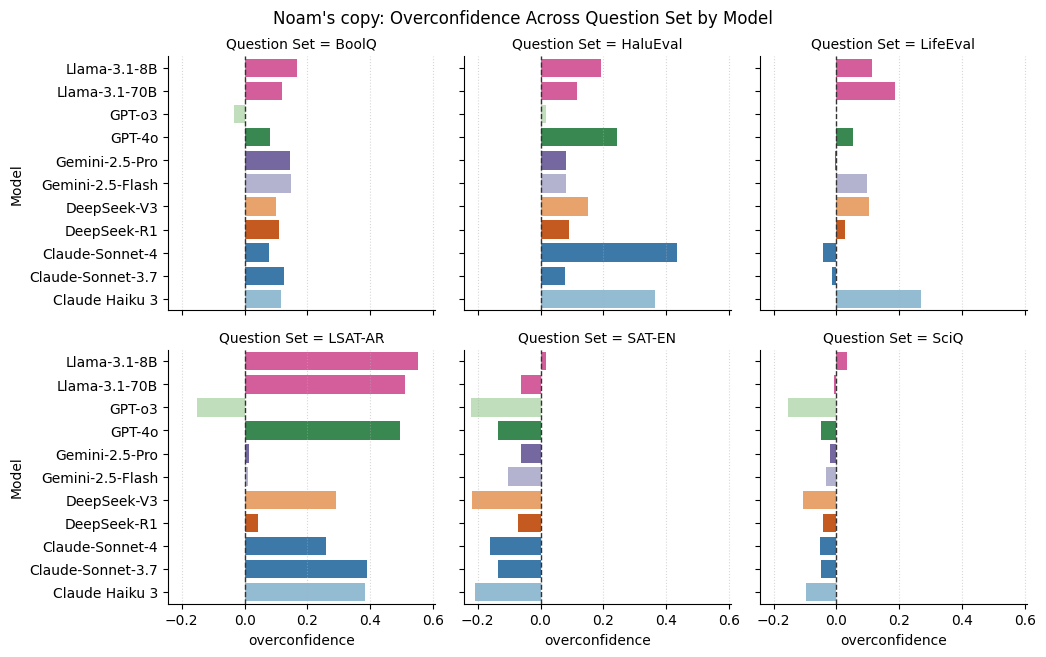

In [124]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# df has columns: "Question Set", "Model", "Overconfidence"
d = sum_df.copy()#.sort_values("Model", ascending = True)
model_order = ['Llama-3.1-8B', # Same order as Jacob
 'Llama-3.1-70B',
 'GPT-o3',
 'GPT-4o',
 'Gemini-2.5-Pro',
 'Gemini-2.5-Flash',
 'DeepSeek-V3',
 'DeepSeek-R1',
 'Claude-Sonnet-4',
 'Claude-Sonnet-3.7',
 'Claude Haiku 3'] 

palette = {m: pick_color(m) for m in sorted(d["Model"].unique(), key=str.lower)}

g = sns.catplot(
    data=d, kind="bar",
    x="Overconfidence", y="Model",
    col="Question Set", col_wrap=3,
    order=model_order, hue = "Model",
    palette = palette,
    height=3.2, aspect=1.1,# edgecolor="0.0"
)

xmin = min(-0.05, d["Overconfidence"].min()*1.1)
xmax = max( 0.05, d["Overconfidence"].max()*1.1)
g.set(xlim=(xmin, xmax), xlabel="overconfidence", ylabel="Model")

for ax in g.axes.flat:
    ax.axvline(0, linestyle="--", linewidth=1, color="0.2")
    ax.grid(True, axis="x", linestyle=":", alpha=0.5)

plt.tight_layout()
g.fig.suptitle("Noam's copy: Overconfidence Across Question Set by Model", y = 1.02)
plt.show()


In [125]:
d

Question Set              Model  Accuracy       ECE  Confidence  \
0         BoolQ  Claude-Sonnet-3.7  0.831402  0.124338    0.955741   
1         BoolQ     Claude Haiku 3  0.781462  0.117527    0.897631   
2         BoolQ    Claude-Sonnet-4  0.842988  0.080100    0.919732   
3         BoolQ        DeepSeek-R1  0.844986  0.111075    0.956061   
4         BoolQ        DeepSeek-V3  0.829005  0.102217    0.929425   
..          ...                ...       ...       ...         ...   
61         SciQ     Gemini-2.5-Pro  0.975879  0.031349    0.954440   
62         SciQ             GPT-4o  0.968844  0.054151    0.919517   
63         SciQ             GPT-o3  0.980905  0.154412    0.826492   
64         SciQ      Llama-3.1-70B  0.953769  0.042040    0.946764   
65         SciQ       Llama-3.1-8B  0.910553  0.052609    0.945143   

    Overconfidence      Gini   GiniECE  
0         0.124338  0.000000       NaN  
1         0.116169  0.000000       NaN  
2         0.076744  0.000000       NaN  
3         0.111075  0.000000       NaN  
4         0.100419  0.000000       NaN  
..             ...       ...       ...  
61       -0.021439  0.953688  0.034868  
62       -0.049327  0.907159  0.061685  
63       -0.154412  0.810017  0.170888  
64       -0.007005  0.947638  0.031631  
65        0.034590  0.956217  0.058649  

[66 rows x 8 columns]

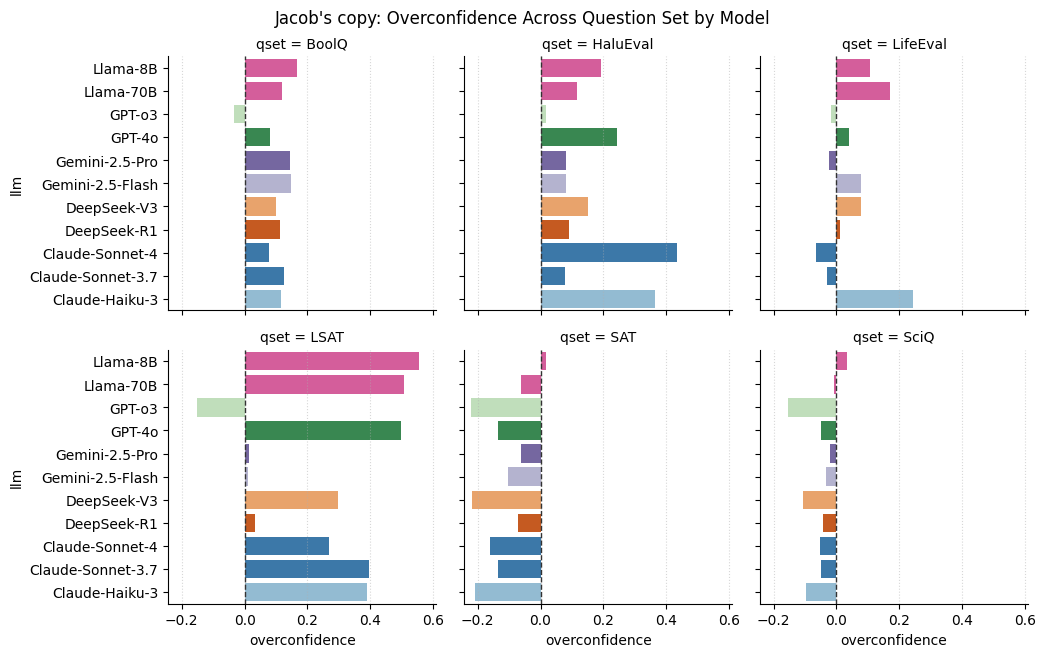

In [126]:
##
## Jacob's Version:

j = pd.read_csv(r"Combined Results\table1-info.csv")

qset_order = ["BoolQ", "HaluEval", "LifeEval", "LSAT", "SAT", "SciQ"]  # edit as needed
j["qset"] = pd.Categorical(j["qset"], categories=qset_order, ordered=True)

model_order = ['Llama-8B', # Same order as Jacob
 'Llama-70B',
 'GPT-o3',
 'GPT-4o',
 'Gemini-2.5-Pro',
 'Gemini-2.5-Flash',
 'DeepSeek-V3',
 'DeepSeek-R1',
 'Claude-Sonnet-4',
 'Claude-Sonnet-3.7',
 'Claude-Haiku-3'] 

palette = {m: pick_color(m) for m in sorted(j["llm"].unique(), key=str.lower)}

g = sns.catplot(
    data=j, kind="bar",
    x="overconfidence", y="llm",
    col="qset", col_wrap=3,
    order=model_order, hue = "llm",
    palette = palette,
    height=3.2, aspect=1.1,# edgecolor="0.0"
)

xmin = min(-0.05, j["overconfidence"].min()*1.1)
xmax = max( 0.05, j["overconfidence"].max()*1.1)
g.set(xlim=(xmin, xmax), xlabel="overconfidence", ylabel="llm")

for ax in g.axes.flat:
    ax.axvline(0, linestyle="--", linewidth=1, color="0.2")
    ax.grid(True, axis="x", linestyle=":", alpha=0.5)

plt.tight_layout()
g.fig.suptitle("Jacob's copy: Overconfidence Across Question Set by Model", y = 1.02)
plt.show()

Question Set              Model  Accuracy       ECE  Confidence  \
16     LifeEval  Claude-Sonnet-3.7  0.544942  0.040398    0.531105   
17     LifeEval    Claude-Sonnet-4  0.539776  0.063226    0.497909   
18     LifeEval        DeepSeek-R1  0.544324  0.030632    0.572344   
19     LifeEval        DeepSeek-V3  0.532636  0.124056    0.637217   
20     LifeEval   Gemini-2.5-Flash  0.537868  0.097951    0.635820   
21     LifeEval     Gemini-2.5-Pro  0.538403  0.025394    0.534193   
22     LifeEval             GPT-4o  0.545491  0.085002    0.597670   
23     LifeEval             GPT-o3  0.542480  0.028931    0.541340   
26      LSAT-AR        DeepSeek-R1  0.953488  0.046047    0.997209   

    Overconfidence      Gini   GiniECE                       name      qset  \
16       -0.013837  0.000000       NaN  LifeEvalClaude-Sonnet-3.7  LifeEval   
17       -0.041866  0.000000       NaN    LifeEvalClaude-Sonnet-4  LifeEval   
18        0.028020  0.000000       NaN        LifeEvalDeepSeek-R1  LifeEval   
19        0.104581  0.000000       NaN        LifeEvalDeepSeek-V3  LifeEval   
20        0.097951  0.000000       NaN   LifeEvalGemini-2.5-Flash  LifeEval   
21       -0.004210  0.000000       NaN     LifeEvalGemini-2.5-Pro  LifeEval   
22        0.052178  0.000000       NaN             LifeEvalGPT-4o  LifeEval   
23       -0.001140  0.000000       NaN             LifeEvalGPT-o3  LifeEval   
26        0.043721  0.996977  0.046395         LSAT-ARDeepSeek-R1   LSAT-AR   

                  llm  num_tot       ece  accuracy  confidence  avg_gini  \
16  Claude-Sonnet-3.7      751  0.041991  0.560177    0.531105       NaN   
17    Claude-Sonnet-4      751  0.065852  0.562515    0.497909       NaN   
18        DeepSeek-R1      751  0.023820  0.561326    0.572344       NaN   
19        DeepSeek-V3      751  0.102203  0.559457    0.637217       NaN   
20   Gemini-2.5-Flash      751  0.079789  0.559134    0.635820       NaN   
21     Gemini-2.5-Pro      751  0.025144  0.559279    0.534193       NaN   
22             GPT-4o      751  0.068043  0.557286    0.597670       NaN   
23             GPT-o3      751  0.028834  0.558947    0.541340       NaN   
26        DeepSeek-R1       87  0.034023  0.965517    0.997241  0.005277   

    overconfidence      diff  
16       -0.029072  0.015235  
17       -0.064606  0.022740  
18        0.011018  0.017002  
19        0.077760  0.026821  
20        0.076686  0.021266  
21       -0.025086  0.020876  
22        0.040384  0.011795  
23       -0.017607  0.016467  
26        0.031724  0.011997

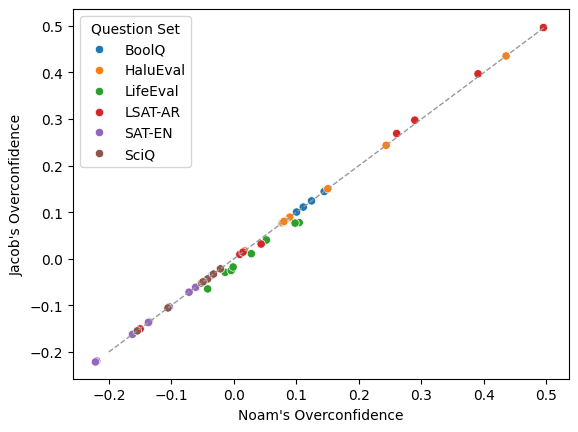

In [127]:
j['qset'] = j['qset'].cat.rename_categories({"LSAT": "LSAT-AR", "SAT": "SAT-EN"})

j['name'] = j['qset'].astype(str) + j['llm'].astype(str) 
d['name'] = d['Question Set'] + d['Model']

merged = pd.merge(d,j , on = "name", suffixes= ['_noam', '_jacob'])
merged['diff'] = merged['Overconfidence'] - merged['overconfidence']

display(merged[abs(merged['diff']) > 0.01]) # These are all the instances where Jacob and I disagree (some very small differences exist due to FPA)

ax = sns.scatterplot(data = merged, x ="Overconfidence", y = "overconfidence", hue = "Question Set")
plt.xlabel("Noam's Overconfidence")
plt.ylabel("Jacob's Overconfidence")
lo = -0.2
hi = 0.5
ax.plot([lo, hi], [lo, hi], ls="--", c="0.6", lw=1) 
plt.show()


---
## ECE Plots


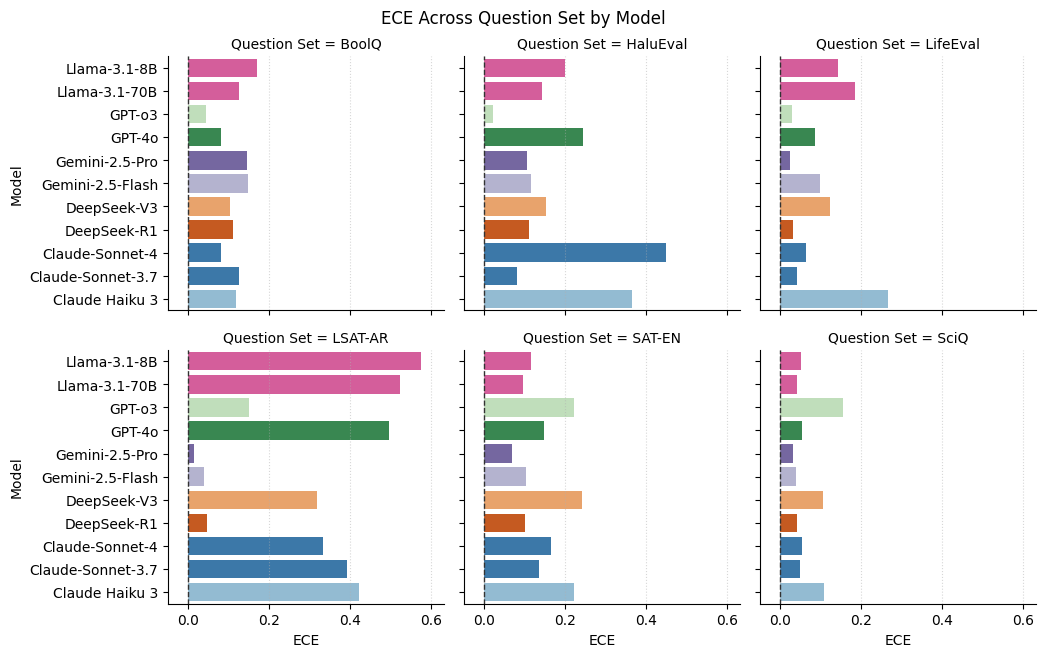

In [128]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# df has columns: "Question Set", "Model", "Overconfidence"
d = sum_df.copy()#.sort_values("Model", ascending = True)
model_order = ['Llama-3.1-8B', # Same order as Jacob
 'Llama-3.1-70B',
 'GPT-o3',
 'GPT-4o',
 'Gemini-2.5-Pro',
 'Gemini-2.5-Flash',
 'DeepSeek-V3',
 'DeepSeek-R1',
 'Claude-Sonnet-4',
 'Claude-Sonnet-3.7',
 'Claude Haiku 3'] 

palette = {m: pick_color(m) for m in sorted(d["Model"].unique(), key=str.lower)}

g = sns.catplot(
    data=d, kind="bar",
    x="ECE", y="Model",
    col="Question Set", col_wrap=3,
    order=model_order, hue = "Model",
    palette = palette,
    height=3.2, aspect=1.1,# edgecolor="0.0"
)

xmin = min(-0.05, d["ECE"].min()*1.1)
xmax = max( 0.05, d["ECE"].max()*1.1)
g.set(xlim=(xmin, xmax), xlabel="ECE", ylabel="Model")

for ax in g.axes.flat:
    ax.axvline(0, linestyle="--", linewidth=1, color="0.2")
    ax.grid(True, axis="x", linestyle=":", alpha=0.5)

plt.tight_layout()
g.figure.suptitle("ECE Across Question Set by Model", y = 1.02)
plt.show()

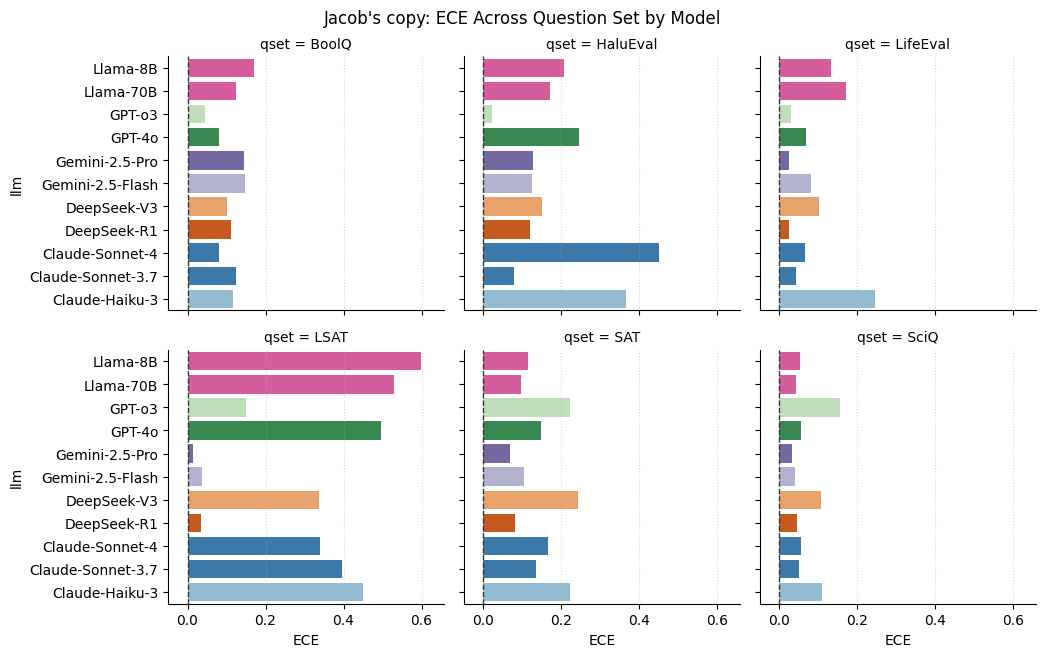

In [129]:
##
## Jacob's Version:

j = pd.read_csv(r"Combined Results\table1-info.csv")

qset_order = ["BoolQ", "HaluEval", "LifeEval", "LSAT", "SAT", "SciQ"]  # edit as needed
j["qset"] = pd.Categorical(j["qset"], categories=qset_order, ordered=True)

model_order = ['Llama-8B', # Same order as Jacob
 'Llama-70B',
 'GPT-o3',
 'GPT-4o',
 'Gemini-2.5-Pro',
 'Gemini-2.5-Flash',
 'DeepSeek-V3',
 'DeepSeek-R1',
 'Claude-Sonnet-4',
 'Claude-Sonnet-3.7',
 'Claude-Haiku-3'] 

palette = {m: pick_color(m) for m in sorted(j["llm"].unique(), key=str.lower)}

g = sns.catplot(
    data=j, kind="bar",
    x="ece", y="llm",
    col="qset", col_wrap=3,
    order=model_order, hue = "llm",
    palette = palette,
    height=3.2, aspect=1.1,# edgecolor="0.0"
)

xmin = min(-0.05, j["ece"].min()*1.1)
xmax = max( 0.05, j["ece"].max()*1.1)
g.set(xlim=(xmin, xmax), xlabel="ECE", ylabel="llm")

for ax in g.axes.flat:
    ax.axvline(0, linestyle="--", linewidth=1, color="0.2")
    ax.grid(True, axis="x", linestyle=":", alpha=0.5)

plt.tight_layout()
g.fig.suptitle("Jacob's copy: ECE Across Question Set by Model", y = 1.02)
plt.show()

Lets see how well they line up like before:

Question Set             Model  Accuracy       ECE  Confidence  \
12     HaluEval  Gemini-2.5-Flash  0.521229  0.114547    0.602872   
13     HaluEval    Gemini-2.5-Pro  0.521229  0.105503    0.601369   
19     LifeEval       DeepSeek-V3  0.532636  0.124056    0.637217   
20     LifeEval  Gemini-2.5-Flash  0.537868  0.097951    0.635820   
22     LifeEval            GPT-4o  0.545491  0.085002    0.597670   
26      LSAT-AR       DeepSeek-R1  0.953488  0.046047    0.997209   
27      LSAT-AR       DeepSeek-V3  0.348837  0.317442    0.638372   
34       SAT-EN       DeepSeek-R1  0.942197  0.100058    0.870578   

    Overconfidence      Gini   GiniECE                      name      qset  \
12        0.081642  0.000000       NaN  HaluEvalGemini-2.5-Flash  HaluEval   
13        0.080140  0.000000       NaN    HaluEvalGemini-2.5-Pro  HaluEval   
19        0.104581  0.000000       NaN       LifeEvalDeepSeek-V3  LifeEval   
20        0.097951  0.000000       NaN  LifeEvalGemini-2.5-Flash  LifeEval   
22        0.052178  0.000000       NaN            LifeEvalGPT-4o  LifeEval   
26        0.043721  0.996977  0.046395        LSAT-ARDeepSeek-R1   LSAT-AR   
27        0.289535  0.625581  0.309884        LSAT-ARDeepSeek-V3   LSAT-AR   
34       -0.071618  0.847900  0.116416         SAT-ENDeepSeek-R1    SAT-EN   

                 llm  num_tot       ece  accuracy  confidence  avg_gini  \
12  Gemini-2.5-Flash     1790  0.125721  0.521229    0.602872       NaN   
13    Gemini-2.5-Pro     1790  0.126732  0.521229    0.601369       NaN   
19       DeepSeek-V3      751  0.102203  0.559457    0.637217       NaN   
20  Gemini-2.5-Flash      751  0.079789  0.559134    0.635820       NaN   
22            GPT-4o      751  0.068043  0.557286    0.597670       NaN   
26       DeepSeek-R1       87  0.034023  0.965517    0.997241  0.005277   
27       DeepSeek-V3       87  0.336782  0.344828    0.642529  0.465546   
34       DeepSeek-R1      173  0.081445  0.942197    0.870578  0.222920   

    overconfidence      diff  
12        0.081642 -0.011173  
13        0.080140 -0.021229  
19        0.077760  0.021853  
20        0.076686  0.018162  
22        0.040384  0.016959  
26        0.031724  0.012024  
27        0.297701 -0.019340  
34       -0.071618  0.018613

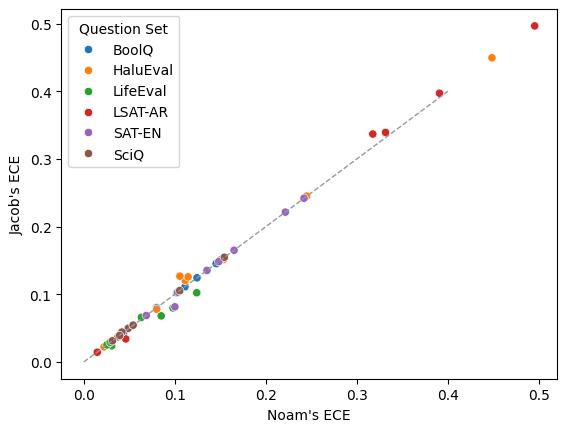

In [130]:
j['qset'] = j['qset'].cat.rename_categories({"LSAT": "LSAT-AR", "SAT": "SAT-EN"})

j['name'] = j['qset'].astype(str) + j['llm'].astype(str) 
d['name'] = d['Question Set'] + d['Model']

merged = pd.merge(d,j ,on = "name", suffixes= ['_noam', '_jacob'])
merged['diff'] = merged['ECE'] - merged['ece']

display(merged[abs(merged['diff']) > 0.01]) # These are all the instances where Jacob and I disagree (some very small differences exist due to FPA)

ax = sns.scatterplot(data = merged, x ="ECE", y = "ece", hue = "Question Set")
plt.xlabel("Noam's ECE")
plt.ylabel("Jacob's ECE")
lo = 0.0
hi = 0.4
ax.plot([lo, hi], [lo, hi], ls="--", c="0.6", lw=1) 
plt.show()


In [131]:
(combined_clean["Answer"] == "E").sum()

np.int64(156)

In [132]:
combined_clean["Answer"].value_counts().head(10)

Answer
True     13064
False    11966
D         3654
A         3650
B         3206
C         3128
True      1283
False     1220
85         859
81         727
Name: count, dtype: int64

Although we have the same average confidence and accuracy for HaluEval, we differ on ECE scores. I wonder why?

I always inlcude the lowest value (e.g. [0.1, 0.2)

It seems that Jacob uses `confidence_bin = cut(stated_confidence, breaks = 10)` in order to slice up the bins. I think in my implementation I added an additional bin for [1.0] leading to 11 bins while Jacob has 10. This may be the reason for differing results when looking at ECE.

# Pre-Registered Analysis

* For each model/question set combination we will compute ECE and overconfidence. We will test whether they differ from zero for each model and in aggregate.
* In addition, we will build  a calibration plot. The calibration plot will be designed as follows: Confidence (stated or token)  along the x-axis and accuracy on the y-axis. The analysis is at the level of the bin, which is to say for multiple-choice questions with 4 answer options, there will be 4 observations. Answer options are binned according to the probability assigned to them by the LLM. The 11 bins are: [0-10), [10-20), [20-30), [30-40), [40-50), [50-60), [60-70), [70-80), [80-90), [90-100), [100]
* For each of the 11 bins, we average the confidence of observations within it, and that determines where the dot is placed on the horizontal axis. We then average the accuracy of those responses (what percentage of the time is that answer option the right one?) and that accuracy determines the dot's location on the y-axis.

## ECE Plots

First we can look at how each model did on each question set individually:

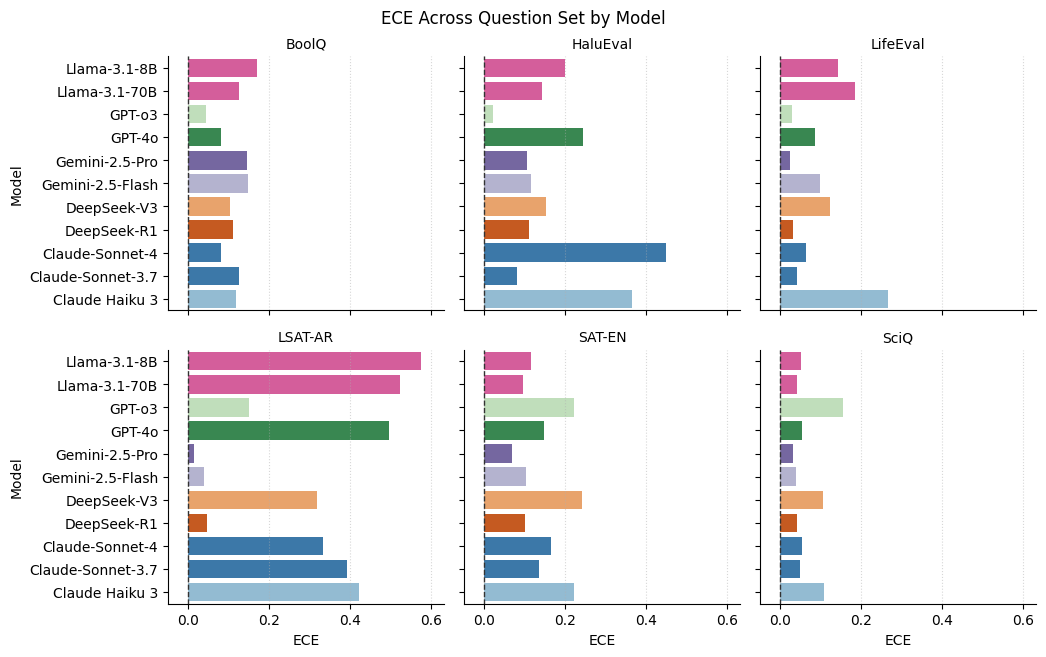

In [133]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# df has columns: "Question Set", "Model", "Overconfidence"
d = sum_df.copy()#.sort_values("Model", ascending = True)
no_le = d[d['Question Set'] != 'LifeEval']
model_order = ['Llama-3.1-8B', # Same order as Jacob
 'Llama-3.1-70B',
 'GPT-o3',
 'GPT-4o',
 'Gemini-2.5-Pro',
 'Gemini-2.5-Flash',
 'DeepSeek-V3',
 'DeepSeek-R1',
 'Claude-Sonnet-4',
 'Claude-Sonnet-3.7',
 'Claude Haiku 3'] 

palette = {m: pick_color(m) for m in sorted(d["Model"].unique(), key=str.lower)}

g = sns.catplot(
    data=d, kind="bar",
    x="ECE", y="Model",
    col="Question Set", col_wrap=3,
    order=model_order, hue = "Model",
    palette = palette,
    height=3.2, aspect=1.1,# edgecolor="0.0"
)

xmin = min(-0.05, d["ECE"].min()*1.1)
xmax = max( 0.05, d["ECE"].max()*1.1)
g.set(xlim=(xmin, xmax), xlabel="ECE", ylabel="Model")

g.set_titles(col_template="{col_name}")

for ax in g.axes.flat:
    ax.axvline(0, linestyle="--", linewidth=1, color="0.2")
    ax.grid(True, axis="x", linestyle=":", alpha=0.5)

plt.tight_layout()
g.figure.suptitle("ECE Across Question Set by Model", y = 1.02)
plt.show()

## Gini ECE Plots

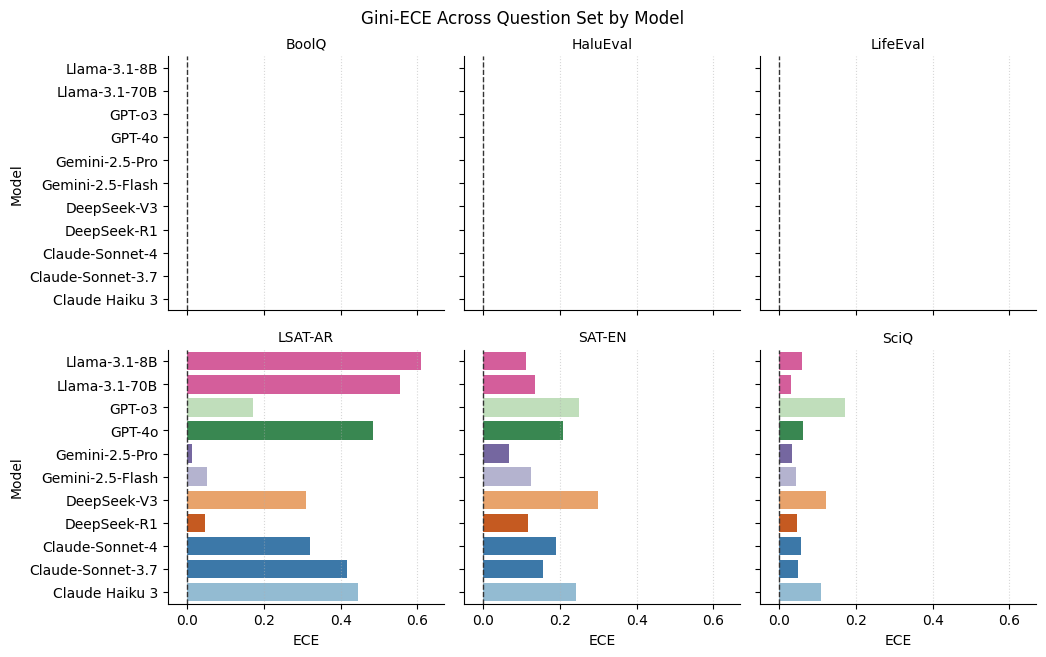

In [134]:
# Compare to Gini ECE

# df has columns: "Question Set", "Model", "Overconfidence"
d = sum_df.copy()#.sort_values("Model", ascending = True)
no_le = d[d['Question Set'] != 'LifeEval']
model_order = ['Llama-3.1-8B', # Same order as Jacob
 'Llama-3.1-70B',
 'GPT-o3',
 'GPT-4o',
 'Gemini-2.5-Pro',
 'Gemini-2.5-Flash',
 'DeepSeek-V3',
 'DeepSeek-R1',
 'Claude-Sonnet-4',
 'Claude-Sonnet-3.7',
 'Claude Haiku 3'] 

palette = {m: pick_color(m) for m in sorted(d["Model"].unique(), key=str.lower)}

g = sns.catplot(
    data=d, kind="bar",
    x="GiniECE", y="Model",
    col="Question Set", col_wrap=3,
    order=model_order, hue = "Model",
    palette = palette,
    height=3.2, aspect=1.1,# edgecolor="0.0"
)

xmin = min(-0.05, d["GiniECE"].min()*1.1)
xmax = max( 0.05, d["GiniECE"].max()*1.1)
g.set(xlim=(xmin, xmax), xlabel="ECE", ylabel="Model")

g.set_titles(col_template="{col_name}")

for ax in g.axes.flat:
    ax.axvline(0, linestyle="--", linewidth=1, color="0.2")
    ax.grid(True, axis="x", linestyle=":", alpha=0.5)

plt.tight_layout()
g.figure.suptitle("Gini-ECE Across Question Set by Model", y = 1.02)
plt.show()

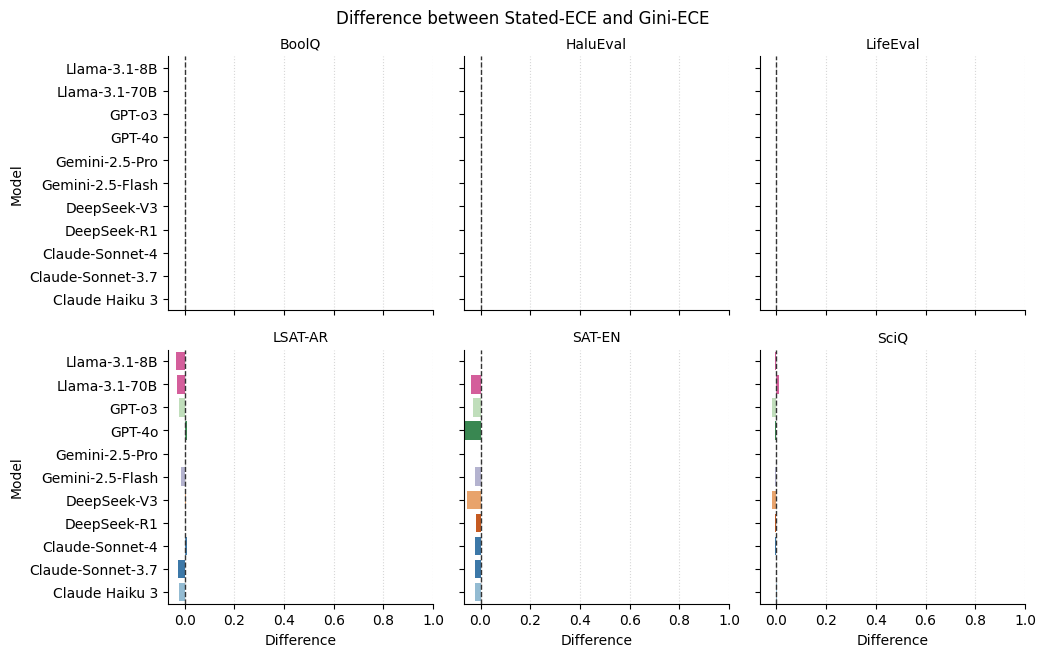

In [135]:
# Compare the two metrics:

# Compare to Gini ECE

# df has columns: "Question Set", "Model", "Overconfidence"
d = sum_df.copy()#.sort_values("Model", ascending = True)
d['diffECE'] = d['ECE'] - d['GiniECE']
no_le = d[d['Question Set'] != 'LifeEval']
model_order = ['Llama-3.1-8B', # Same order as Jacob
 'Llama-3.1-70B',
 'GPT-o3',
 'GPT-4o',
 'Gemini-2.5-Pro',
 'Gemini-2.5-Flash',
 'DeepSeek-V3',
 'DeepSeek-R1',
 'Claude-Sonnet-4',
 'Claude-Sonnet-3.7',
 'Claude Haiku 3'] 

palette = {m: pick_color(m) for m in sorted(d["Model"].unique(), key=str.lower)}

g = sns.catplot(
    data=d, kind="bar",
    x="diffECE", y="Model",
    col="Question Set", col_wrap=3,
    order=model_order, hue = "Model",
    palette = palette,
    height=3.2, aspect=1.1,# edgecolor="0.0"
)

xmin = min(-0.05, d["diffECE"].min()*1.1)
xmax = max( 1, d["diffECE"].max()*1.1)
g.set(xlim=(xmin, xmax), xlabel="Difference", ylabel="Model")

g.set_titles(col_template="{col_name}")

for ax in g.axes.flat:
    ax.axvline(0, linestyle="--", linewidth=1, color="0.2")
    ax.grid(True, axis="x", linestyle=":", alpha=0.5)

plt.tight_layout()
g.figure.suptitle("Difference between Stated-ECE and Gini-ECE", y = 1.02)
plt.show()

In [136]:
goo =combined_clean[(combined_clean['Model'] == 'Claude-Sonnet-3.7') & (combined_clean['Question Set'] == 'LSAT-AR')]

g = goo['gini']
c = goo['Stated Confidence Answer (MCQ)']
s = goo['Score']

get_ece(s,g), get_ece(s,c)


(np.float64(0.4175581395348838), np.float64(0.3906976744186046))

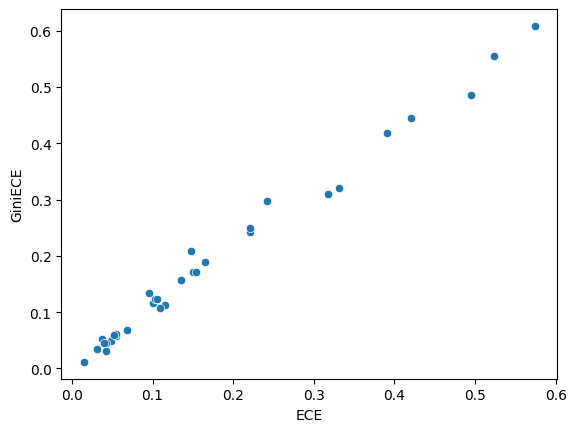

In [137]:
goo =d[['Model','Question Set', 'ECE', 'Gini', 'GiniECE', 'diffECE']].dropna(axis = 0)

ax = sns.scatterplot(goo, x = 'ECE', y = 'GiniECE')
plt.show()


We found that gini-ece and stated ece were highly correletated (r = ??) with gini being as good if not slightly worse than stated-ece

Now, lets see how models did in agregate:

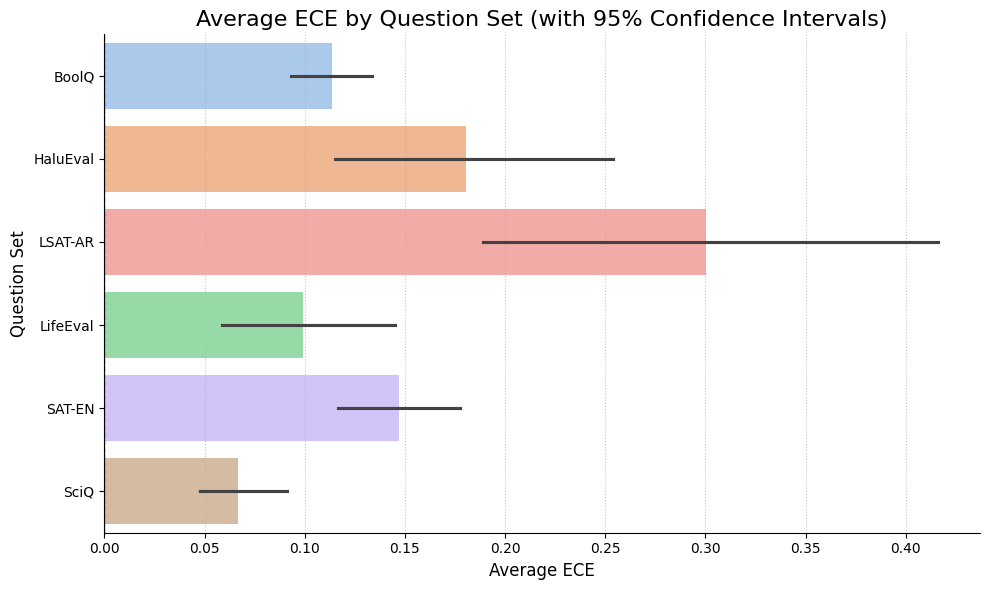

In [138]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'd' is your original DataFrame with ECE values 
# for each model and question set.

# 1. Determine the sorted order for the plot
# We do this by calculating the mean ECE for each set and sorting them,
# Doing so alphabetically
order_of_sets = d.groupby('Question Set')['Question Set'].unique().sort_values(ascending=True).index

# 2. Create the plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=d,             # *** Pass the original DataFrame 'd' ***
    x='ECE',
    y='Question Set',
    hue = "Question Set",
    order=order_of_sets, # Apply the sorted order
    palette='pastel'
    # Seaborn automatically calculates the mean and 95% confidence
    # interval (the error bars) when you pass the full data.
)

# Set labels and title
ax.set_title('Average ECE by Question Set (with 95% Confidence Intervals)', fontsize=16)
ax.set_xlabel('Average ECE', fontsize=12)
ax.set_ylabel('Question Set', fontsize=12)

# Add gridlines and clean up spines, similar to your original plot
ax.grid(True, axis='x', linestyle=':', alpha=0.7)
ax.axvline(0, linestyle="--", linewidth=1, color="0.2") # Add the zero line
ax.spines[['right', 'top']].set_visible(False)

plt.tight_layout()
plt.show()

## Overconfidence Plots

Like before, we can first compare how overconfident models were individually.

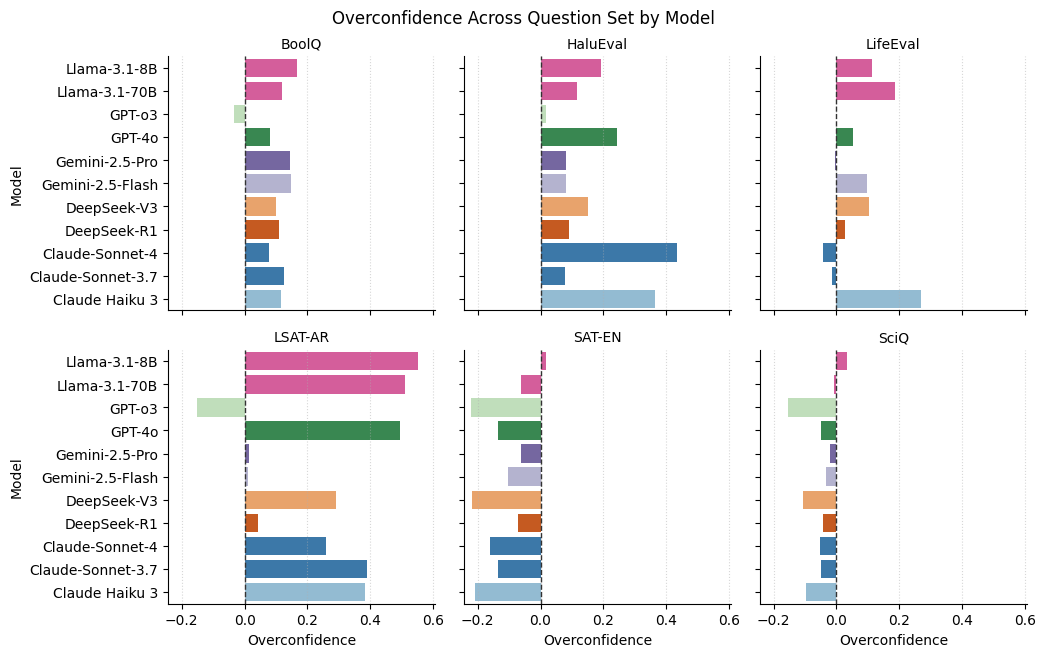

In [139]:
# df has columns: "Question Set", "Model", "Overconfidence"
d = sum_df.copy()#.sort_values("Model", ascending = True)
model_order = ['Llama-3.1-8B', # Same order as Jacob
 'Llama-3.1-70B',
 'GPT-o3',
 'GPT-4o',
 'Gemini-2.5-Pro',
 'Gemini-2.5-Flash',
 'DeepSeek-V3',
 'DeepSeek-R1',
 'Claude-Sonnet-4',
 'Claude-Sonnet-3.7',
 'Claude Haiku 3'] 

palette = {m: pick_color(m) for m in sorted(d["Model"].unique(), key=str.lower)}

g = sns.catplot(
    data=d, kind="bar",
    x="Overconfidence", y="Model",
    col="Question Set", col_wrap=3,
    order=model_order, hue = "Model",
    palette = palette,
    height=3.2, aspect=1.1,# edgecolor="0.0"
)

xmin = min(-0.05, d["Overconfidence"].min()*1.1)
xmax = max( 0.05, d["Overconfidence"].max()*1.1)
g.set(xlim=(xmin, xmax), xlabel="Overconfidence", ylabel="Model")
g.set_titles(col_template="{col_name}")


for ax in g.axes.flat:
    ax.axvline(0, linestyle="--", linewidth=1, color="0.2")
    ax.grid(True, axis="x", linestyle=":", alpha=0.5)

plt.tight_layout()
g.figure.suptitle("Overconfidence Across Question Set by Model", y = 1.02)
plt.show()


And again, lets see how models did in agregate:


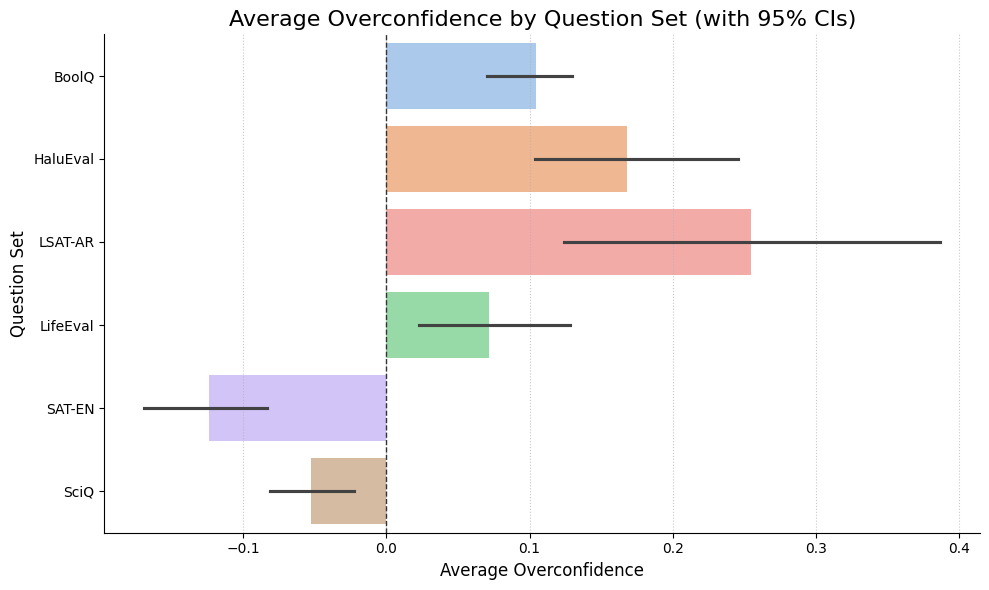

In [140]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'd' is your DataFrame with "Overconfidence", "Model", 
# and "Question Set" columns.

# 1. Determine the sorted order for the plot
# We sort by the mean overconfidence for each question set.
overconfidence_order = d.groupby('Question Set')['Overconfidence'].mean().sort_values(ascending=False).index
order_of_sets = d.groupby('Question Set')['Question Set'].unique().sort_values(ascending=True).index

# 2. Create the plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=d,                  # *** Pass the original DataFrame 'd' ***
    x='Overconfidence',      # *** Plot the 'Overconfidence' column ***
    y='Question Set',
    order=order_of_sets, # Apply the sorted order
    hue = "Question Set",
    palette='pastel'         # Switched palette for variety (cool colors)
)

# Set labels and title
ax.set_title('Average Overconfidence by Question Set (with 95% CIs)', fontsize=16)
ax.set_xlabel('Average Overconfidence', fontsize=12)
ax.set_ylabel('Question Set', fontsize=12)

# Add gridlines and clean up spines
ax.grid(True, axis='x', linestyle=':', alpha=0.7)
ax.axvline(0, linestyle="--", linewidth=1, color="0.2") # Add the zero line
ax.spines[['right', 'top']].set_visible(False)

plt.tight_layout()
plt.show()

## Accuracy Plots

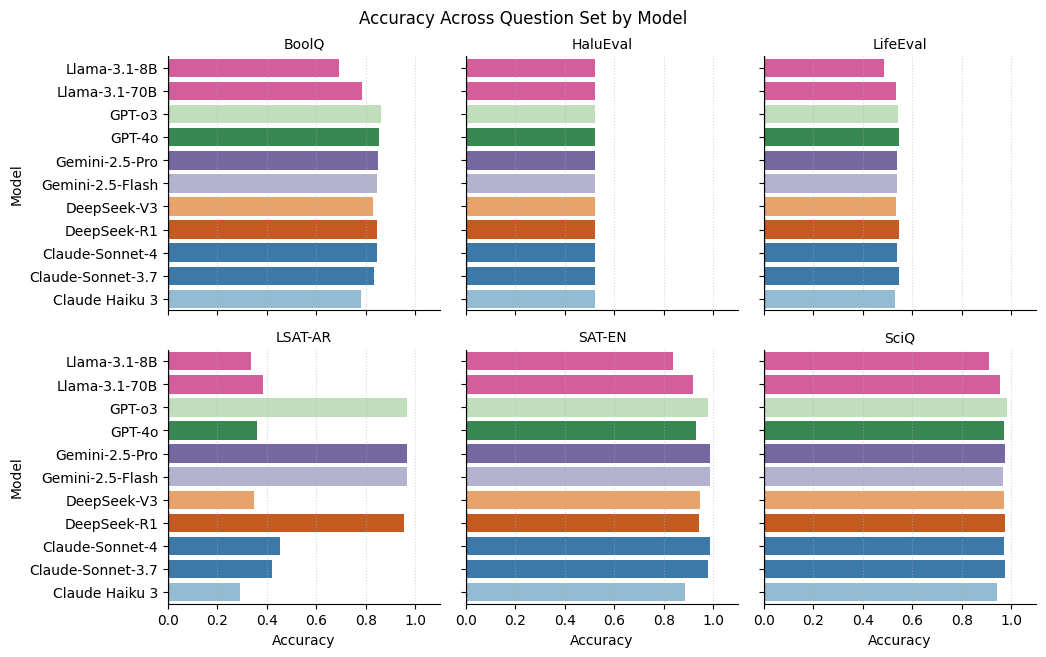

In [141]:
# df has columns: "Question Set", "Model", "Overconfidence"
d = sum_df.copy()#.sort_values("Model", ascending = True)
model_order = ['Llama-3.1-8B', # Same order as Jacob
 'Llama-3.1-70B',
 'GPT-o3',
 'GPT-4o',
 'Gemini-2.5-Pro',
 'Gemini-2.5-Flash',
 'DeepSeek-V3',
 'DeepSeek-R1',
 'Claude-Sonnet-4',
 'Claude-Sonnet-3.7',
 'Claude Haiku 3'] 

palette = {m: pick_color(m) for m in sorted(d["Model"].unique(), key=str.lower)}

g = sns.catplot(
    data=d, kind="bar",
    x="Accuracy", y="Model",
    col="Question Set", col_wrap=3,
    order=model_order, hue = "Model",
    palette = palette,
    height=3.2, aspect=1.1,# edgecolor="0.0"
)

xmin = 0
xmax = 1.1
g.set(xlim=(xmin, xmax), xlabel="Accuracy", ylabel="Model")
g.set_titles(col_template="{col_name}")


for ax in g.axes.flat:
    ax.axvline(0, linestyle="--", linewidth=1, color="0.2")
    ax.grid(True, axis="x", linestyle=":", alpha=0.5)

plt.tight_layout()
g.figure.suptitle("Accuracy Across Question Set by Model", y = 1.02)
plt.show()


In [175]:
lsat = d[d['Question Set'] == 'LSAT-AR']
lsat['Accuracy'].value_counts()

Accuracy
0.965116    3
0.418605    1
0.290698    1
0.953488    1
0.453488    1
0.348837    1
0.360465    1
0.383721    1
0.337209    1
Name: count, dtype: int64

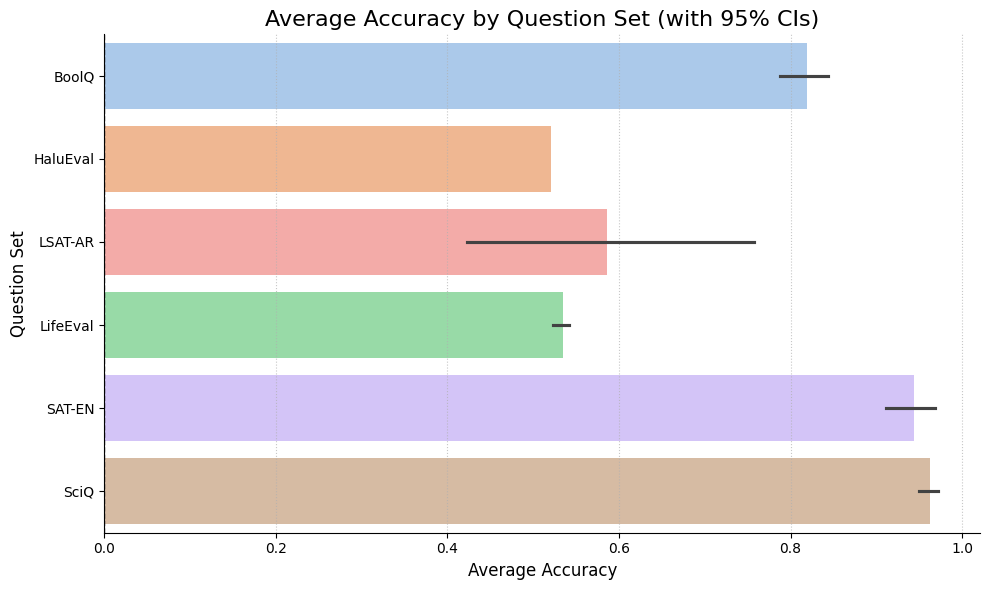

In [142]:


# 1. Determine the sorted order for the plot
# We sort by the mean overconfidence for each question set.
overconfidence_order = d.groupby('Question Set')['Accuracy'].mean().sort_values(ascending=False).index
order_of_sets = d.groupby('Question Set')['Question Set'].unique().sort_values(ascending=True).index

# 2. Create the plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=d,                  # *** Pass the original DataFrame 'd' ***
    x='Accuracy',      # *** Plot the 'Overconfidence' column ***
    y='Question Set',
    order=order_of_sets, # Apply the sorted order
    hue = "Question Set",
    palette='pastel'         # Switched palette for variety (cool colors)
)

# Set labels and title
ax.set_title('Average Accuracy by Question Set (with 95% CIs)', fontsize=16)
ax.set_xlabel('Average Accuracy', fontsize=12)
ax.set_ylabel('Question Set', fontsize=12)

# Add gridlines and clean up spines
ax.grid(True, axis='x', linestyle=':', alpha=0.7)
ax.axvline(0, linestyle="--", linewidth=1, color="0.2") # Add the zero line
ax.spines[['right', 'top']].set_visible(False)

plt.tight_layout()
plt.show()

In [202]:
lsat = d[d['Question Set'] == 'LSAT-AR']
lsat.Accuracy#.mean()

33    0.418605
34    0.290698
35    0.453488
36    0.953488
37    0.348837
38    0.965116
39    0.965116
40    0.360465
41    0.965116
42    0.383721
43    0.337209
Name: Accuracy, dtype: float64

## Calibration Plots

Individual Calibration plots can be found in the `Plots` folder. We want to see how models did in agregate.

In [143]:
combined_clean

Reasoning Answer  \
0      The question is asking whether the production ...  False   
2      This question is asking about phantom limb pai...   True   
3      Harry Potter and the Escape from Gringotts is ...   True   
4      Hydroxyzine HCl (hydrochloride) and hydroxyzin...   True   
5      Barq's Root Beer is not a Pepsi product. It is...  False   
...                                                  ...    ...   
82636  Predation is a biological process where one sp...      A   
82637  Short period comets are thought to originate f...      A   
82638  The question is asking about the developmental...      D   
82639  Atoms with unstable nuclei are those that have...      D   
82640  Atmospheric sulfur is primarily found in the f...      C   

      Stated Confidence Answer  Coerce  \
0                          0.6    True   
2                         0.95    True   
3                         0.98    True   
4                         0.98    True   
5                         0.98    True   
...                        ...     ...   
82636                      NaN    True   
82637                      NaN    True   
82638                      NaN    True   
82639                      NaN    True   
82640                      NaN    True   

                                                 Content Question ID  \
0      {\n    "Reasoning": "The question is asking wh...           0   
2      {\n    "Reasoning": "This question is asking a...           2   
3      {\n    "Reasoning": "Harry Potter and the Esca...           3   
4      {\n    "Reasoning": "Hydroxyzine HCl (hydrochl...           4   
5      {\n    "Reasoning": "Barq's Root Beer is not a...           5   
...                                                  ...         ...   
82636  {\n"Reasoning": "Predation is a biological pro...         995   
82637  {\n"Reasoning": "Short period comets are thoug...         996   
82638  {\n"Reasoning": "The question is asking about ...         997   
82639  {\n"Reasoning": "Atoms with unstable nuclei ar...         998   
82640  {\n"Reasoning": "Atmospheric sulfur is primari...         999   

                   Model Model Type Question Set  Score  ...  \
0      Claude-Sonnet-3.7     Claude        BoolQ    1.0  ...   
2      Claude-Sonnet-3.7     Claude        BoolQ    1.0  ...   
3      Claude-Sonnet-3.7     Claude        BoolQ    1.0  ...   
4      Claude-Sonnet-3.7     Claude        BoolQ    1.0  ...   
5      Claude-Sonnet-3.7     Claude        BoolQ    1.0  ...   
...                  ...        ...          ...    ...  ...   
82636       Llama-3.1-8B      Llama         SciQ    1.0  ...   
82637       Llama-3.1-8B      Llama         SciQ    1.0  ...   
82638       Llama-3.1-8B      Llama         SciQ    1.0  ...   
82639       Llama-3.1-8B      Llama         SciQ    1.0  ...   
82640       Llama-3.1-8B      Llama         SciQ    1.0  ...   

      Token Probability True  Token Probability False  \
0                        NaN                      NaN   
2                        NaN                      NaN   
3                        NaN                      NaN   
4                        NaN                      NaN   
5                        NaN                      NaN   
...                      ...                      ...   
82636                    NaN                      NaN   
82637                    NaN                      NaN   
82638                    NaN                      NaN   
82639                    NaN                      NaN   
82640                    NaN                      NaN   

       Token Probability Answer  Token Probability A  Token Probability B  \
0                           NaN                  NaN                  NaN   
2                           NaN                  NaN                  NaN   
3                           NaN                  NaN                  NaN   
4                           NaN                  NaN                  NaN   
5                           NaN  

In [144]:
def expand_mcq(df, tokens = False):
    s = []
    c = []


    # Using iterrows correctly now: 'row' is the Series data for the current row
    for index, row in df.iterrows(): 
        # --- 1. Handle the Model's Stated Answer ---
        if row['Question Set'] == 'LSAT-AR':
            letters = ['A', 'B', 'C', 'D', 'E']
        else:
                letters = ['A', 'B', 'C', 'D']
        
        # --- 2. Handle the Other (Unanswered) Options ---
        ca = row['Correct Answer']

        for l in letters:
            # Score is 1 (True) or 0 (False)
            l_score = 1 if l == ca else 0 

            l_conf_col = f"Stated Confidence {l}"
            if tokens:
                l_conf_col =  f"Token Probability {l}"
            l_conf = row[l_conf_col]
            
            # # Check for NaN/missing confidence (e.g., option 'E' in some 4-option questions)
            # if pd.isna(l_conf): # Changed to pd.isna() for clarity/safety
            #     continue

            # FIX 2: Append the new confidence value (l_conf), not the list itself (c)
            s.append(l_score)
            c.append(l_conf) # <-- Corrected: Appending the single confidence value

    
    return s, c

def expand_bool(df, tokens = False):
    s = []
    c = []
    letters = ['True', 'False']

    # Using iterrows correctly now: 'row' is the Series data for the current row
    for index, row in df.iterrows(): 
        # --- 1. Handle the Model's Stated Answer ---
        stated_answer = row['Answer']

        con_str = 'Stated Confidence Answer'
        if tokens:
            con_str = f"Token Probability {stated_answer}"
        stated_answer_confidence = row[con_str]
        stated_answer_score = row['Score']

        s.append(stated_answer_score)
        c.append(stated_answer_confidence)
        
        # --- 2. Handle the Other (Unanswered) Options ---

        not_stated_answer  = stated_answer == False
        not_stated_answer_confidence = 1 - stated_answer_confidence
        not_stated_answer_score = float(stated_answer_score == 0)

        s.append(not_stated_answer_score)
        c.append(not_stated_answer_confidence)

    
    return s, c
    

def melt_series(score, confidence):
    df = pd.DataFrame({'confidence': confidence, 'score': score})
    df = add_confidence_bin(df)
    df['score'] = df['score'].astype('float')
    # Group by confidence and aggregate
    melt_df = df.groupby('bin', observed=False).agg(
        mean_score=('score', 'mean'),
        count=('score', 'size'),
        mean_confidence = ('confidence', 'mean')
    ).reset_index()


    return melt_df


def add_confidence_bin(df: pd.DataFrame, col: str = 'confidence') -> pd.DataFrame:
    # Copy to avoid modifying original
    df = df.copy()

    # Clip confidence to [0, 1]
    df[col] = df[col].clip(0, 1)

    # Define bin edges and labels for 11 equal-width bins
    bins = np.linspace(0, 1, 11)        # edges: 0.0, 0.1, ..., 1.0 (11 edges -> 10 bins)
    # Labels correspond to the left-edge of each bin (0.1, 0.2, ..., 1.0)
    labels = [round(x, 1) for x in bins[0:]]

    # Assign bin label
    df['bin'] = pd.cut(
        df[col],
        bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.000001],
        labels=labels,
        ordered=False,
        right=False,   # include the right edge in the bin
        include_lowest=True
    )

    return df

def calibration_plot(sc_df, conf = 'SC', scores = 'Score', 
                     bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.000001],
                     title = 'Aggregate Calibration Plot for all Confidence Measures\nExtended MCQ and 2AFC Responses',
                     ax = None,
                     legend = True, color = 'black', label = None):
    if ax is None:
        ax = plt.gca()

    global grouped

    sc_df['bin'] = pd.cut(sc_df[conf], bins = bins, right = False)

    # --------- Group sc_df -------------------

    grouped = sc_df.groupby('bin', observed= False)[[conf, scores]].agg(['mean', 'count', 'std'])
    grouped


    sc_out = grouped.loc[:, [
        (scores, 'mean'),
        (conf, 'mean'),
        (scores, 'count'),         
        (scores, 'std')
    ]]

    # rename to desired names
    sc_out.columns = ['mean_score', 'mean_confidence', 'count', 'std']

    # Calculate Confidence Interval
    se = sc_out["std"] / np.sqrt(sc_out["count"])   # standard error per bin
    sc_out["ci"] = 1.96 * se  

    sc_out
    # ________________________ Plotting ----------------------------

    ticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    
    ax.axline([0, 0], [1, 1], color='grey', linestyle='--', label='Line of Perfect Calibration', alpha = 0.5)



    ax.errorbar(
        sc_out['mean_confidence'],
        sc_out['mean_score'],
        yerr= sc_out['ci'],  # symmetric CI
        fmt='none',   # no extra markers (we already drew them with seaborn)
        linewidth = 2,
        capsize = 0,
        color = 'lightgrey',
        ecolor = 'lightgrey',
        barsabove = False
    )
    if label:
        dot_label = label
    else:
        dot_label  =  'Stated Confidence'
    sns.scatterplot(sc_out, y = 'mean_score', x = 'mean_confidence', label = dot_label, color = color, zorder = 3, ax = ax)

    ax.grid(True, linestyle='--', alpha=0.35)
    if legend:
        ax.legend(loc='lower right')
    else:
        ax.legend().remove()

    ax.set_xlabel('Confidence')
    ax.set_ylabel('Accuracy')

    ax.set_ylim(0, 1.1)
    ax.set_xlim(0, 1.1)

    ax.set_title(title)

    #ax.show()



### Combined Agregate Plot

Issues with the combined calibration plot.

1. Combining three different question types (MCQ, 2AFC, PE)
2. Different question contexts (GK, Logical reasoning, etc.)
3. Sampling from a small biased subset of our models
 

---
Combined Stated Confidence Calibration plot for all models



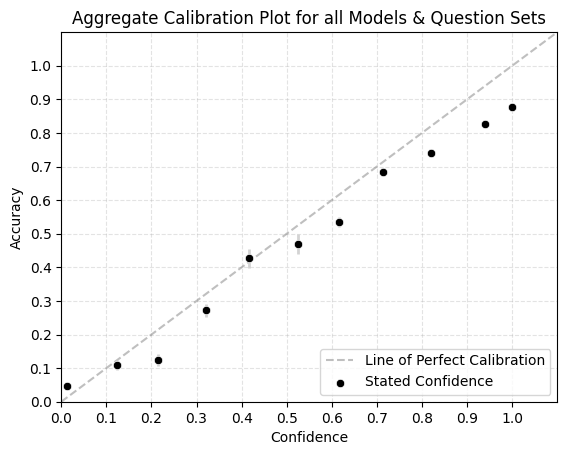

In [ ]:
# First plot is with normal treatment of MCQ  and 2AFC (no expansion)
sc_df = combined_clean[['Model', 'Question Set', 'Stated Confidence Answer', 'Stated Confidence Answer (MCQ)', 'Score']].copy()

sc_df['Stated Confidence Answer'] = pd.to_numeric(sc_df['Stated Confidence Answer'], errors='coerce', ).fillna(0)
sc_df['Stated Confidence Answer (MCQ)'] = pd.to_numeric(sc_df['Stated Confidence Answer (MCQ)'], errors='coerce').fillna(0)
# Combine Stated Confidence Answer and Stated Confidence Answer (MCQ) into one (note: there aren't any overrides as no qset has values in both columns)
sc_df['SC'] = np.maximum(sc_df['Stated Confidence Answer'], sc_df['Stated Confidence Answer (MCQ)']) 
calibration_plot(sc_df, title = 'Aggregate Calibration Plot for all Models & Question Sets')

Multiple Choice Questions ['LSAT-AR', 'SAT-EN', 'SciQ']
    Subset Length: 1254.0
Mean Score for Multiple Choice Questions: 0.2457859662877303
2AFC ['BoolQ', 'HaluEval']
    Subset Length: 4293.0
Probability Estimation ['LifeEval']
    Subset Length: 751.0


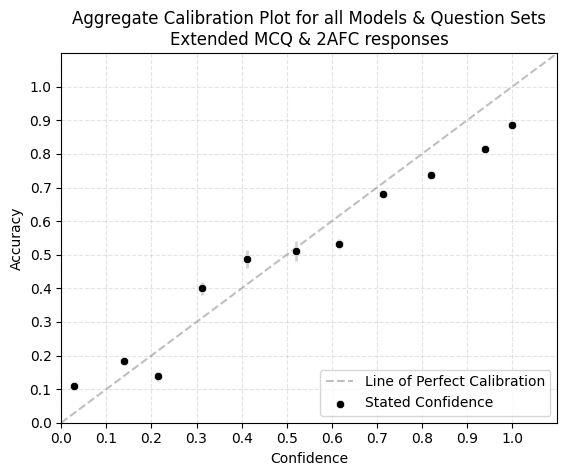

In [146]:
# Extended MCQ

qset_types = {
    "Multiple Choice Questions": ['LSAT-AR', 'SAT-EN', 'SciQ'],
    "2AFC": [ 'BoolQ', 'HaluEval'], # 
    "Probability Estimation": ['LifeEval']
}

agg_score = []
agg_conf = []

sc_data = {}

for qtype, qsets in qset_types.items():
    print(qtype, qsets)
    subset = combined_clean[combined_clean['Question Set'].isin(qsets)]
    print(f"    Subset Length: {len(subset) / 11}")
    title = f"Agregate Performance on {qtype} tasks"

    if qtype == "Multiple Choice Questions":
        scores, conf = expand_mcq(subset)
        print(f"Mean Score for {qtype}: {np.mean(scores)}")
        #print(s.mean(), c.mean())
    elif qtype == "2AFC":
        scores, conf = expand_bool(subset)

    else:
        scores = subset['Score']
        conf = subset['Stated Confidence Answer']

    sc_data[qtype] = {
        "Score": scores,
        "Conf": conf
    }
    agg_score.extend(scores)
    agg_conf.extend(conf)

sc_df = pd.DataFrame({
    "Score": agg_score,
    "SC": agg_conf
})

sc_df['SC'] = sc_df['SC'].astype(float)

calibration_plot(sc_df, title = 'Aggregate Calibration Plot for all Models & Question Sets\nExtended MCQ & 2AFC responses')

**NOTE**: Although this is an agregate plot, we still see that at the $50\%$ confidence levels. Accuracy ranges from below $30\%$ to nearly $70\%$

Multiple Choice Questions ['LSAT-AR', 'SAT-EN', 'SciQ']
    Subset Length: 1254.0
Mean Score for Multiple Choice Questions: 0.2457859662877303
2AFC ['BoolQ', 'HaluEval']
    Subset Length: 4293.0
Probability Estimation ['LifeEval']
    Subset Length: 751.0


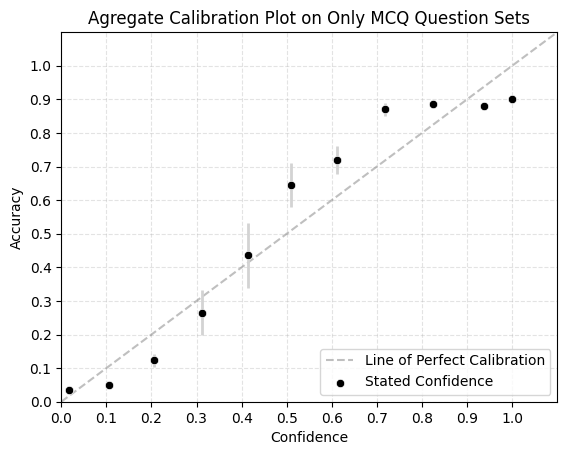

In [147]:
# Lets see only MCQ


# Extended MCQ

qset_types = {
    "Multiple Choice Questions": ['LSAT-AR', 'SAT-EN', 'SciQ'],
    "2AFC": ['BoolQ', 'HaluEval'],
    "Probability Estimation": ['LifeEval']
}

agg_score = []
agg_conf = []

sc_data = {}

for qtype, qsets in qset_types.items():
    print(qtype, qsets)
    subset = combined_clean[combined_clean['Question Set'].isin(qsets)]
    print(f"    Subset Length: {len(subset) / 11}")
    title = f"Agregate Performance on {qtype} tasks"
    if qtype == "Multiple Choice Questions":
        scores, conf = expand_mcq(subset)
        print(f"Mean Score for {qtype}: {np.mean(scores)}")
        #print(s.mean(), c.mean())
    elif qtype == "2AFC":
        continue
        scores, conf = expand_bool(subset)

    else:
        continue
        scores = subset['Score']
        conf = subset['Stated Confidence Answer']

    sc_data[qtype] = {
        "Score": scores,
        "Conf": conf
    }
    agg_score.extend(scores)
    agg_conf.extend(conf)

sc_df = pd.DataFrame({
    "Score": agg_score,
    "SC": agg_conf
})

sc_df['SC'] = sc_df['SC'].astype(float)

calibration_plot(sc_df, title = 'Agregate Calibration Plot on Only MCQ Question Sets')

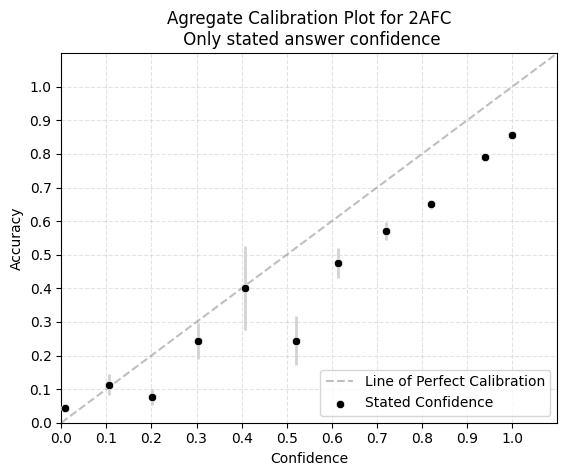

In [148]:
# First plot is with normal treatment of MCQ  and 2AFC (no expansion)
sc_df = combined_clean[combined_clean['Question Set'].isin(['HaluEval', 'BoolQ'])][['Model', 'Question Set', 'Stated Confidence Answer', 'Stated Confidence Answer (MCQ)', 'Score']].copy()


sc_df['Stated Confidence Answer (MCQ)'] = pd.to_numeric(sc_df['Stated Confidence Answer (MCQ)'], errors='coerce').fillna(0)

sc_df['SC'] = sc_df['Stated Confidence Answer']

calibration_plot(sc_df, title = 'Agregate Calibration Plot for 2AFC\n Only stated answer confidence')

### 6 X 11 Calibration Plot

C:\Users\Noam Michael\AppData\Local\Temp\ipykernel_21036\680790606.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sc_df['bin'] = pd.cut(sc_df[conf], bins = bins, right = False)
C:\Users\Noam Michael\AppData\Local\Temp\ipykernel_21036\680790606.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sc_df['bin'] = pd.cut(sc_df[conf], bins = bins, right = False)
C:\Users\Noam Michael\AppData\Local\Temp\ipykernel_21036\680790606.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

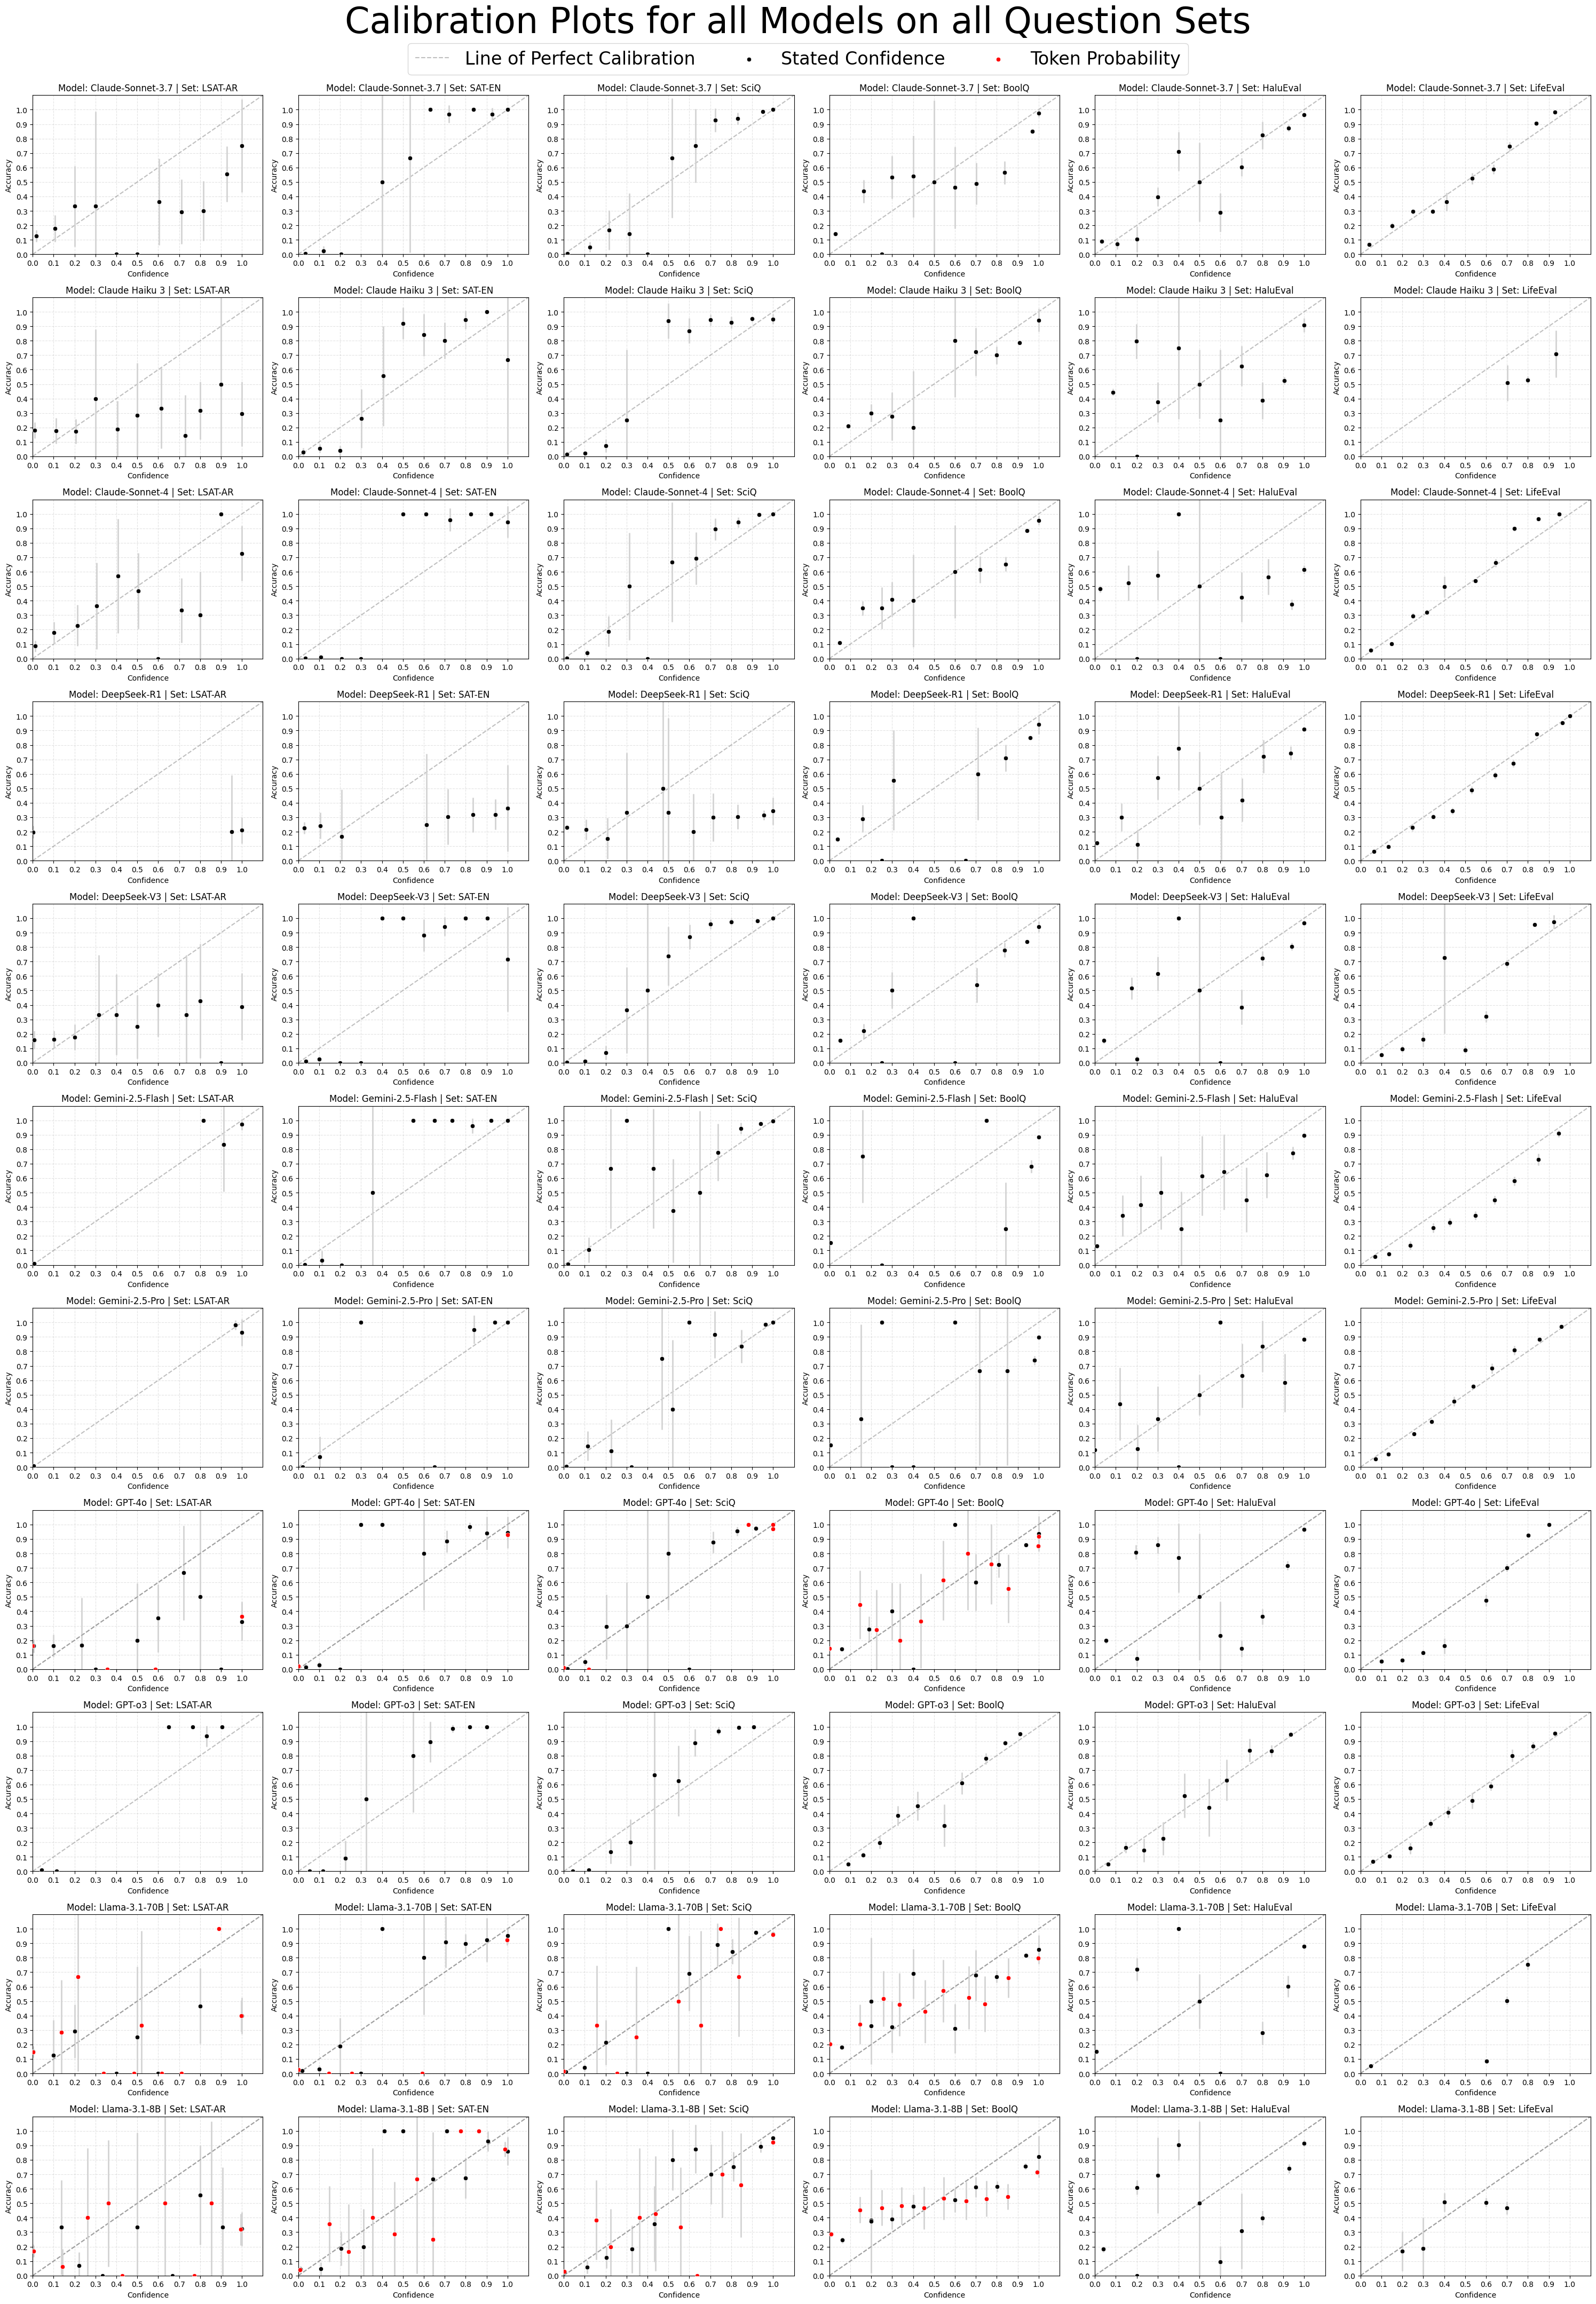

In [149]:
## To Do
# Add in a TP plot when needed
# Add histograms as well


# Expand Stated Confidence for MCQ and 2AFC Qsets
# Extended MCQ

qset_types = {
    "Multiple Choice Questions": ['LSAT-AR', 'SAT-EN', 'SciQ'],
    "2AFC": [ 'BoolQ', 'HaluEval'], # 
    "Probability Estimation": ['LifeEval']
}

has_tokens = combined_clean[(~combined_clean['Token Probability A'].isna())]['Model'].unique()

sc_df = pd.DataFrame()

for model in combined_clean['Model'].unique():
    model_subset = combined_clean[combined_clean['Model'] == model]

    for qtype, qsets in qset_types.items():
        ts = tp = np.nan
        #print(qtype, qsets)
        for qset in qsets:
            #print(f"    {qset}") 
            subset = model_subset[model_subset['Question Set'] == qset]
            #print(f"    Subset Length: {len(subset) / 11}")
            title = f"Agregate Performance on {qtype} tasks"

            if qtype == "Multiple Choice Questions":
                scores, conf = expand_mcq(subset)
                if model in has_tokens:
                    ts, tp = expand_mcq(subset, tokens = True)
                #print(f"        Mean Score for {qtype}: {np.mean(scores)}")
                #print(s.mean(), c.mean())
            elif qtype == "2AFC":
                scores, conf = expand_bool(subset)
                if model in has_tokens:
                    if qset != 'HaluEval':
                        ts, tp = expand_bool(subset, tokens = True)
                    else:
                        ts = tp = [np.nan] * len(scores)

            else:
                scores = subset['Score']
                conf = subset['Stated Confidence Answer']

            baby_df = pd.DataFrame({
                "Score": scores,
                "SC": conf,
                "Token Score": ts,
                "Token Probability": tp,
                "Model": [model] * len(scores),
                "Question Set": [qset] * len(scores),
                "Type":[qtype] * len(scores)
            })


            sc_df = pd.concat([sc_df, baby_df], axis=0, ignore_index=True)

sc_df

sc_df['SC'] = sc_df['SC'].astype(float)

# Get unique values for rows and columns


df = sc_df
models = df['Model'].unique()
question_sets = df['Question Set'].unique()

# Create the grid
fig, axes = plt.subplots(
    nrows=len(models), 
    ncols=len(question_sets), 
    figsize=(len(question_sets) * 5, len(models) * 4), 
    squeeze=False
)

for i, model in enumerate(models):
    for j, q_set in enumerate(question_sets):
        ax = axes[i, j]
        # Filter the data for this specific subplot
        subset = df[(df['Model'] == model) & (df['Question Set'] == q_set)]
        
        # Example: Plotting scores for questions in the set
        if not subset.empty:
            calibration_plot(subset, ax=ax, legend = False)
            if model in has_tokens:
                calibration_plot(subset, conf = 'Token Probability', scores = 'Token Score',  ax=ax, legend = False, color = 'red', label = 'Token Probability')
            ax.set_title(f"Model: {model} | Set: {q_set}")
        else:
            ax.set_title(f"No data for {model} - {q_set}")


# Make a main legend

all_handles = {}

# Iterate through every subplot in the grid
for row in axes:
    for ax in row:
        handles, labels = ax.get_legend_handles_labels()
        # Zip them and add to dictionary (overwrites duplicates)
        for handle, label in zip(handles, labels):
            if label not in all_handles:
                all_handles[label] = handle

# Extract the unique lists
unique_labels = list(all_handles.keys())
unique_handles = list(all_handles.values())

fig.tight_layout(rect=[0, 0, 1, 0.95]) 

# 4. POSITION TITLE: Use y to nudge it down closer to the legend
fig.suptitle('Calibration Plots for all Models on all Question Sets', fontsize=48, y=0.98)

# 5. POSITION LEGEND: Use bbox_to_anchor to place it right under the title
fig.legend(
    unique_handles, 
    unique_labels, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 0.9675), # Nudges it just below the suptitle
    ncol=3, 
    frameon=True,
    prop={'size': 24}

)

plt.show()

In [150]:
sc_df

Score    SC  Token Score  Token Probability              Model  \
0       0.000000  0.00          NaN                NaN  Claude-Sonnet-3.7   
1       0.000000  0.00          NaN                NaN  Claude-Sonnet-3.7   
2       1.000000  0.95          NaN                NaN  Claude-Sonnet-3.7   
3       0.000000  0.05          NaN                NaN  Claude-Sonnet-3.7   
4       0.000000  0.00          NaN                NaN  Claude-Sonnet-3.7   
...          ...   ...          ...                ...                ...   
158824  1.000000  0.60          NaN                NaN       Llama-3.1-8B   
158825  0.268128  0.70          NaN                NaN       Llama-3.1-8B   
158826  0.998065  0.60          NaN                NaN       Llama-3.1-8B   
158827  0.999996  0.60          NaN                NaN       Llama-3.1-8B   
158828  1.000000  0.70          NaN                NaN       Llama-3.1-8B   

       Question Set                       Type  
0           LSAT-AR  Multiple Choice Questions  
1           LSAT-AR  Multiple Choice Questions  
2           LSAT-AR  Multiple Choice Questions  
3           LSAT-AR  Multiple Choice Questions  
4           LSAT-AR  Multiple Choice Questions  
...             ...                        ...  
158824     LifeEval     Probability Estimation  
158825     LifeEval     Probability Estimation  
158826     LifeEval     Probability Estimation  
158827     LifeEval     Probability Estimation  
158828     LifeEval     Probability Estimation  

[158829 rows x 7 columns]

### Stated Confidence V. Token Probability

In [151]:
def expand_mcq_tokens(data):
    """
    This function takes in a dataframe `data` and returns a dataframe which extracts the token / stated confidence values for each option
    The way it's written is pretty inefficient but I wanted clean readable code for debugging.
    """
    df = data.copy()
    sc_list = []
    tp_list = []
    qid_list = []
    qset_list = []
    model_list = []

    kind = ['Multiple Choice Question'] * len(df)

    for index, row in df.iterrows():
        qid = row['Question ID']
        qset = row['Question Set']
        model = row['Model']

        sc_a = row['Stated Confidence A']
        sc_b = row['Stated Confidence B']
        sc_c = row['Stated Confidence C']
        sc_d = row['Stated Confidence D']
        sc_e = row['Stated Confidence E']

        tp_a = row['Token Probability A']
        tp_b = row['Token Probability B']
        tp_c = row['Token Probability C']
        tp_d = row['Token Probability D']
        tp_e = row['Token Probability E']

        if qset == 'LSAT-AR': #only returns True for LSAT-AR
            sc = [sc_a, sc_b, sc_c, sc_d, sc_e]
            tp = [tp_a, tp_b, tp_c, tp_d, tp_e]
        else:
            sc = [sc_a, sc_b, sc_c, sc_d]
            tp = [tp_a, tp_b, tp_c, tp_d]
        
        mini_qid_list = [qid] * len(sc)
        mini_qset_list = [qset] * len(sc)
        mini_model_list = [model] * len(sc)

        sc_list.extend(sc)
        tp_list.extend(tp)
        qid_list.extend(mini_qid_list)
        qset_list.extend(mini_qset_list)
        model_list.extend(mini_model_list)




    kind_list = ['Multiple Choice Questions'] * len(sc_list)

    return pd.DataFrame({
    "Stated Confidence": sc_list,
    "Token Probability": tp_list,
    "Kind": kind_list,
    "Question Set": qset_list,
    "Question ID": qid_list,
    "Model": model_list
    }).dropna(axis = 0)



In [152]:
# sc_agg = []
# tp_agg = []
# kind_agg = []
# qid_agg = []
# qset_agg = []
# model_agg = []


# # For BoolQ we will have to the column for the chosen answer

# for qset in all_qset_names:
#     subset = only_tokens[only_tokens['Question Set'] == qset]

#     if qset == 'BoolQ':
#         # Get the stated confidence
#         sc = subset['Stated Confidence Answer'] 
#         # Get the token prob for either True/ False depending on the answer.
#         # As a note, although we collect both True/ False probability it would be an unfair 
#         # comparison in this case to assert that its confidence in True when the response was False would be
#         # 1 - C(False). Therefore, I am only looking at the stated answer. This is not the case for all Qsets
#         tp = subset.apply(lambda x: x[f"Token Probability {x['Answer']}"], axis =1)
#         kind = ['2AFC'] * len(tp)
#         model = subset['Model']
#         qids = subset['Question ID']

#     elif qset == 'HaluEval':
#         continue # We don't do any analysis for HaluEval
#     elif qset == 'LifeEval':
#         sc = subset['Stated Confidence Answer'] 
#         tp = subset['Token Probability Answer']
#         kind = ['Probability Estimation'] * len(tp)
#         qids = subset['Question ID']
#         model = subset['Model']
#     elif qset in mcq_qsets:
#         #tp = subset['Stated Confidence Answer']
#         #continue
#         #s, sc = expand_mcq(subset)
#         mcq_df = expand_mcq_tokens(subset)
#         #Stated Confidence	Token Probability	Kind	Question Set	Question ID
#         sc = mcq_df['Stated Confidence'].tolist()
#         tp = mcq_df['Token Probability'].tolist()
#         kind = mcq_df['Kind'].tolist()
#         qset_list = mcq_df['Question Set'].tolist()
#         qids = mcq_df['Question ID'].tolist()
#         model = mcq_df['Model'].tolist()


#         kind = ['Multiple Choice Questions'] * len(tp)
        
#         #display(subset.head(3))

#     qset_list = [qset] * len(tp)
#     sc_agg.extend(sc)
#     tp_agg.extend(tp)
#     kind_agg.extend(kind)
#     qset_agg.extend(qset_list)
#     qid_agg.extend(qids)
#     model_agg.extend(model)
#     #print(f"{qset}: {len(sc)} {len(tp)} {len(kind)} {len(qset_list)} {len(qids)}") # Print statement for debugging


# jp = pd.DataFrame({
#     "Stated Confidence": sc_agg,
#     "Token Probability": tp_agg,
#     "Kind": kind_agg,
#     "Question Set": qset_agg,
#     "Question ID": qid_agg,
#     "Model": model_agg
#     })



# jp

#### Scatter Plot:

In [153]:

# ## Scatter Plot by Qset type:
# g =sns.jointplot(jp, x='Stated Confidence', y='Token Probability', kind = 'scatter', alpha = 0.1, hue = 'Kind' )

# # Combined Scatter Plot with Regresssion Line 
# #g =sns.jointplot(jp, x='Stated Confidence', y='Token Probability', kind = 'reg')

# # 2. Get the legend handles and labels *from* the joint axis
# handles, labels = g.ax_joint.get_legend_handles_labels()

# # 3. Remove the original, in-plot legend
# g.ax_joint.get_legend().remove()


# # 4. Add a *new* legend to the main figure
# g.figure.legend(handles=handles, 
#              labels=labels, 
#              loc='upper left', 
#              bbox_to_anchor=(1, 1)) # Places it outside

# # 5. (The finicky part) Adjust the figure layout to make space
# # You will have to tinker with 'right' until it looks good.
# g.figure.subplots_adjust(right=1)


#### KDE Plot:

In [154]:
# # KDE Plot:
# for qset_type in jp['Kind'].unique():
#     mini_jp = jp[jp['Kind'] == qset_type]
#     #kind: Literal['scatter', 'kde', 'hist', 'hex', 'reg', 'resid']
#     ax = sns.jointplot(mini_jp, 
#                 x='Stated Confidence', 
#                 y='Token Probability', 
#                 kind='hist',
#                 marginal_kws = {'log_scale': False}
#                 #hue='Kind',
#                 )



#     ax.figure.suptitle(f"Stated Confidence v. Token Probability on {qset_type} Tasks", y=1.02)
#     plt.grid(True) 
#     plt.show()

#     # 3. Remove the original, in-plot legend
#     #g.ax_joint.get_legend().remove()

#     # # 4. Add a *new* legend to the main figure
#     # g.figure.legend(handles=handles, 
#     #             labels=labels, 
#     #             loc='upper left', 
#     #             bbox_to_anchor=(1, 1)) # Places it outside

#     # 5. (The finicky part) Adjust the figure layout to make space
#     # You will have to tinker with 'right' until it looks good.
#     #g.figure.subplots_adjust(right=1)

**Observations**:

* __BoolQ__:
    * For BoolQ, we see that there are some instances where the model described less than 50% confidence (44 instances) these are all by Llama.

#### Investigating the lower right corner of SC v. TP plot

In [155]:
# jp[
#     (jp['Stated Confidence'] >= 0.99)  &
#     (jp['Token Probability'] <= 0.05)
# ]

In [156]:
# bad = only_tokens[
#     (only_tokens['Question ID'] == '73') &  
#     (only_tokens['Question Set'] == 'LSAT-AR')  ]

# content_str = bad.iloc[2]['Content']
# print(content_str)

# Additional Analysis

In [157]:
combined_clean['Stated Confidence Answer (MCQ)'] = combined_clean['Stated Confidence Answer (MCQ)'].astype(float)


res = combined_clean[(combined_clean['Model'] == 'GPT-o3') & 
                     (combined_clean['Question Set'] == 'SAT-EN')].sort_values('Stated Confidence Answer (MCQ)' )['Content'] #(combined_clean['Stated Confidence Answer (MCQ)'] <= 0.5)

print(res.iloc[0])


{
"Reasoning": "If collisions inside the asteroid belt alone destroyed most differentiated bodies, rocks no stronger than primitive asteroids should have been pulverized as well. Thus scientists would expect the belt to contain far fewer surviving primitive asteroids than are actually observed; their surprising abundance is the very fact that shows collisions are not the whole story.",
"Answer": "B",
"A": 0.3,
"B": 0.55,
"C": 0.05,
"D": 0.10
}


## Average Confidence and Accuracy


In [212]:
no_he = combined_clean[combined_clean['Question Set'] != "HaluEval"]
no_he = no_he[["Score", "Stated Confidence Answer", "Stated Confidence Answer (MCQ)"]].astype(float).fillna(0)
no_he['SC'] = np.maximum(no_he['Stated Confidence Answer'], no_he['Stated Confidence Answer (MCQ)'])

w_he = combined_clean[["Score", "Stated Confidence Answer", "Stated Confidence Answer (MCQ)"]].astype(float).fillna(0)
w_he['SC'] = np.maximum(w_he['Stated Confidence Answer'], w_he['Stated Confidence Answer (MCQ)'])

w_he[['Score', 'SC']].astype(float).mean()

Score    0.723568
SC       0.813338
dtype: float64

In [216]:
he = combined_clean[combined_clean["Question Set"] == "HaluEval"]

he['Content'].iloc[5]

'{\n    "Confidence": "0.0"\n}'

# LifeEval Analysis

## Difficulty by QID

In [158]:
qid_to_rads(pd.Series([15]))[0]

np.int64(20)

In [159]:
act = pd.read_csv(r"Formatted Benchmarks\PeriodLifeTable_2022_RawData.csv")
act

results = {}

for qid in range(808):
    min_age = get_age(qid)
    gender = 'Male' if qid < 404 else 'Female'
    rad = qid_to_rads(pd.Series([qid]))[0]

    best_age = min_age
    best_prob = compute_prob(min_age, R = rad, gender= gender, min_age = min_age, df = act)

    for test_age in range(min_age, 110):
        ap = compute_prob(test_age, R = rad, gender= gender, min_age = min_age, df = act)

        if ap > best_prob:
            best_age = test_age
            best_prob = ap

    results[qid]= {
        "Min Age": min_age,
        "Radius": rad,
        "Best Age": best_age,
        "Highest Probability": best_prob
    }



In [160]:
compute_prob(109, R = 5, gender= 'Male', min_age = 0, df = act)

0.0007661780755859875

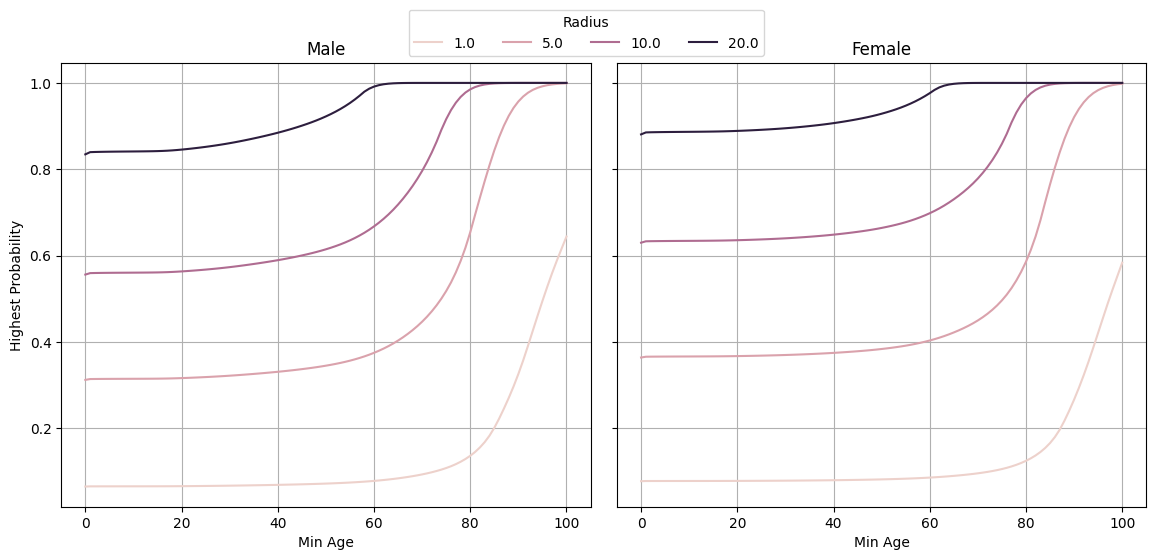

In [161]:
best_df =  pd.DataFrame.from_dict(results, orient='index')
best_df = best_df.reset_index(names = 'Question ID').astype(float)

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Add the main super-title
#plt.suptitle("Highest Achievable Probability Given a Minimum Age and Radius")

groups = ['Male', 'Female']

# Iterate through the groups and the corresponding axes
for g, ax in zip(groups, axes):

    if g == "Male":
        only_1 = best_df[best_df['Question ID'] < 404]
    else:
        only_1 = best_df[best_df['Question ID'] >= 404]

    ax = sns.lineplot(only_1, x = 'Min Age', y = 'Highest Probability', hue = 'Radius', ax = ax)
    ax.set_title(g)
    ax.grid(True)


# --- NEW LEGEND LOGIC ---

# 2. Extract handles and labels from the first subplot (axes[0])
handles, labels = axes[0].get_legend_handles_labels()

# 3. Clear the individual legends from the subplots so they don't show up twice
for ax in axes:
    ax.get_legend().remove()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=4, title='Radius')

# 5. Adjust the top margin so the subplots move down and don't overlap the new legend
plt.subplots_adjust(top=0.85, wspace = 0.05)

plt.show()

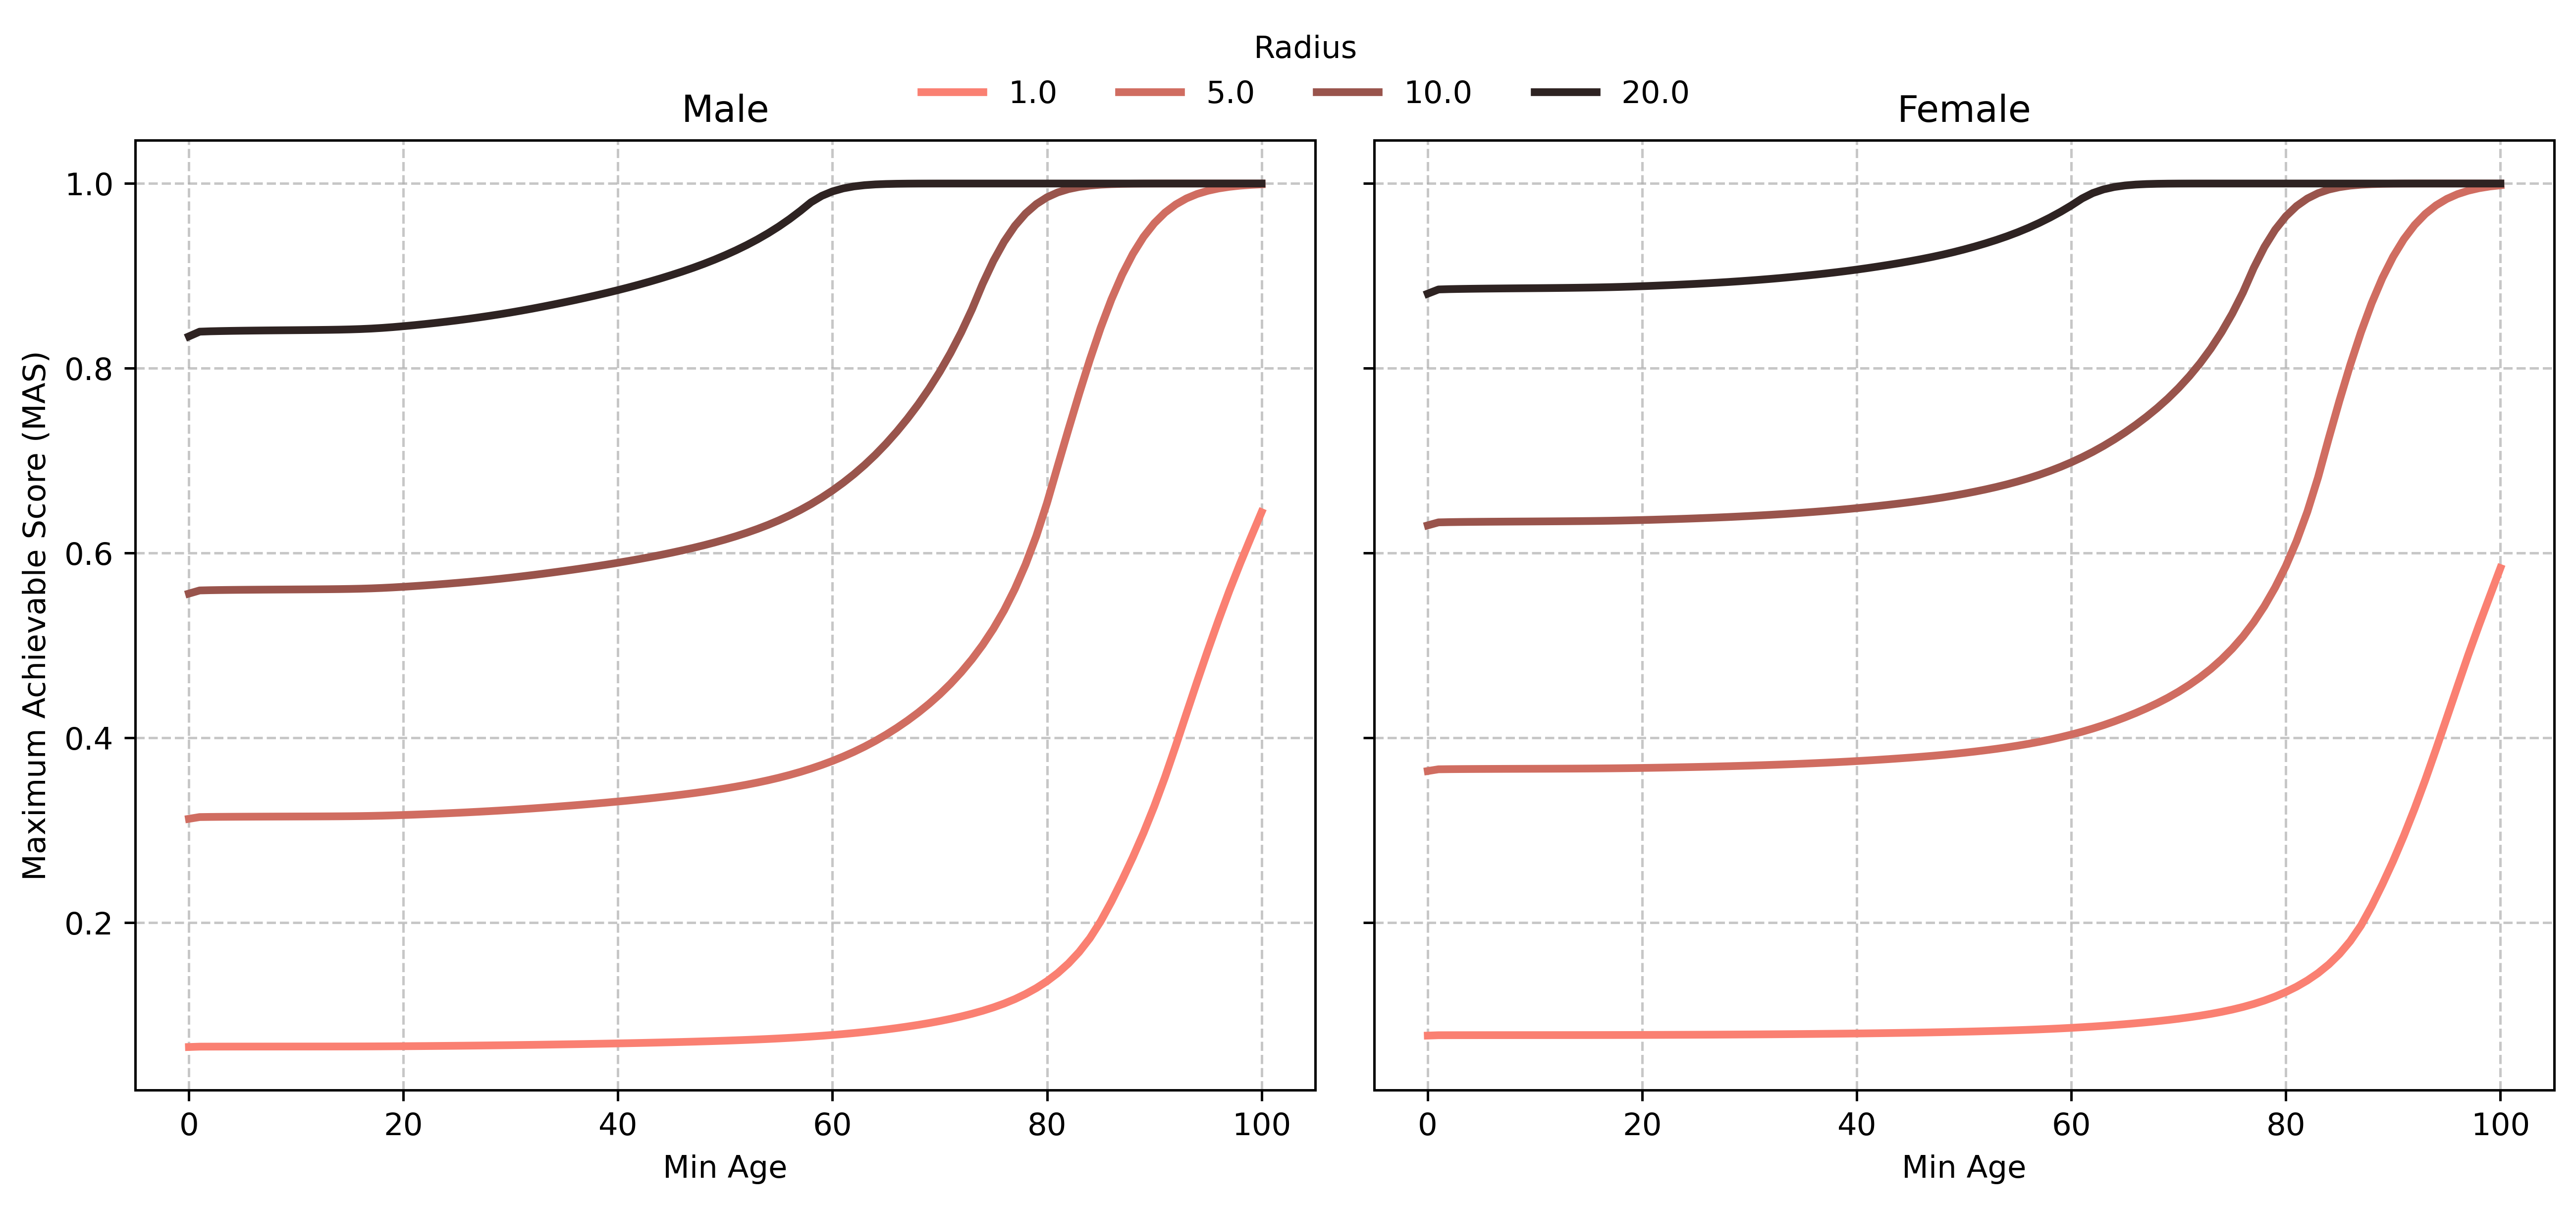

In [344]:
# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True, dpi = 450)

# Add the main super-title
#plt.suptitle("Highest Achievable Probability Given a Minimum Age and Radius", fontsize=16)

groups = ['Male', 'Female']

# Iterate through the groups and the corresponding axes
for g, ax in zip(groups, axes):

    if g == "Male":
        only_1 = best_df[best_df['Question ID'] < 404]
    else:
        only_1 = best_df[best_df['Question ID'] >= 404]

    # Updated with palette='dark' and linewidth=2.5
    sns.lineplot(data=only_1, x='Min Age', y='Highest Probability', 
                 hue='Radius', ax=ax, palette='dark:salmon_r', linewidth=2.5)
    
    ax.set_title(g)
    ax.set_ylabel("Maximum Achievable Score (MAS)")
    ax.grid(True, linestyle='--', alpha=0.7)

# --- NEW LEGEND LOGIC ---

# Extract handles and labels from the first subplot
handles, labels = axes[0].get_legend_handles_labels()

# Clear the individual legends from the subplots
for ax in axes:
    leg = ax.get_legend()
    if leg:
        leg.remove()

# Add the combined legend
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.92), 
           ncol=4, title='Radius', frameon=False)

# Adjust margins
plt.subplots_adjust(top=0.82, wspace=0.05)

plt.show()

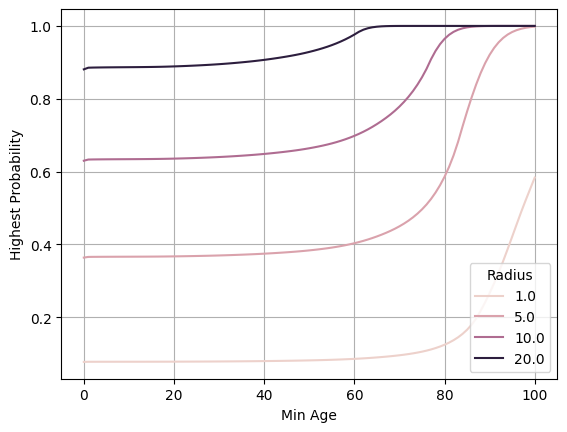

In [60]:
best_df[best_df['Question ID'] < 404]
ax =sns.lineplot(only_1, x = 'Min Age', y = 'Highest Probability', hue = 'Radius')
ax.grid(True)
ax.legend(loc = "lower right", title = 'Radius')

**NOTE** Include in supplement

In [61]:
life_eval = combined_clean[combined_clean['Question Set'] == 'LifeEval']
life_eval['Question ID'] = life_eval['Question ID'].astype(float)
life_eval['Stated Confidence Answer'] =life_eval['Stated Confidence Answer'].astype(float)
life_eval.head()

life_eval = life_eval.join(best_df, on= 'Question ID', rsuffix = '_act', lsuffix= '_orig')


C:\Users\Noam Michael\AppData\Local\Temp\ipykernel_21036\825386054.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  life_eval['Question ID'] = life_eval['Question ID'].astype(float)
C:\Users\Noam Michael\AppData\Local\Temp\ipykernel_21036\825386054.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  life_eval['Stated Confidence Answer'] =life_eval['Stated Confidence Answer'].astype(float)


**Lineplot**

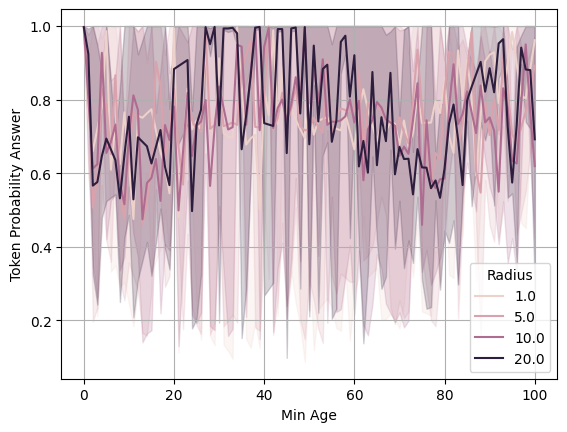

In [62]:
small_le = life_eval[['Question ID', 'Min Age', 'Radius', 'Stated Confidence Answer', 'Token Probability Answer', 'Highest Probability']].copy()
small_le

only_male  = small_le[small_le['Question ID'] <= 404]

sns.lineplot(only_male, x = 'Min Age', y = 'Token Probability Answer', hue = 'Radius')
plt.grid(True)
#plt.ylim(0, 120)
plt.show()


**Scatterplot**

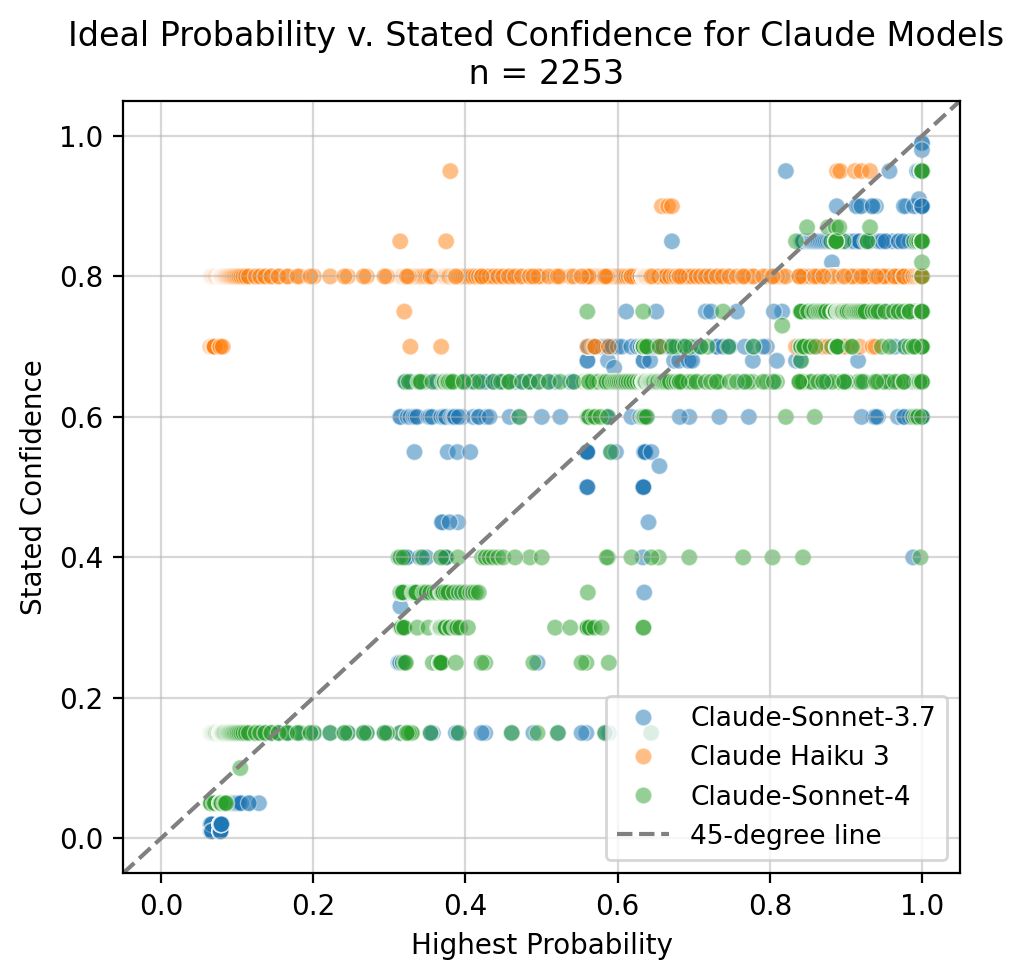

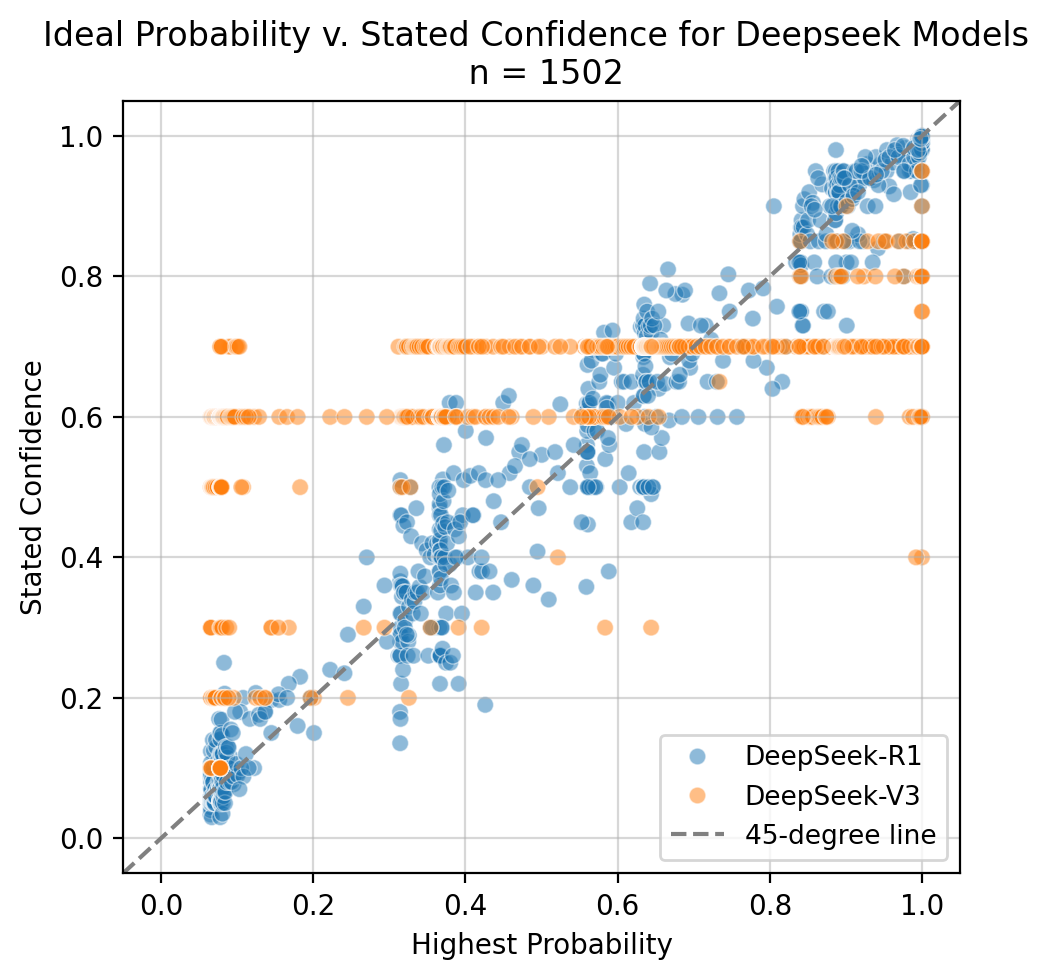

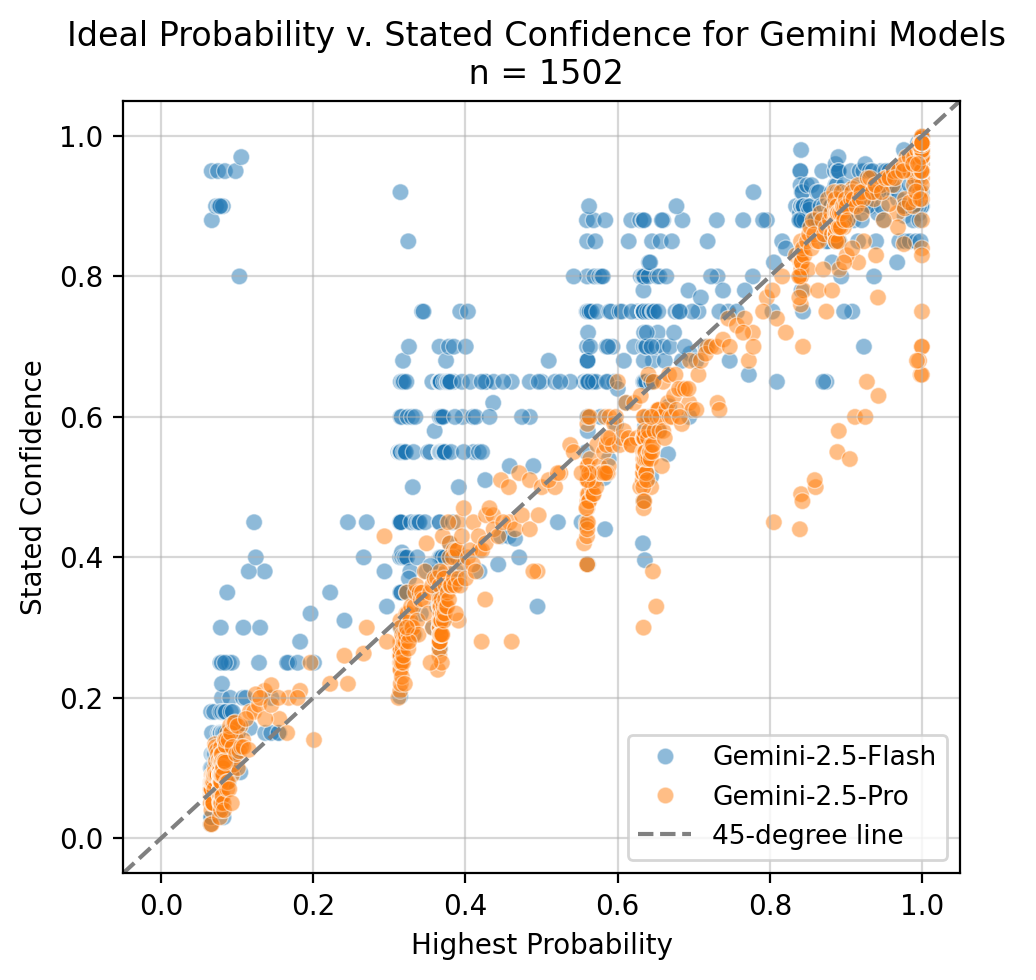

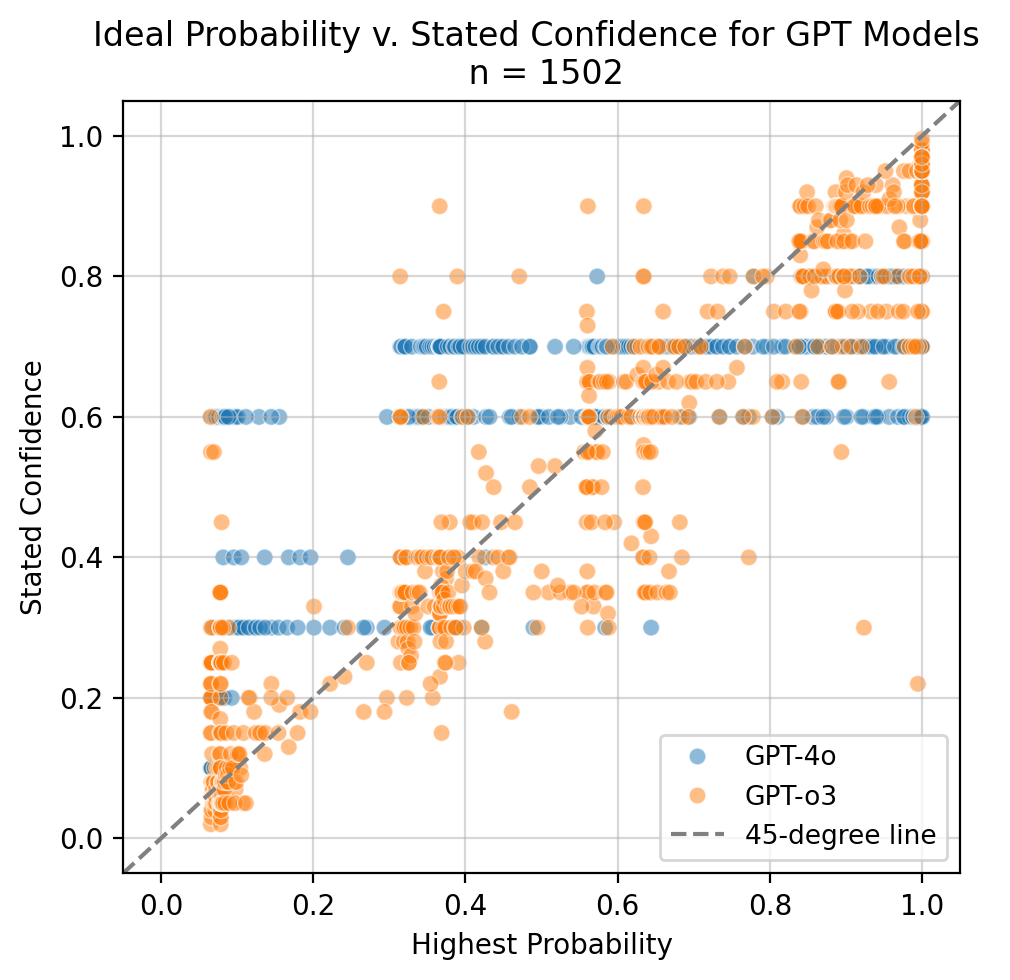

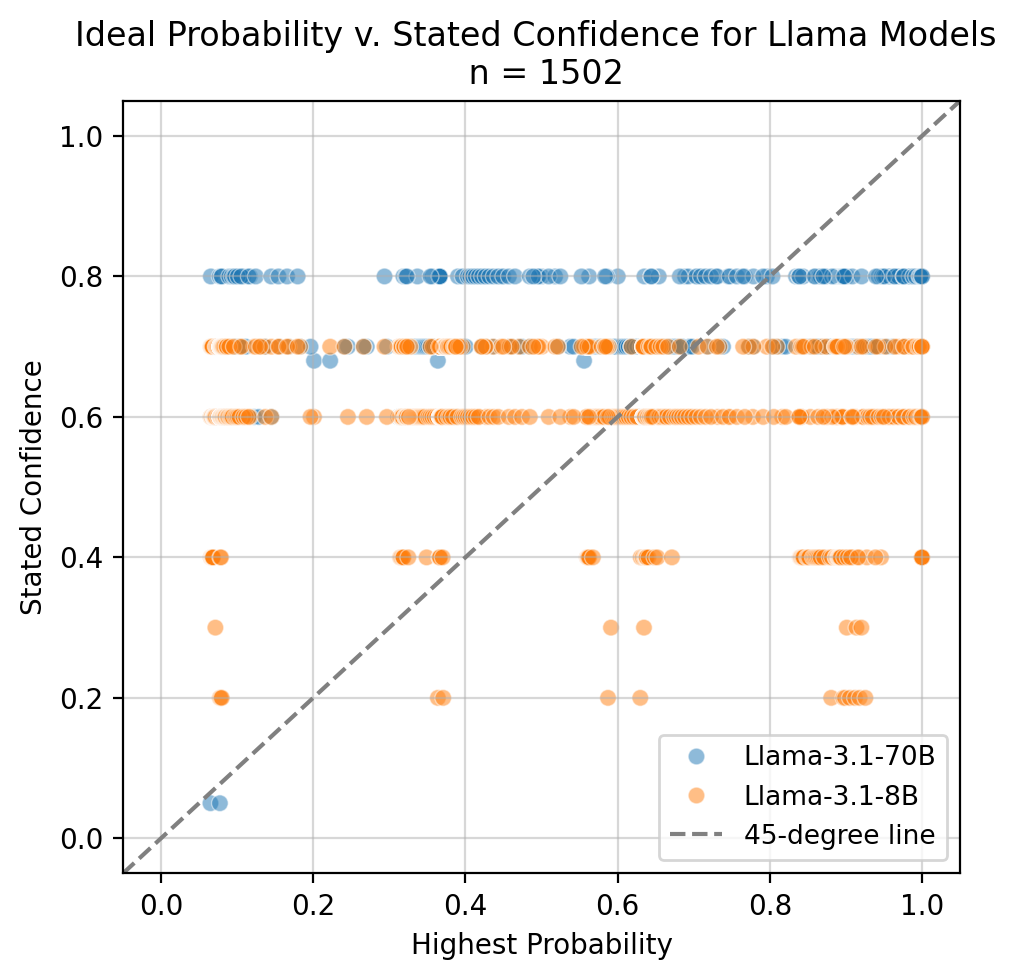

In [63]:
from scipy import stats


def compute_entropy(s): ## TODO 
    def exp_log(x):
        return -x * np.log(x)
    
    freq = s.value_counts(normalize = True)
    
    return freq.apply(exp_log).sum()

is_reasoning = ['DeepSeek-R1', 'Gemini-2.5-Pro', 'GPT-o3']



for model_type in life_eval['Model Type'].unique():
    plt.figure(figsize=(5,5), dpi =200)
    mini = life_eval[life_eval['Model Type'] == model_type]
    for model in mini['Model'].unique():
        super_mini = mini[mini['Model'] == model]

    ax  = sns.scatterplot(mini, x = 'Highest Probability', y ='Stated Confidence Answer', hue = 'Model', alpha = 0.5, )
    plt.ylabel('Stated Confidence')
    plt.title(f"Ideal Probability v. Stated Confidence for {model_type} Models \n n = {len(mini)}")
    plt.grid(True, alpha = 0.5,)
    ax.axline([0, 0], [1, 1], color='grey', linestyle='--', label='45-degree line')

    ax.legend(loc='lower right', fontsize=9.5)


    # Use tight_layout() to make room for the legend
    plt.tight_layout()

    plt.show()


In [64]:
%pip install scipy

Note: you may need to restart the kernel to use updated packages.


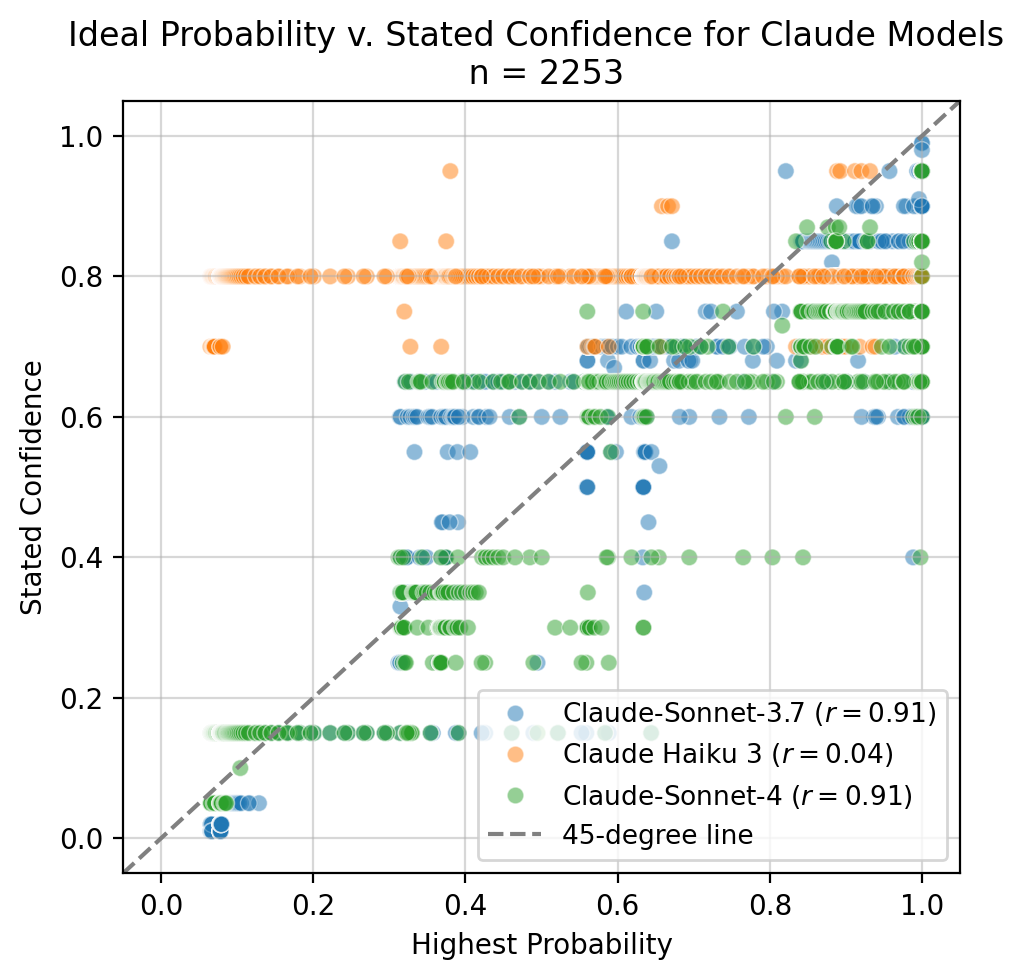

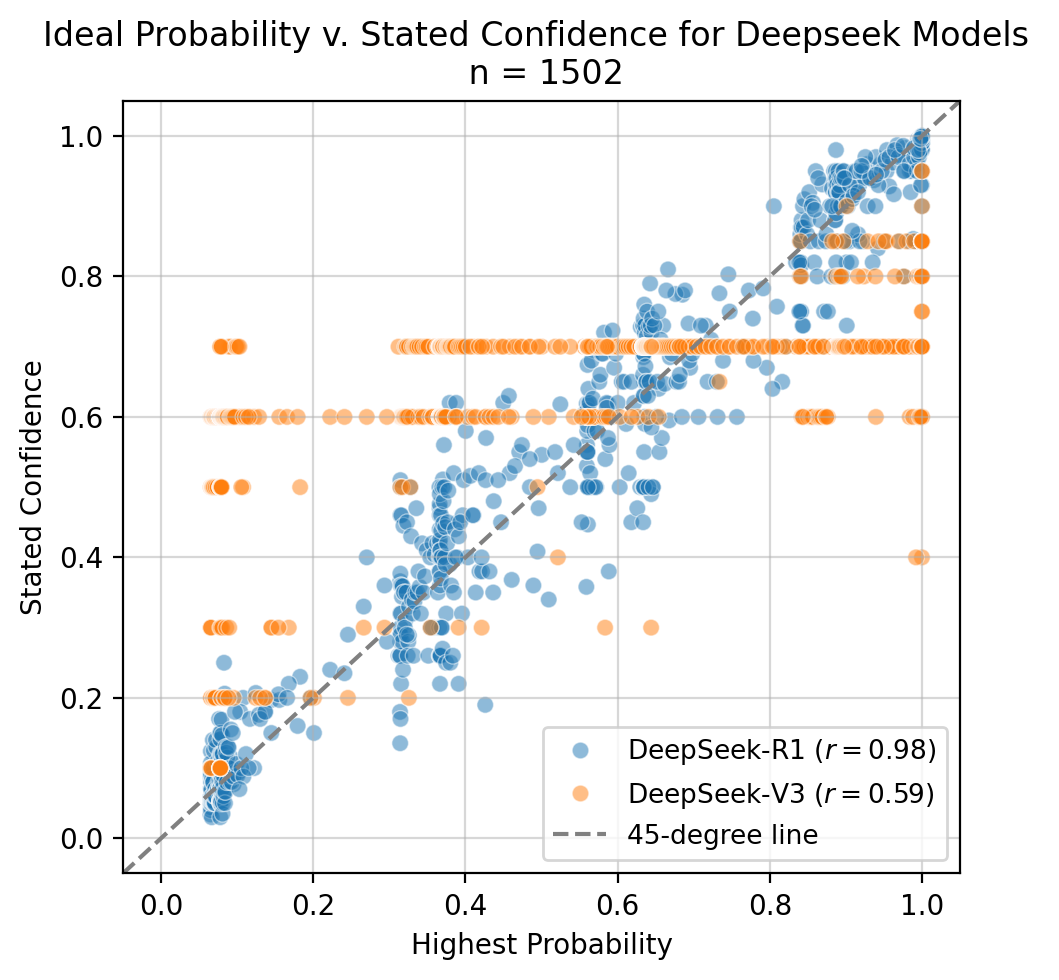

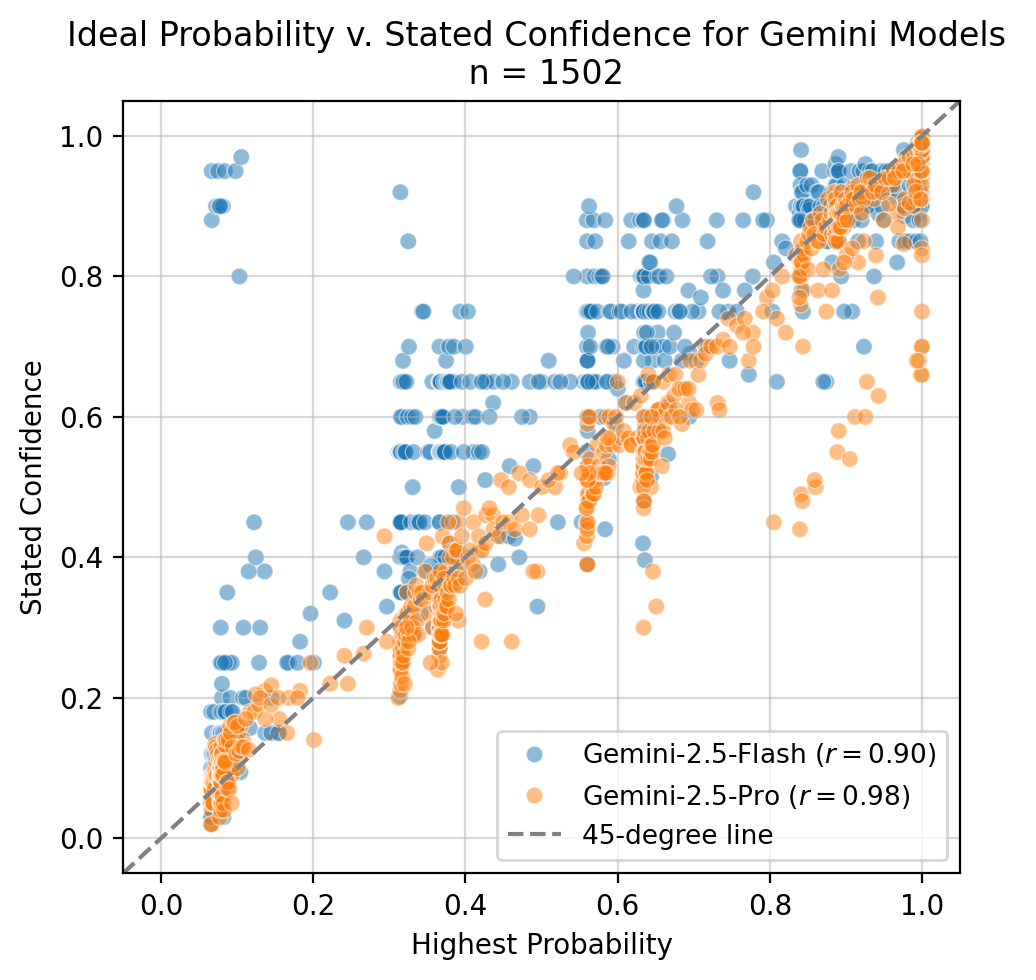

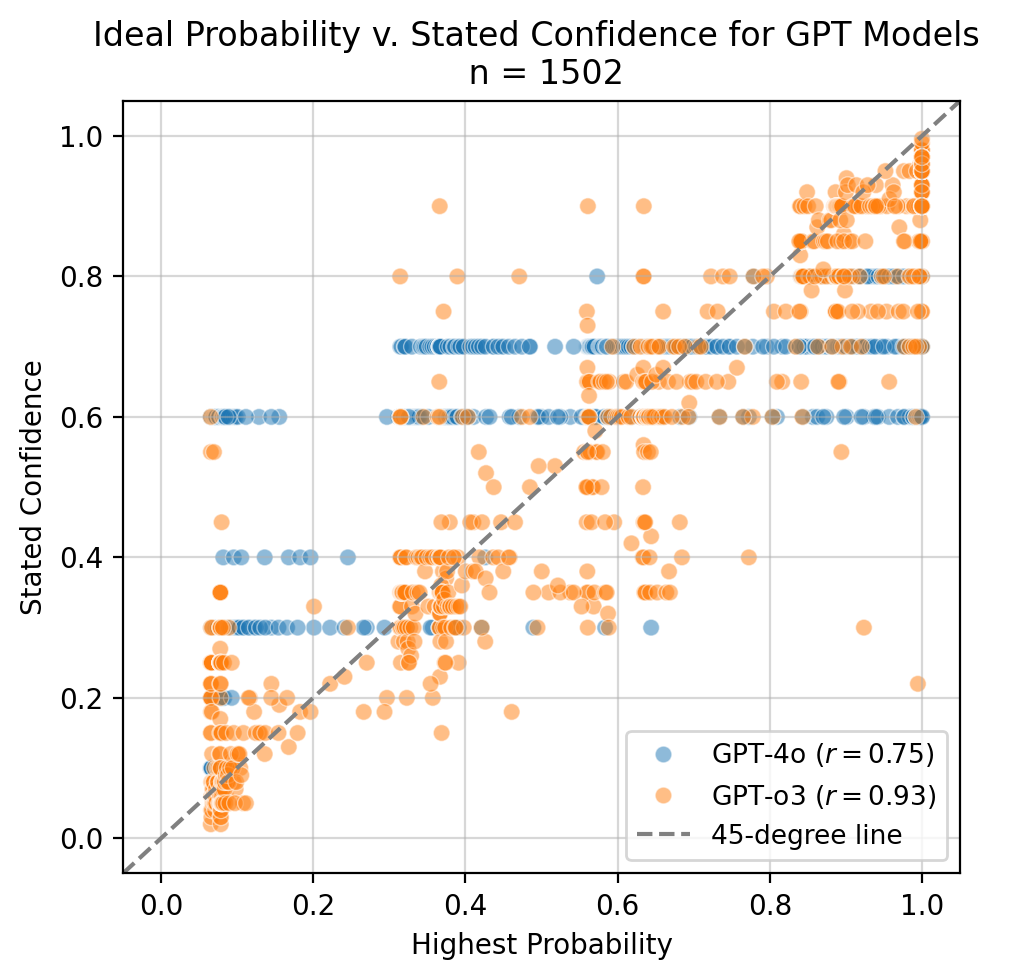

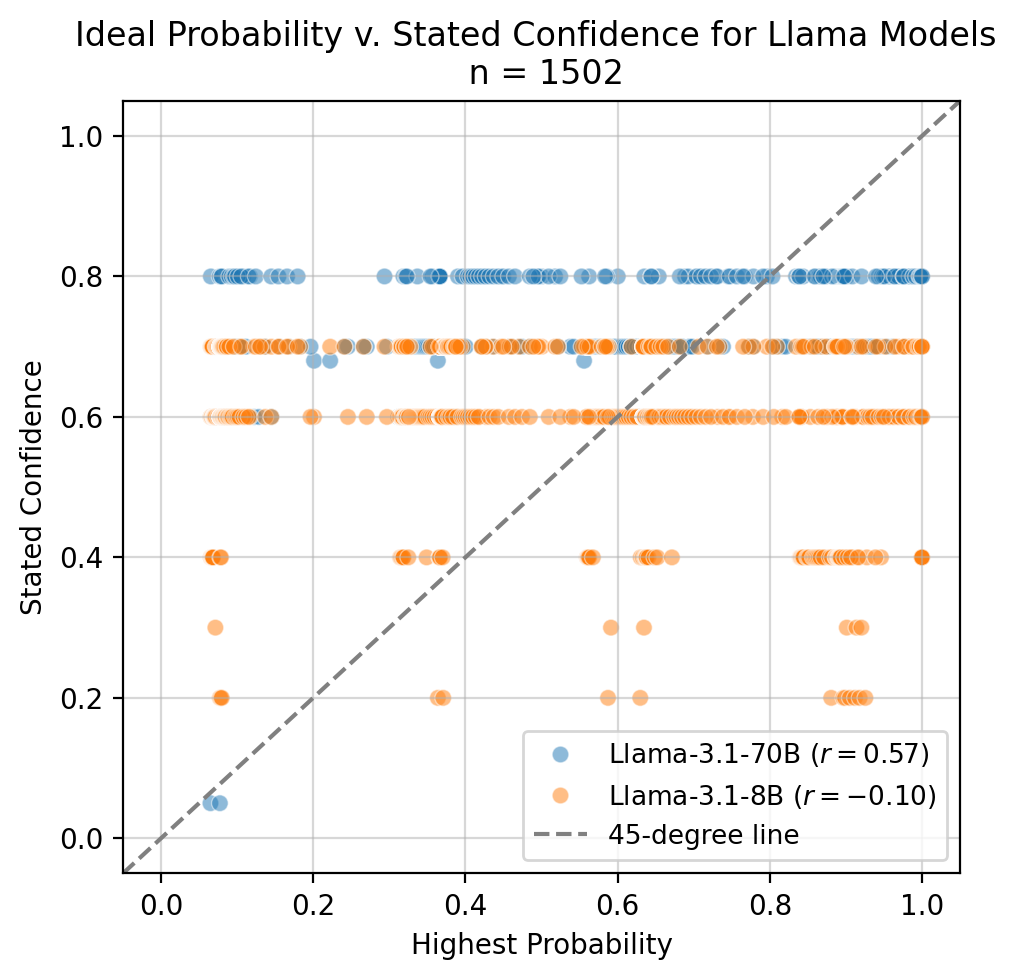

In [65]:
for model_type in life_eval['Model Type'].unique():
    plt.figure(figsize=(5, 5), dpi=200)
    mini = life_eval[life_eval['Model Type'] == model_type]
    
    # Create the scatterplot
    ax = sns.scatterplot(
        data=mini, 
        x='Highest Probability', 
        y='Stated Confidence Answer', 
        hue='Model', 
        alpha=0.5
    )
    
    # Add the 45-degree reference line
    # We add it before getting handles so it appears in the list if we want it to,
    # though seaborn often manages the hue legend separately.
    line_45 = ax.axline([0, 0], [1, 1], color='grey', linestyle='--', label='45-degree line')

    # --- Logic to update Legend Labels with Pearson r ---
    
    # Get current handles and labels from the plot
    # This usually captures the hue categories (Models) and potentially the axline
    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    
    for label in labels:
        # Check if the label matches a model in our current subset
        if label in mini['Model'].unique():
            # Filter data specifically for this model to calculate r
            model_subset = mini[mini['Model'] == label]
            
            # Drop NaNs to ensure stats.pearsonr works correctly
            valid_data = model_subset[['Highest Probability', 'Stated Confidence Answer']].dropna()
            
            if len(valid_data) > 1:
                r, p_val = stats.pearsonr(valid_data['Highest Probability'], valid_data['Stated Confidence Answer'])
                new_labels.append(f"{label} ($r={r:.2f}$)")
            else:
                new_labels.append(label)
        else:
            # Preserve titles or other labels (like 'Model' or '45-degree line')
            new_labels.append(label)

    # Ensure the 45-degree line is in the legend if not picked up automatically
    # (Seaborn sometimes separates hue legends from manual plot additions)
    if '45-degree line' not in labels:
        handles.append(line_45)
        new_labels.append('45-degree line')

    # Re-apply the legend with updated labels
    ax.legend(handles=handles, labels=new_labels, loc='lower right', fontsize=9.5)

    # Final Plot Formatting
    plt.ylabel('Stated Confidence')
    plt.title(f"Ideal Probability v. Stated Confidence for {model_type} Models \n n = {len(mini)}")
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.show()

## LifeEval Calibration Plot

Since LifeEval gives us the empirical probability of each question we can compare the stated confidence to the true probability:

Claude-Sonnet-3.7 error: 0.0982336745600385
Claude Haiku 3 error: 0.357109465279627
Claude-Sonnet-4 error: 0.12782637018930237


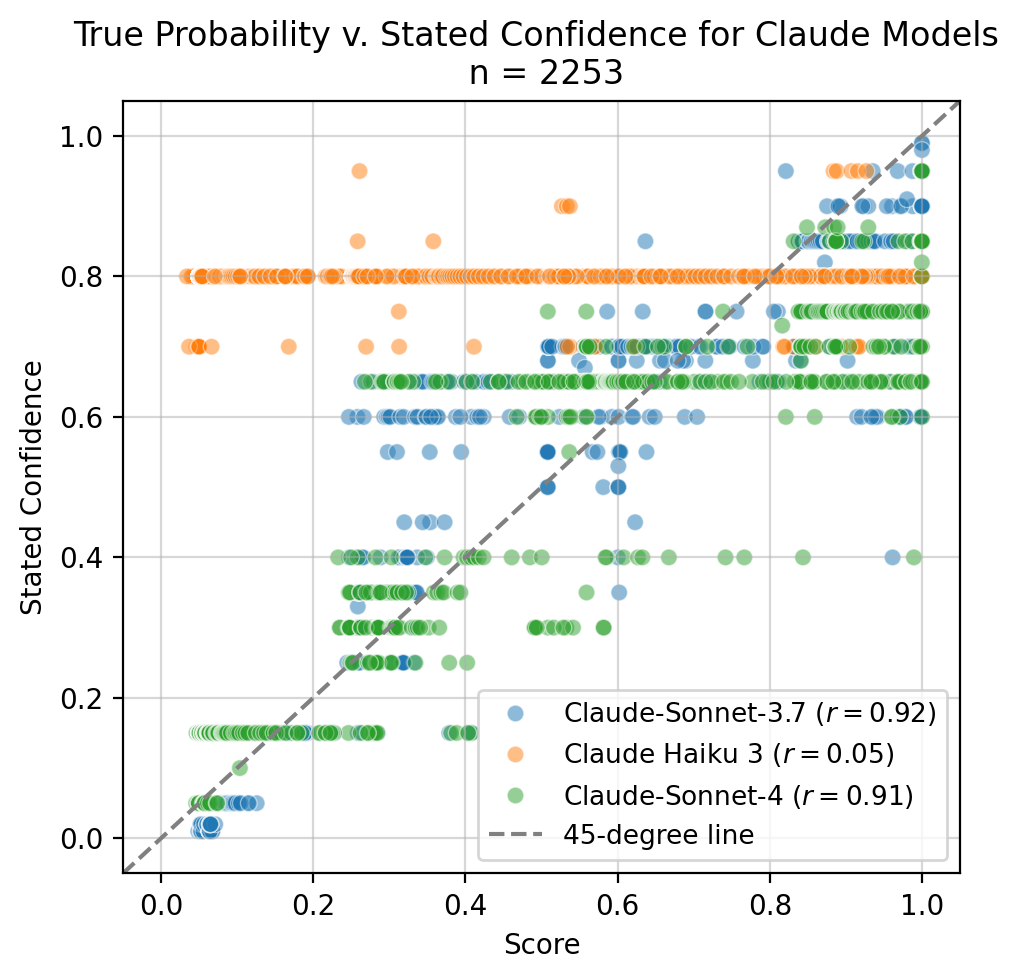

DeepSeek-R1 error: 0.052742876164598114
DeepSeek-V3 error: 0.2657388043234596


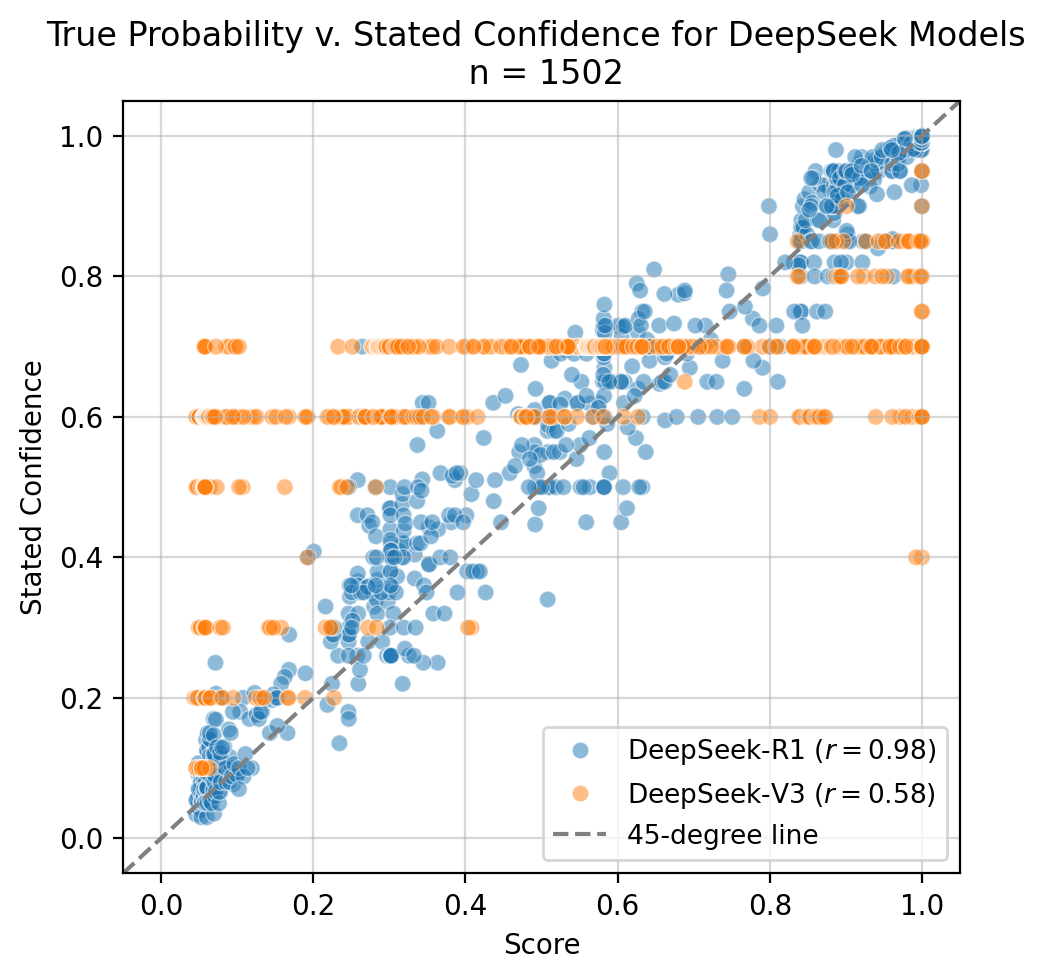

Gemini-2.5-Flash error: 0.11754710844440652
Gemini-2.5-Pro error: 0.0395875017113992


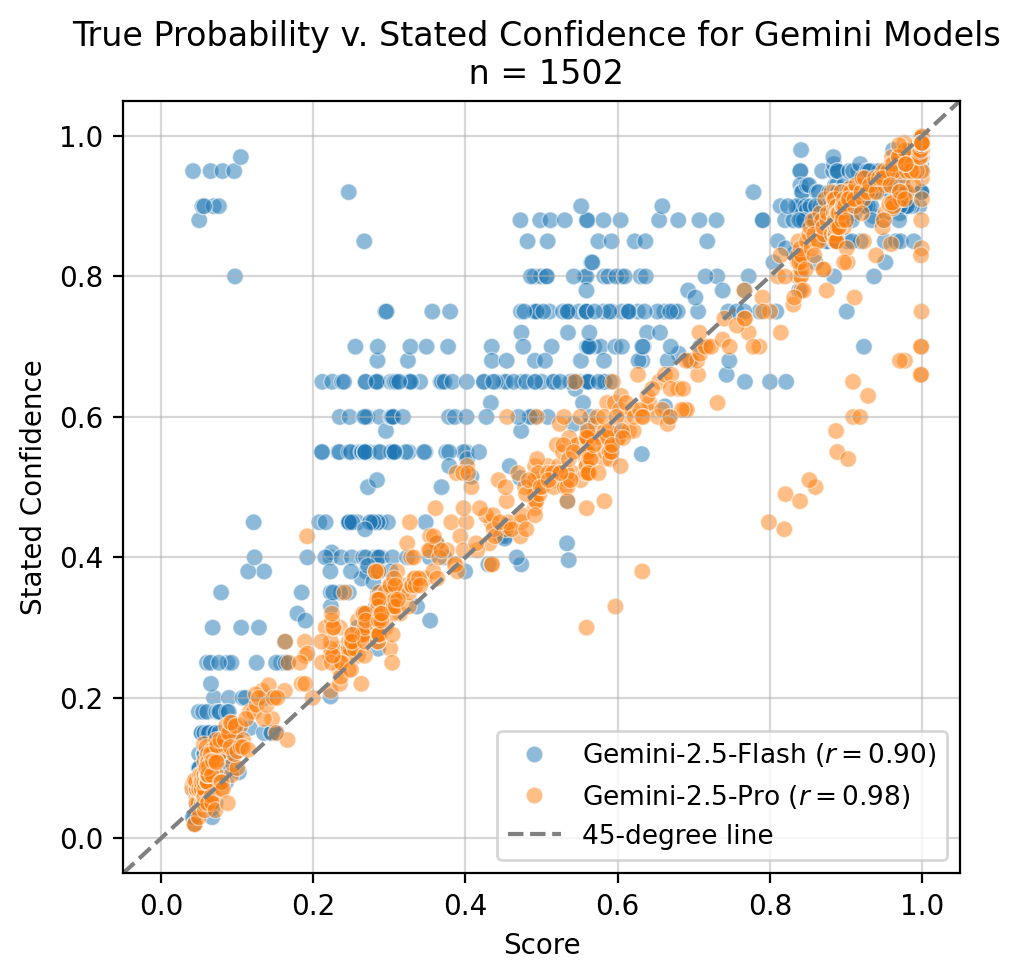

GPT-4o error: 0.20995343814160455
GPT-o3 error: 0.08316511117882253


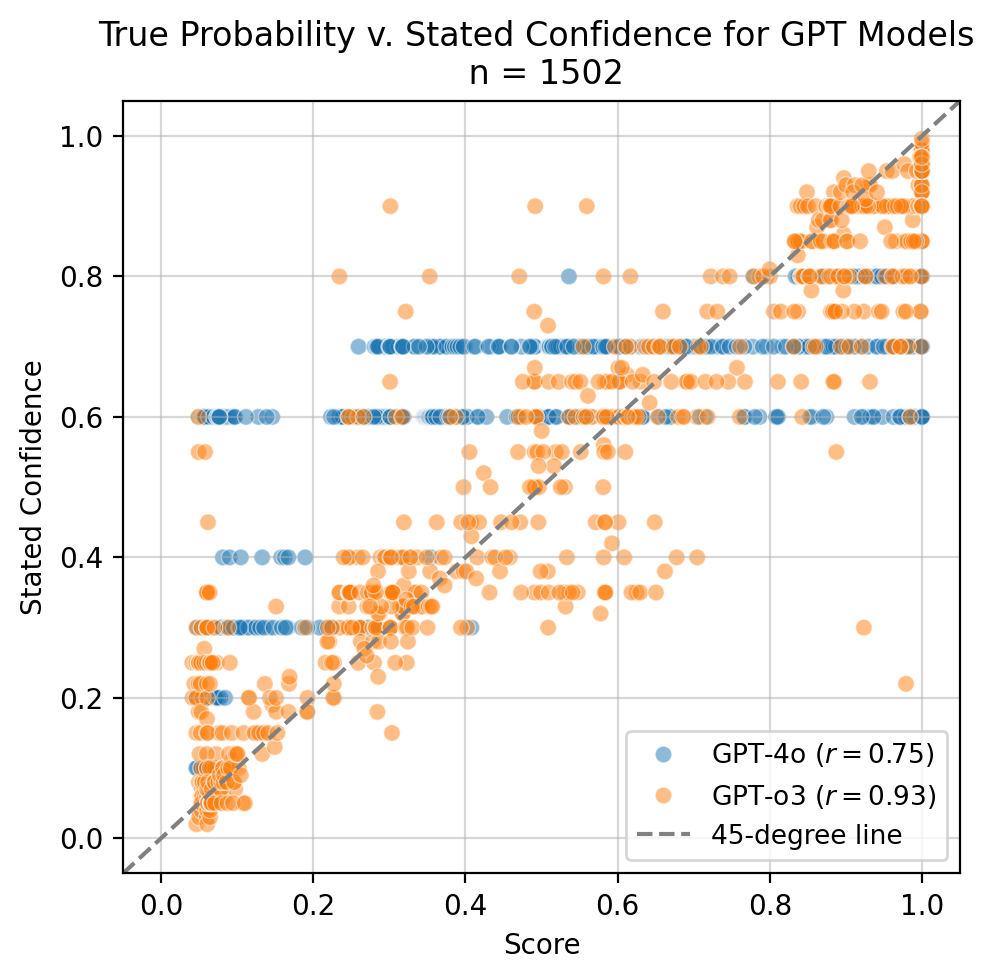

Llama-3.1-70B error: 0.29913165116939333
Llama-3.1-8B error: 0.3196451336281325


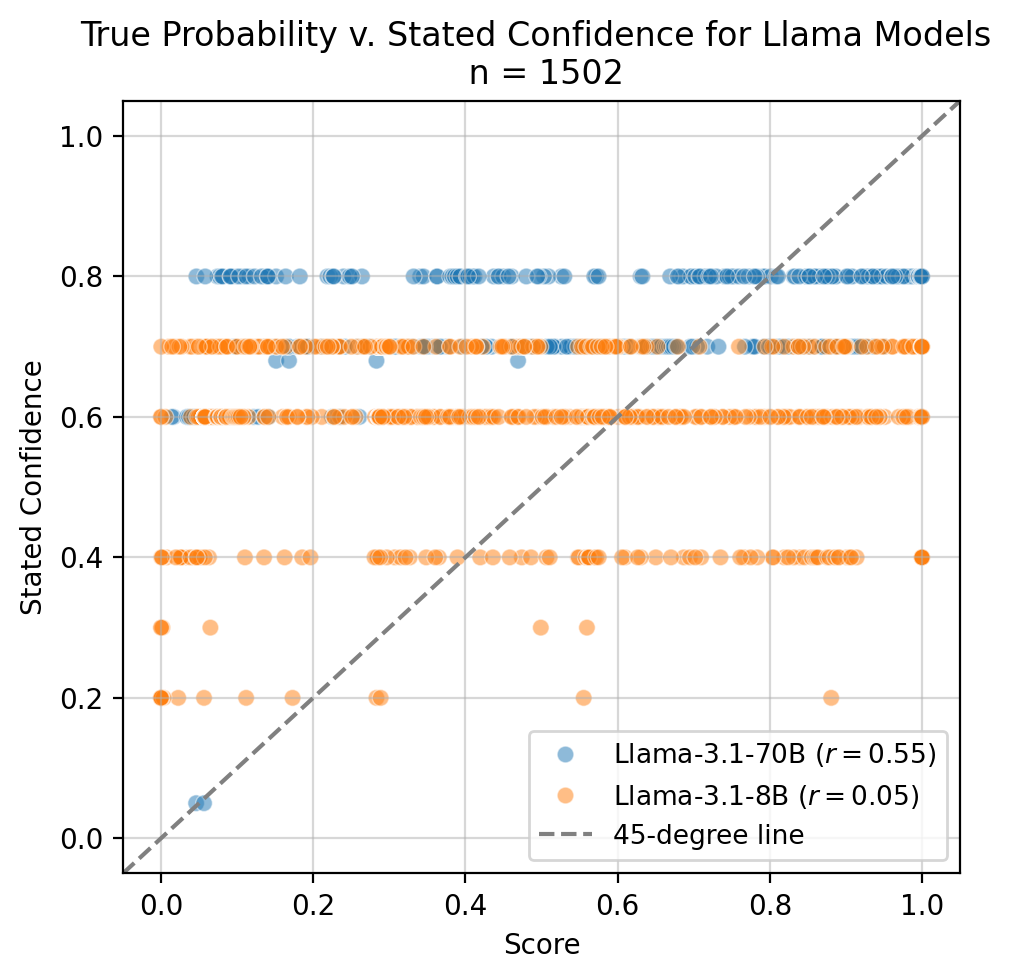

In [66]:
model_r = {}

for model_type in life_eval['Model Type'].unique():
    plt.figure(figsize=(5, 5), dpi=200)
    mini = life_eval[life_eval['Model Type'] == model_type]
    
    # Create the scatterplot
    ax = sns.scatterplot(
        data=mini, 
        x='Score', 
        y='Stated Confidence Answer', 
        hue='Model', 
        alpha=0.5
    )
    
    # Add the 45-degree reference line
    # We add it before getting handles so it appears in the list if we want it to,
    # though seaborn often manages the hue legend separately.
    line_45 = ax.axline([0, 0], [1, 1], color='grey', linestyle='--', label='45-degree line')

    # --- Logic to update Legend Labels with Pearson r ---
    
    # Get current handles and labels from the plot
    # This usually captures the hue categories (Models) and potentially the axline
    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    
    for label in labels:
        # Check if the label matches a model in our current subset
        if label in mini['Model'].unique():
            # Filter data specifically for this model to calculate r
            model_subset = mini[mini['Model'] == label]
            
            # Drop NaNs to ensure stats.pearsonr works correctly
            valid_data = model_subset[['Score', 'Stated Confidence Answer']].dropna()

            abs_err = abs(model_subset['Score'] - model_subset['Stated Confidence Answer']).mean()
            print(f"{label} error: {abs_err}")

            
            if len(valid_data) > 1:
                r, p_val = stats.pearsonr(valid_data['Score'], valid_data['Stated Confidence Answer'])
                new_labels.append(f"{label} ($r={r:.2f}$)")
                model_r[label] = r
            else:
                new_labels.append(label)
        else:
            # Preserve titles or other labels (like 'Model' or '45-degree line')
            new_labels.append(label)

    # Ensure the 45-degree line is in the legend if not picked up automatically
    # (Seaborn sometimes separates hue legends from manual plot additions)
    if '45-degree line' not in labels:
        handles.append(line_45)
        new_labels.append('45-degree line')

    # Re-apply the legend with updated labels
    ax.legend(handles=handles, labels=new_labels, loc='lower right', fontsize=9.5)

    # Final Plot Formatting
    plt.ylabel('Stated Confidence')
    if model_type == 'Deepseek':
        model_type = 'DeepSeek'
    plt.title(f"True Probability v. Stated Confidence for {model_type} Models \n n = {len(mini)}")
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.show()

Lets clean it up to include what we want:

In [67]:
cols = ['Question ID', 'Model', 'Answer', 'Stated Confidence Answer','Token Probability Answer', 'Score']

data = life_eval[cols].copy()

data['Question ID'] = data['Question ID'].astype(int)
data['Score'] = data['Score'].astype(float)
data['Stated Confidence Answer'] = data['Stated Confidence Answer'].astype(float)


data['Age'] = data.apply(lambda x: get_age(x['Question ID']), axis = 1)
data['Radius'] = qid_to_rads(data['Question ID'])

# Calculate Overconfidence

# Calculate Calibration Error row wise so that we get ECE and Accuracy together in one groupby statement
data['Stated Calibration Error'] = abs(data['Stated Confidence Answer'] - data['Score']) 
data['Token Calibation Error'] = abs(data['Token Probability Answer'] - data['Score'])

data

grouped = data.groupby(['Model', 'Radius']).agg("mean")[['Answer', 'Stated Confidence Answer', 'Token Probability Answer', 'Score', 'Stated Calibration Error', 'Token Calibation Error']]


grouped = grouped.rename(columns = {
    "Answer": "Mean Answer",
    "Stated Confidence Answer": "Mean Stated Confidence",
    "Token Probability Answer": "Mean Token Probability",
    "Score": "Accuracy",
    "Stated Calibration Error": "Stated ECE",
    "Token Calibation Error": "Token ECE"
})

grouped['Stated Overconfidence'] = grouped['Mean Stated Confidence'] - grouped['Accuracy']
grouped['Token Overconfidence'] = grouped['Mean Token Probability'] - grouped['Accuracy']

grouped.reset_index(inplace=True)

## Overconfidence by Radii

### Stated Overconfidence

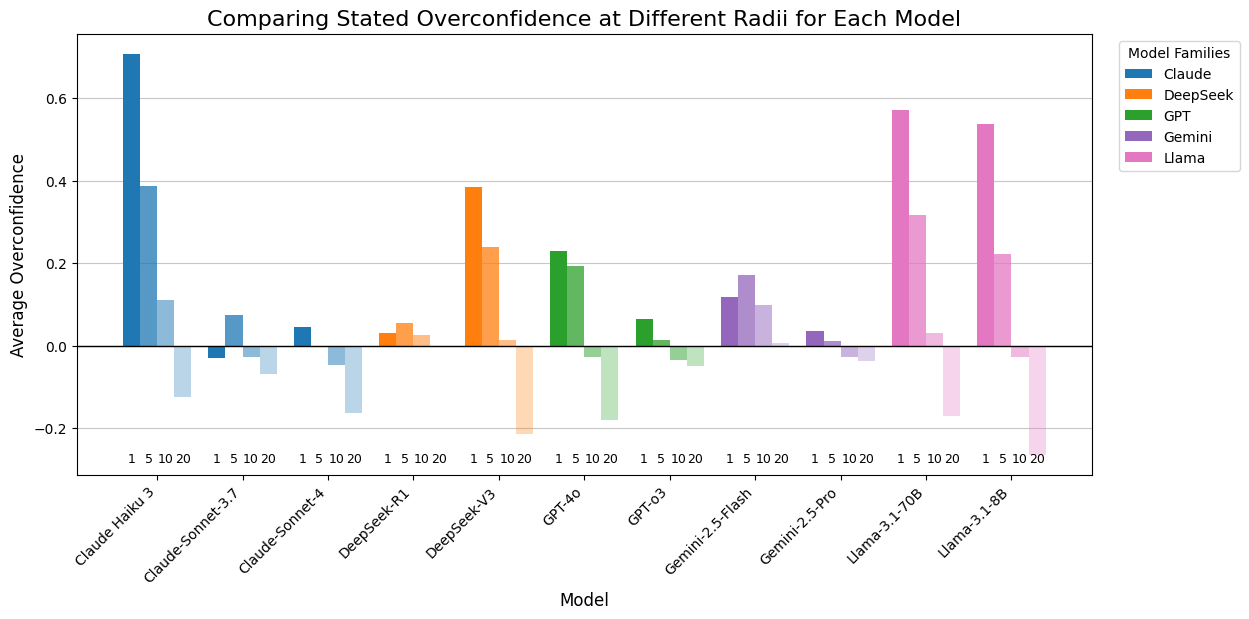

In [68]:

# --- 2. Data Preparation ---

# Function to get model family from its name
def get_model_family(model_name):
    if 'Claude' in model_name:
        return 'Claude'
    if 'DeepSeek' in model_name:
        return 'DeepSeek'
    if 'GPT' in model_name:
        return 'GPT'
    if 'Gemini' in model_name:
        return 'Gemini'
    if 'Llama' in model_name:
        return 'Llama'
    return 'Other'

# Add the 'Model Family' column to your DataFrame
grouped['Model Family'] = grouped['Model'].apply(get_model_family)

# Define the colors for each family (from your plot)
family_colors = {
    'GPT': '#2ca02c',       # Green
    'Claude': '#1f77b4',    # Blue
    'Gemini': '#9467bd',    # Purple
    'DeepSeek': '#ff7f0e',  # Orange
    'Llama': '#e377c2',     # Pink
    'Other': '#7f7f7f'      # Grey
}

# Define the shades (alpha) for each radius
# We'll map 1 to be the darkest (alpha=1.0) and 20 to be the lightest
radius_alphas = {1: 1.0, 5: 0.75, 10: 0.5, 20: 0.3}

# Get lists of unique models and radii
models = grouped['Model'].unique()
radii = sorted(grouped['Radius'].unique())
n_models = len(models)
n_radii = len(radii)


# --- 3. Plotting ---

fig, ax = plt.subplots(figsize=(14, 7))

# Define total width for one model's group of bars
group_width = 0.8
# Define width of a single bar
bar_width = group_width / n_radii
# Set the x-axis positions for the center of each group
x_positions = np.arange(n_models)

legend_handles = {}

# Loop over each model to plot its group of bars
for i, model in enumerate(models):
    # Get the data just for this model, sorted by radius
    model_data = grouped[grouped['Model'] == model].sort_values('Radius')
    
    # Loop over each radius to plot its specific bar
    for j, radius in enumerate(radii):
        bar_data = model_data[model_data['Radius'] == radius]
        
        if bar_data.empty:
            continue
            
        # Get the value, family, color, and alpha
        value = bar_data['Stated Overconfidence'].values[0]
        family = bar_data['Model Family'].values[0]
        color = family_colors.get(family, 'grey')
        alpha = radius_alphas.get(radius, 0.5)
        
        # Calculate the x-position for this specific bar
        # Start from the group's center (x_positions[i])
        # Move left by half the group_width
        # Move right by (j * bar_width) to get to this bar's left edge
        # Move right by half a bar_width to get to this bar's center
        x_pos = x_positions[i] - (group_width / 2) + (j * bar_width) + (bar_width / 2)
        
        # Plot the bar
        bar = ax.bar(
            x_pos,
            value,
            width=bar_width,
            color=color,
            alpha=alpha,
            label=family
        )
        
        # Store one bar per family for the legend
        if family not in legend_handles:
            legend_handles[family] = bar

# --- 4. Styling and Labels ---

# Set plot title and labels
ax.set_title('Comparing Stated Overconfidence at Different Radii for Each Model', fontsize=16)
ax.set_ylabel('Average Overconfidence', fontsize=12)
ax.set_xlabel('Model', fontsize=12)

# Set the x-axis ticks to be the model names
ax.set_xticks(x_positions)
ax.set_xticklabels(models, rotation=45, ha='right' )

# Add the '1 5 10 20' sub-labels
radius_label = ' '.join(map(str, radii))
radius_labels = ['1', '5', '10', '20']
for i in x_positions:
    shift = -bar_width * 2 + 0.5 * bar_width
    for r in radius_labels:
        xpos = i + shift
        ax.text(
            xpos,                      # x-position (center of the group)
            0.05,                  # y-position (just above the x-axis)
            r,           # The text
            ha='center',            # Horizontal alignment
            va='top',               # Vertical alignment
            transform= ax.get_xaxis_transform(), # Use axis coordinates for y
            fontsize=9,
            color='black'
        )

        shift += bar_width

# Add y=0 horizontal line
ax.axhline(0, color='black', linewidth=1.0)
# Add horizontal grid lines
ax.yaxis.grid(True, linestyle='-', alpha=0.7)
ax.set_axisbelow(True) # Put grid behind bars

# Create the legend
ax.legend(
    legend_handles.values(),
    legend_handles.keys(),
    title='Model Families',
    bbox_to_anchor=(1.02, 1), # Position legend outside the plot
    loc='upper left'
)

# Adjust layout to prevent labels from being cut off
plt.subplots_adjust(bottom=0.25, right=0.85)

# Show the plot
plt.show()

**NOTE** Include in paper.

### Token Overconfidence

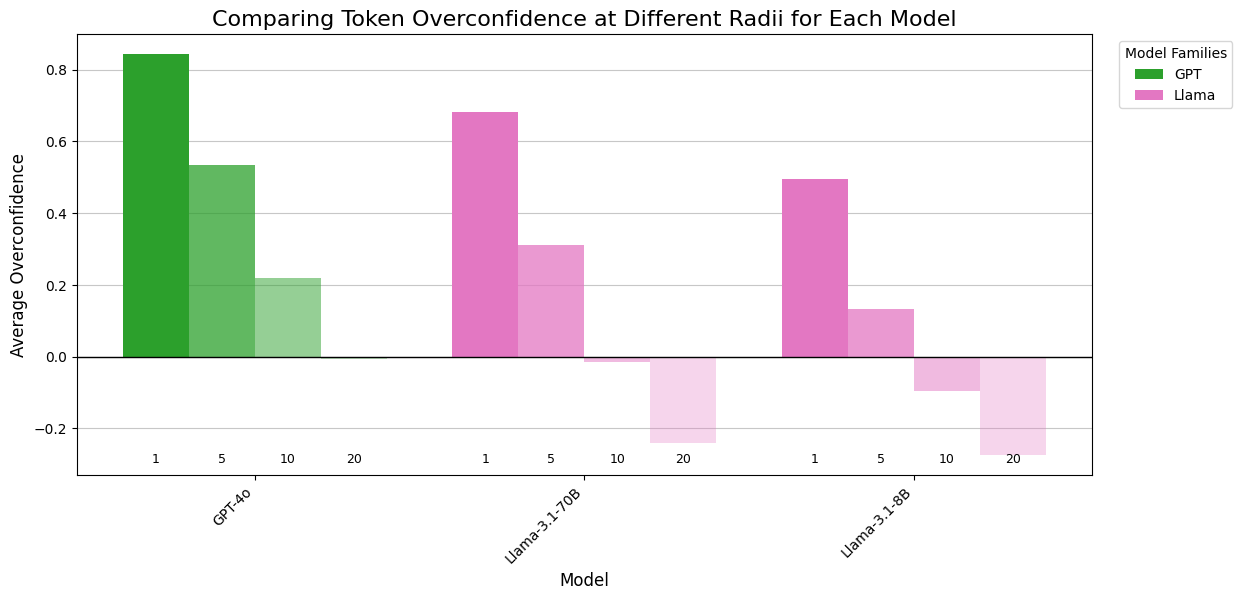

In [69]:
only_token_grouped = grouped[grouped['Model'].isin(has_tokens)].copy()

# Function to get model family from its name
def get_model_family(model_name):
    if 'Claude' in model_name:
        return 'Claude'
    if 'DeepSeek' in model_name:
        return 'DeepSeek'
    if 'GPT' in model_name:
        return 'GPT'
    if 'Gemini' in model_name:
        return 'Gemini'
    if 'Llama' in model_name:
        return 'Llama'
    return 'Other'

# Add the 'Model Family' column to your DataFrame
only_token_grouped['Model Family'] = only_token_grouped['Model'].apply(get_model_family)

# Define the colors for each family (from your plot)
family_colors = {
    'GPT': '#2ca02c',       # Green
    'Claude': '#1f77b4',    # Blue
    'Gemini': '#9467bd',    # Purple
    'DeepSeek': '#ff7f0e',  # Orange
    'Llama': '#e377c2',     # Pink
    'Other': '#7f7f7f'      # Grey
}

# Define the shades (alpha) for each radius
# We'll map 1 to be the darkest (alpha=1.0) and 20 to be the lightest
radius_alphas = {1: 1.0, 5: 0.75, 10: 0.5, 20: 0.3}

# Get lists of unique models and radii
models = only_token_grouped['Model'].unique()
radii = sorted(only_token_grouped['Radius'].unique())
n_models = len(models)
n_radii = len(radii)


# --- 3. Plotting ---

fig, ax = plt.subplots(figsize=(14, 7))

# Define total width for one model's group of bars
group_width = 0.8
# Define width of a single bar
bar_width = group_width / n_radii
# Set the x-axis positions for the center of each group
x_positions = np.arange(n_models)

legend_handles = {}

# Loop over each model to plot its group of bars
for i, model in enumerate(models):
    # Get the data just for this model, sorted by radius
    model_data = only_token_grouped[only_token_grouped['Model'] == model].sort_values('Radius')
    
    # Loop over each radius to plot its specific bar
    for j, radius in enumerate(radii):
        bar_data = model_data[model_data['Radius'] == radius]
        
        if bar_data.empty:
            continue
            
        # Get the value, family, color, and alpha
        value = bar_data['Token Overconfidence'].values[0]
        family = bar_data['Model Family'].values[0]
        color = family_colors.get(family, 'grey')
        alpha = radius_alphas.get(radius, 0.5)
        
        # Calculate the x-position for this specific bar
        # Start from the group's center (x_positions[i])
        # Move left by half the group_width
        # Move right by (j * bar_width) to get to this bar's left edge
        # Move right by half a bar_width to get to this bar's center
        x_pos = x_positions[i] - (group_width / 2) + (j * bar_width) + (bar_width / 2)
        
        # Plot the bar
        bar = ax.bar(
            x_pos,
            value,
            width=bar_width,
            color=color,
            alpha=alpha,
            label=family
        )
        
        # Store one bar per family for the legend
        if family not in legend_handles:
            legend_handles[family] = bar

# --- 4. Styling and Labels ---

# Set plot title and labels
ax.set_title('Comparing Token Overconfidence at Different Radii for Each Model', fontsize=16)
ax.set_ylabel('Average Overconfidence', fontsize=12)
ax.set_xlabel('Model', fontsize=12)

# Set the x-axis ticks to be the model names
ax.set_xticks(x_positions)
ax.set_xticklabels(models, rotation=45, ha='right')

# Add the '1 5 10 20' sub-labels
radius_label = ' '.join(map(str, radii))
radius_labels = ['1', '5', '10', '20']
for i in x_positions:
    shift = -bar_width * 2 + 0.5 * bar_width
    for r in radius_labels:
        xpos = i + shift
        ax.text(
            xpos,                      # x-position (center of the group)
            0.05,                  # y-position (just above the x-axis)
            r,           # The text
            ha='center',            # Horizontal alignment
            va='top',               # Vertical alignment
            transform= ax.get_xaxis_transform(), # Use axis coordinates for y
            fontsize=9,
            color='black'
        )

        shift += bar_width

# Add y=0 horizontal line
ax.axhline(0, color='black', linewidth=1.0)
# Add horizontal grid lines
ax.yaxis.grid(True, linestyle='-', alpha=0.7)
ax.set_axisbelow(True) # Put grid behind bars

# Create the legend
ax.legend(
    legend_handles.values(),
    legend_handles.keys(),
    title='Model Families',
    bbox_to_anchor=(1.02, 1), # Position legend outside the plot
    loc='upper left'
)

# Adjust layout to prevent labels from being cut off
plt.subplots_adjust(bottom=0.25, right=0.85)

# Show the plot
plt.show()

It seems that the Hard-Esay effect is prevelent when analyzing both stated and token overconfidence.

## Pearson Coef. By Reasoning v. Not Reasoning Models


In [70]:
subset

Score   SC  Token Score  Token Probability         Model  \
158078  0.046215  0.7          NaN                NaN  Llama-3.1-8B   
158079  0.232835  0.7          NaN                NaN  Llama-3.1-8B   
158080  0.469277  0.7          NaN                NaN  Llama-3.1-8B   
158081  0.831361  0.7          NaN                NaN  Llama-3.1-8B   
158082  0.043737  0.7          NaN                NaN  Llama-3.1-8B   
...          ...  ...          ...                ...           ...   
158824  1.000000  0.6          NaN                NaN  Llama-3.1-8B   
158825  0.268128  0.7          NaN                NaN  Llama-3.1-8B   
158826  0.998065  0.6          NaN                NaN  Llama-3.1-8B   
158827  0.999996  0.6          NaN                NaN  Llama-3.1-8B   
158828  1.000000  0.7          NaN                NaN  Llama-3.1-8B   

       Question Set                    Type  bin  
158078     LifeEval  Probability Estimation  NaN  
158079     LifeEval  Probability Estimation  NaN  
158080     LifeEval  Probability Estimation  NaN  
158081     LifeEval  Probability Estimation  NaN  
158082     LifeEval  Probability Estimation  NaN  
...             ...                     ...  ...  
158824     LifeEval  Probability Estimation  NaN  
158825     LifeEval  Probability Estimation  NaN  
158826     LifeEval  Probability Estimation  NaN  
158827     LifeEval  Probability Estimation  NaN  
158828     LifeEval  Probability Estimation  NaN  

[751 rows x 8 columns]

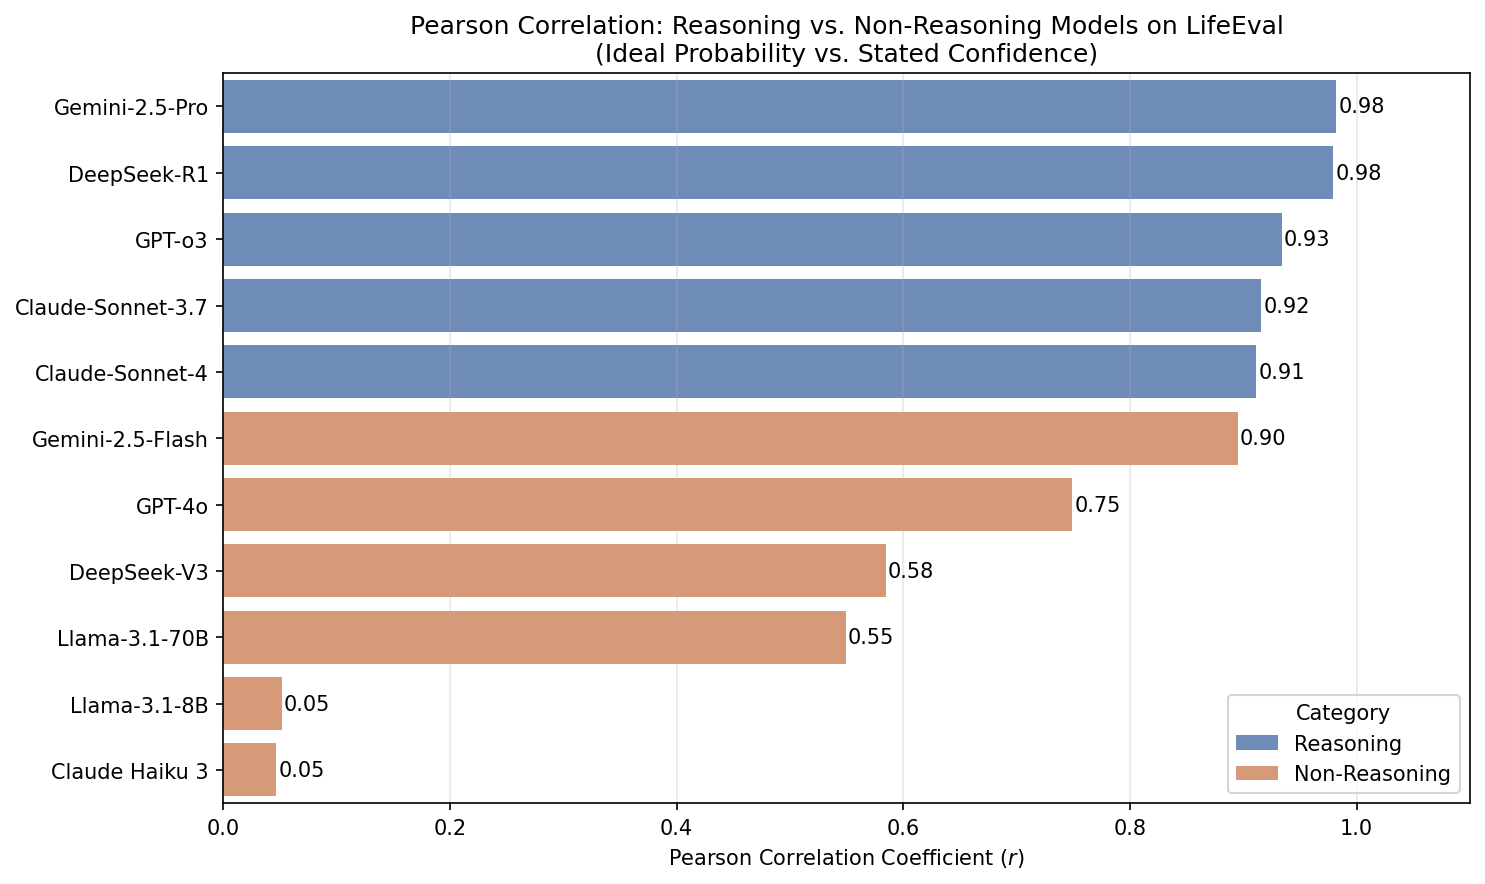

In [71]:
reasoning_models = [
    'Claude-Sonnet-3.7',
    'Claude-Sonnet-4',
    'DeepSeek-R1',
    'Gemini-2.5-Pro',
    'GPT-o3',
]

non_reasoning_models = [
    'Claude Haiku 3',
    'Gemini-2.5-Flash',
]

def calc_pearson(data, x: str = 'Highest Probability', y: str = 'Stated Confidence Answer'):
    r, p_val = stats.pearsonr(data[x], data[y])

    return r


r_data = life_eval[['Model','Highest Probability', 'Stated Confidence Answer', 'Score']]


# Group by Model and calculate Pearson r
results = []
for model in r_data['Model'].unique():
    subset = r_data[r_data['Model'] == model]
    r_val = calc_pearson(subset, x = "Score", y = "Stated Confidence Answer")
    
    # Determine Category
    if model in reasoning_models:
        cat = 'Reasoning'
    else:
        cat = 'Non-Reasoning'
        
    results.append({'Model': model, 'Pearson_r': r_val, 'Category': cat})

res_df = pd.DataFrame(results)

# Sort by Category first, then by Pearson r for cleaner plotting
res_df = res_df.sort_values(by=['Category', 'Pearson_r'], ascending=[False, False])

# --- 3. Visualization ---

plt.figure(figsize=(10, 6), dpi=150)

# Create a horizontal bar plot
# using hue to distinguish categories
ax = sns.barplot(
    data=res_df,
    y='Model',
    x='Pearson_r',
    hue='Category',
    dodge=False, # Aligns bars nicely
    palette={'Reasoning': "#6388c3", 'Non-Reasoning': "#e69668", 'Other': 'gray'}
)

# Add the actual values to the end of the bars
for i in ax.containers:

    ax.bar_label(i, fmt='%.2f', padding=1 , label_type = "edge")


plt.title('Pearson Correlation: Reasoning vs. Non-Reasoning Models on LifeEval\n(Ideal Probability vs. Stated Confidence)')
plt.xlabel('Pearson Correlation Coefficient ($r$)')
plt.ylabel('')
plt.grid(axis='x', alpha=0.3)
plt.xlim(0, 1.1) # Assuming positive correlation; adjust if negative exist

plt.tight_layout()
plt.show()

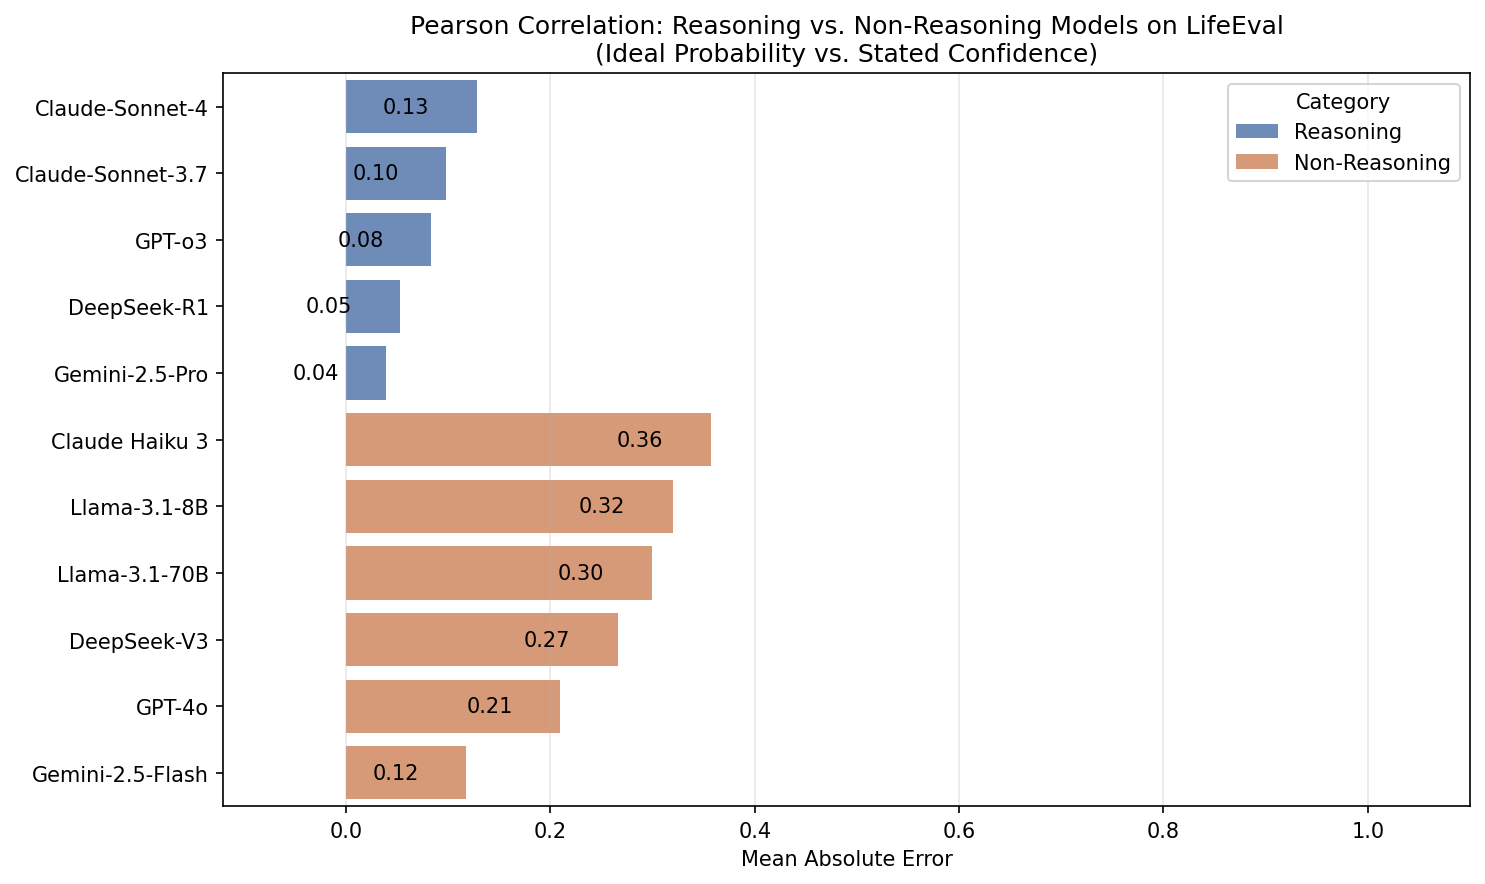

In [72]:
reasoning_models = [
    'Claude-Sonnet-3.7',
    'Claude-Sonnet-4',
    'DeepSeek-R1',
    'Gemini-2.5-Pro',
    'GPT-o3',
]

non_reasoning_models = [
    'Claude Haiku 3',
    'Gemini-2.5-Flash',
]

def calc_pearson(data, x: str = 'Highest Probability', y: str = 'Stated Confidence Answer'):
    r, p_val = stats.pearsonr(data[x], data[y])

    return r


r_data = life_eval[['Model','Highest Probability', 'Stated Confidence Answer', 'Score']]


# Group by Model and calculate Pearson r
results = []
for model in r_data['Model'].unique():
    subset = r_data[r_data['Model'] == model]
    err = abs(subset['Score'] - subset['Stated Confidence Answer']).mean()
    
    # Determine Category
    if model in reasoning_models:
        cat = 'Reasoning'
    else:
        cat = 'Non-Reasoning'
        
    results.append({'Model': model, 'Error': err, 'Category': cat})

res_df = pd.DataFrame(results)

# Sort by Category first, then by Pearson r for cleaner plotting
res_df = res_df.sort_values(by=['Category', 'Error'], ascending=[False, False])

# --- 3. Visualization ---

plt.figure(figsize=(10, 6), dpi=150)

# Create a horizontal bar plot
# using hue to distinguish categories
ax = sns.barplot(
    data=res_df,
    y='Model',
    x='Error',
    hue='Category',
    dodge=False, # Aligns bars nicely
    palette={'Reasoning': "#6388c3", 'Non-Reasoning': "#e69668", 'Other': 'gray'}
)

# Add the actual values to the end of the bars
for i in ax.containers:

    ax.bar_label(i, fmt='%.2f', padding=-45, label_type = "edge")


plt.title('Pearson Correlation: Reasoning vs. Non-Reasoning Models on LifeEval\n(Ideal Probability vs. Stated Confidence)')
plt.xlabel('Mean Absolute Error')
plt.ylabel('')
plt.grid(axis='x', alpha=0.3)
plt.xlim(-0.12, 1.1) # Assuming positive correlation; adjust if negative exist

plt.tight_layout()
plt.show()

In [225]:
combined_clean['Token Probability Answer']

0       NaN
2       NaN
3       NaN
4       NaN
5       NaN
         ..
82636   NaN
82637   NaN
82638   NaN
82639   NaN
82640   NaN
Name: Token Probability Answer, Length: 69278, dtype: float64

In [236]:
reasoning_models = [
    'Claude-Sonnet-3.7',
    'Claude-Sonnet-4',
    'DeepSeek-R1',
    'Gemini-2.5-Pro',
    'GPT-o3',
]

le = combined_clean[combined_clean['Question Set'] == 'LifeEval']

le_reasoning = le[le['Model'].isin(reasoning_models)]
le_chat = le[~le['Model'].isin(reasoning_models)]


def percent_rounded(df, col: str = 'Stated Confidence Answer'):
    return np.mean((df[col].astype(float) * 100) % 5 == 0)


round_r = percent_rounded(le_reasoning)
round_c = percent_rounded(le_chat)
print("Stated Confidence:")
print('   LifeEval:')
print(f"        Reasoning Models: {round_r * 100:.5}%")
print(f"        Chat Models:      {round_c * 100:.5}%")

print("   Overall")

cc_r = combined_clean[combined_clean['Model'].isin(reasoning_models)]
cc_c = combined_clean[~combined_clean['Model'].isin(reasoning_models)]

cc_percent_round_r = percent_rounded(cc_r)
cc_percent_round_c = percent_rounded(cc_c)


print(f"        Reasoning Models: {cc_percent_round_r * 100:.5}%")
print(f"        Chat Models:      {cc_percent_round_c * 100:.5}%")


print("Token Probability:")
round_r = percent_rounded(le_reasoning, 'Token Probability Answer')
round_c = percent_rounded(le_chat, 'Token Probability Answer')
print('   LifeEval:')
print(f"        Reasoning Models: {round_r * 100:.5}%           # Note: we don’t get Token Probs for Reasoning Models")
print(f"        Chat Models:      {round_c * 100:.5}%")
cc_percent_round_r = percent_rounded(cc_r, 'Token Probability Answer')
cc_percent_round_c = percent_rounded(cc_c, 'Token Probability Answer')
print("   Overall")
print(f"        Reasoning Models: {cc_percent_round_r * 100:.5}%           # Note: we don’t get Token Probs for Reasoning Models")
print(f"        Chat Models:      {cc_percent_round_c * 100:.5}%")




Stated Confidence:
   LifeEval:
        Reasoning Models: 61.145%
        Chat Models:      91.389%
   Overall
        Reasoning Models: 59.717%
        Chat Models:      76.506%
Token Probability:
   LifeEval:
        Reasoning Models: 0.0%           # Note: we don’t get Token Probs for Reasoning Models
        Chat Models:      1.3759%
   Overall
        Reasoning Models: 0.0%           # Note: we don’t get Token Probs for Reasoning Models
        Chat Models:      0.16407%


In [231]:
cc_r['Token Probability Answer'].value_counts()

Series([], Name: count, dtype: int64)

## LifeEval Summary Table

In [279]:
le

Reasoning Answer  \
5270   For an American male at birth (0 years), I nee...     77   
5271   For an American male at birth (0 years), I nee...     77   
5272   For an American male at birth (0 years), I nee...     77   
5273   For an American male at birth (0 years), I nee...     77   
5274   For an American male who has already lived to ...     77   
...                                                  ...    ...   
81200  According to the Social Security Administratio...  105.0   
81201  According to the Social Security Administratio...  103.0   
81202  According to the Social Security Administratio...  105.0   
81203  According to the Social Security Administratio...  105.0   
81204  According to the Social Security Administratio...  102.0   

      Stated Confidence Answer  Coerce  \
5270                      0.01    True   
5271                      0.25    True   
5272                      0.65    True   
5273                      0.68    True   
5274                      0.05    True   
...                        ...     ...   
81200                      0.6    True   
81201                      0.7    True   
81202                      0.6    True   
81203                      0.6    True   
81204                      0.7    True   

                                                 Content Question ID  \
5270   {\n    "Reasoning": "For an American male at b...           0   
5271   {\n    "Reasoning": "For an American male at b...           1   
5272   {\n    "Reasoning": "For an American male at b...           2   
5273   {\n    "Reasoning": "For an American male at b...           3   
5274   {\n    "Reasoning": "For an American male who ...           4   
...                                                  ...         ...   
81200  {\n  "Reasoning": "According to the Social Sec...         803   
81201  {\n  "Reasoning": "According to the Social Sec...         804   
81202  {\n  "Reasoning": "According to the Social Sec...         805   
81203  {\n  "Reasoning": "According to the Social Sec...         806   
81204  {\n  "Reasoning": "According to the Social Sec...         807   

                   Model Model Type Question Set     Score  ...  \
5270   Claude-Sonnet-3.7     Claude     LifeEval  0.049038  ...   
5271   Claude-Sonnet-3.7     Claude     LifeEval  0.244690  ...   
5272   Claude-Sonnet-3.7     Claude     LifeEval  0.487341  ...   
5273   Claude-Sonnet-3.7     Claude     LifeEval  0.834496  ...   
5274   Claude-Sonnet-3.7     Claude     LifeEval  0.049337  ...   
...                  ...        ...          ...       ...  ...   
81200       Llama-3.1-8B      Llama     LifeEval  1.000000  ...   
81201       Llama-3.1-8B      Llama     LifeEval  0.268128  ...   
81202       Llama-3.1-8B      Llama     LifeEval  0.998065  ...   
81203       Llama-3.1-8B      Llama     LifeEval  0.999996  ...   
81204       Llama-3.1-8B      Llama     LifeEval  1.000000  ...   

      Token Probability True  Token Probability False  \
5270                     NaN                      NaN   
5271                     NaN                      NaN   
5272                     NaN                      NaN   
5273                     NaN                      NaN   
5274                     NaN                      NaN   
...                      ...                      ...   
81200                    NaN                      NaN   
81201                    NaN                      NaN   
81202                    NaN                      NaN   
81203                    NaN                      NaN   
81204                    NaN                      NaN   

       Token Probability Answer  Token Probability A  Token Probability B  \
5270                        NaN                  NaN                  NaN   
5271                        NaN                  NaN                  NaN   
5272                        NaN                  NaN                  NaN   
5273                        NaN                  NaN                  NaN 

In [328]:
le = combined_clean[combined_clean['Question Set'] == 'LifeEval'][["Question ID", "Score", "Stated Confidence Answer", "Answer", "Model"]].astype(float,errors = "ignore")
le = pd.merge(le, best_df, on = "Question ID", how = "inner")

raw_df = pd.read_csv(r"Combined Results\combined_raw.csv")
le_raw = raw_df[raw_df['Question Set'] == 'LifeEval']


def run_regression(df, x_col: str = 'Highest Probability', conf_col: str = "Stated Confidence Answer"):
    "This measures the relation between difficulty and calibration error"

    x = -df[x_col] # As the MAS increases the difficulty decreases

    y = df[conf_col] - df["Score"]

    slope, intercept = np.polyfit(x, y, 1)
    return slope
    # # 3. Get Stickiness (R-squared)
    # # corrcoef returns a matrix, we take [0,1] to get the correlation (r)
    # correlation = np.corrcoef(x, y)[0, 1]
    # r_squared = correlation ** 2

    # print(f"Slope: {slope:.4f}")
    # print(f"Stickiness (R²): {r_squared:.4f}")


# Final Amount Kept for analysis
num_kept = 751 # hard coded from above cells 


res = {}



model_names = {
    "gpt-4o": "GPT-4o",
    "o3-2025-04-16": "GPT-o3",
    "claude-sonnet-4-20250514": "Claude-Sonnet-4",
    "claude-3-7-sonnet-20250219": "Claude-Sonnet-3.7",
    "claude-3-haiku-20240307": "Claude Haiku 3",
    "gemini-2.5-pro": "Gemini-2.5-Pro",
    "gemini-2.5-flash": "Gemini-2.5-Flash",
    "Meta-Llama-3.1-8B-Instruct": "Llama-3.1-8B",
    "Meta-Llama-3.1-70B-Instruct": "Llama-3.1-70B",
    "deepseek-r1": "DeepSeek-R1",
    "deepseek-v3": "DeepSeek-V3",
}

inverted_model_names = {value: key for key, value in model_names.items()}


for model in le['Model'].unique():

    df = le[le['Model'] == model]

    # Get Accuracy/ Score
    acc = df['Score'].mean()

    # Get ECE
    ece = get_ece(df["Score"].astype(float), df['Stated Confidence Answer'].astype(float))

    # Get Confidence
    conf = df['Stated Confidence Answer'].astype(float).mean()

    # Number of completions
    num_comp = le_raw[le_raw['Model'] == inverted_model_names[model]]['Coerce'].sum() # All the responses

    # Percent Rounded
    pr = percent_rounded(df) * 100
    # Difficulty Sensitivity

    rho = run_regression(df)

    res[model] = {
        "Mean Score": acc *100,
        "ECE": ece,
        "Mean Confidence": conf,
        "Percent Rounded": pr,
        "Sensitivity to Difficulty": rho,
        "Number of Completions": num_comp
    }

le_summary = pd.DataFrame(res)
display(le_summary)

print(le_summary.T.to_latex(float_format="%.3f"))

C:\Users\Noam Michael\AppData\Local\Temp\ipykernel_21036\1245298864.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv(r"Combined Results\combined_raw.csv")


Claude-Sonnet-3.7  Claude Haiku 3  Claude-Sonnet-4  \
Mean Score                         54.494200       53.023114        53.977573   
ECE                                 0.040398        0.267372         0.063226   
Mean Confidence                     0.531105        0.797603         0.497909   
Percent Rounded                    90.146471      100.000000        98.801598   
Sensitivity to Difficulty           0.180247        0.996228         0.326996   
Number of Completions             808.000000      808.000000       808.000000   

                           DeepSeek-R1  DeepSeek-V3  Gemini-2.5-Flash  \
Mean Score                   54.432430    53.263602         53.786849   
ECE                           0.030632     0.124056          0.097951   
Mean Confidence               0.572344     0.637217          0.635820   
Percent Rounded              29.027963   100.000000         48.868176   
Sensitivity to Difficulty     0.052734     0.781827          0.192396   
Number of Completions       808.000000   808.000000        808.000000   

                           Gemini-2.5-Pro      GPT-4o      GPT-o3  \
Mean Score                      53.840331   54.549136   54.247985   
ECE                              0.025394    0.085002    0.028931   
Mean Confidence                  0.534193    0.597670    0.541340   
Percent Rounded                 17.976032  100.000000   69.773635   
Sensitivity to Difficulty        0.092398    0.603586    0.188713   
Number of Completions          808.000000  808.000000  761.000000   

                           Llama-3.1-70B  Llama-3.1-8B  
Mean Score                     53.521022     48.389434  
ECE                             0.185064      0.141605  
Mean Confidence                 0.720266      0.598535  
Percent Rounded                99.467377    100.000000  
Sensitivity to Difficulty       0.874029      0.941416  
Number of Completions         807.000000    800.000000

\begin{tabular}{lrrrrrr}
\toprule
 & Mean Score & ECE & Mean Confidence & Percent Rounded & Sensitivity to Difficulty & Number of Completions \\
\midrule
Claude-Sonnet-3.7 & 54.494 & 0.040 & 0.531 & 90.146 & 0.180 & 808.000 \\
Claude Haiku 3 & 53.023 & 0.267 & 0.798 & 100.000 & 0.996 & 808.000 \\
Claude-Sonnet-4 & 53.978 & 0.063 & 0.498 & 98.802 & 0.327 & 808.000 \\
DeepSeek-R1 & 54.432 & 0.031 & 0.572 & 29.028 & 0.053 & 808.000 \\
DeepSeek-V3 & 53.264 & 0.124 & 0.637 & 100.000 & 0.782 & 808.000 \\
Gemini-2.5-Flash & 53.787 & 0.098 & 0.636 & 48.868 & 0.192 & 808.000 \\
Gemini-2.5-Pro & 53.840 & 0.025 & 0.534 & 17.976 & 0.092 & 808.000 \\
GPT-4o & 54.549 & 0.085 & 0.598 & 100.000 & 0.604 & 808.000 \\
GPT-o3 & 54.248 & 0.029 & 0.541 & 69.774 & 0.189 & 761.000 \\
Llama-3.1-70B & 53.521 & 0.185 & 0.720 & 99.467 & 0.874 & 807.000 \\
Llama-3.1-8B & 48.389 & 0.142 & 0.599 & 100.000 & 0.941 & 800.000 \\
\bottomrule
\end{tabular}



In [339]:
import pandas as pd

# Create an IndexSlice object helper
idx = pd.IndexSlice

# 1. Apply Green Gradient (Higher is Better)
# We select ROWS (metrics) and ALL COLUMNS (:)
s = le_summary.style.background_gradient(
    cmap='Greens', 
    axis=1, 
    subset=idx[['Mean Score', 'Mean Confidence', 'Number of Completions'], :] 
)

# 2. Apply Red Gradient (Lower is Better)
s = s.background_gradient(
    cmap='Reds', # Or 'Greens_r'
    axis=1,
    subset=idx[['ECE', 'Sensitivity to Difficulty', 'Percent Rounded'], :]
)

# 3. Export
print(s.to_latex(
    column_format="l" + "r"*11,
    hrules=True,
))

\begin{tabular}{lrrrrrrrrrrr}
\toprule
 & Claude-Sonnet-3.7 & Claude Haiku 3 & Claude-Sonnet-4 & DeepSeek-R1 & DeepSeek-V3 & Gemini-2.5-Flash & Gemini-2.5-Pro & GPT-4o & GPT-o3 & Llama-3.1-70B & Llama-3.1-8B \\
\midrule
Mean Score & \background-color#00471c \color#f1f1f1 54.494200 & \background-color#228a44 \color#f1f1f1 53.023114 & \background-color#006227 \color#f1f1f1 53.977573 & \background-color#00491d \color#f1f1f1 54.432430 & \background-color#17813d \color#f1f1f1 53.263602 & \background-color#006c2c \color#f1f1f1 53.786849 & \background-color#00692a \color#f1f1f1 53.840331 & \background-color#00441b \color#f1f1f1 54.549136 & \background-color#005321 \color#f1f1f1 54.247985 & \background-color#0b7734 \color#f1f1f1 53.521022 & \background-color#f7fcf5 \color#000000 48.389434 \\
ECE & \background-color#ffebe2 \color#000000 0.040398 & \background-color#67000d \color#f1f1f1 0.267372 & \background-color#fdd7c6 \color#000000 0.063226 & \background-color#fff2eb \color#000000 0.030632 &

In [326]:

le['Highest Probability'].mean()

np.float64(0.5680979964443874)

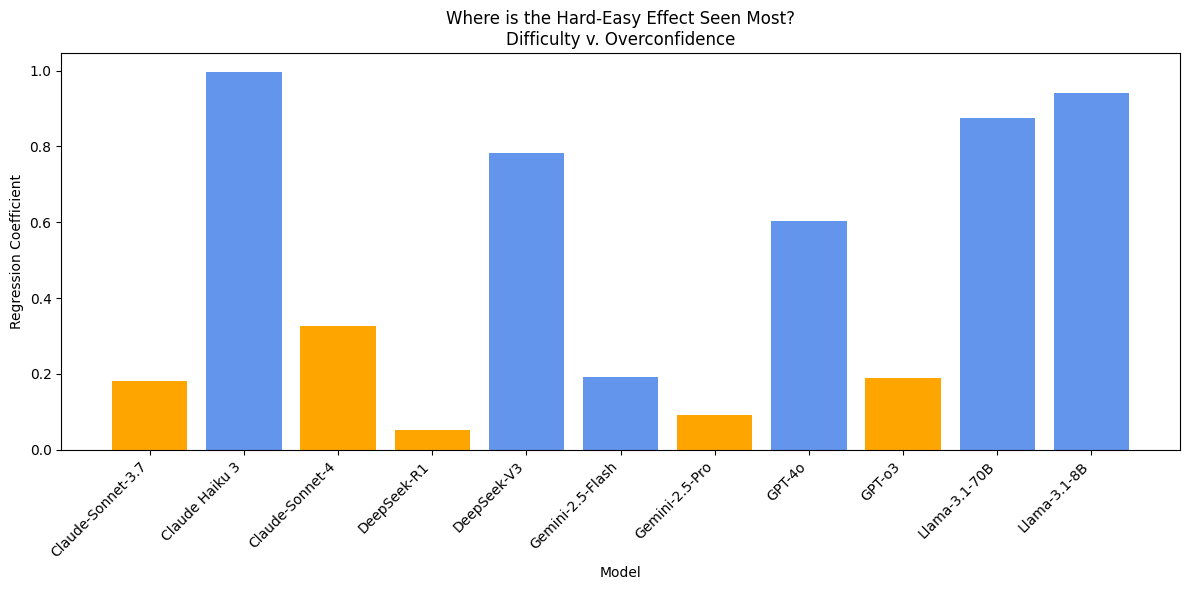

In [321]:
import matplotlib.pyplot as plt
is_reasoning= ['Claude-Sonnet-3.7', 'Claude-Sonnet-4', 'DeepSeek-R1', 'Gemini-2.5-Pro', 'GPT-o3']
# 1. Define your colors based on the condition
# Replace 'orange' and 'skyblue' with whatever colors you prefer
colors = ['orange' if col in is_reasoning else 'cornflowerblue' for col in le_summary.columns]

plt.figure(figsize=(12, 6))

# 2. Pass the colors list to the bar function
plt.bar(le_summary.columns, le_summary.loc['Sensitivity to Difficulty'], color=colors)

# Clean up the formatting
plt.xticks(rotation=45, ha='right')
#plt.axhline(y=100, color='gray', linestyle='--') # Optional benchmark line
plt.title("Where is the Hard-Easy Effect Seen Most?\nDifficulty v. Overconfidence")
plt.ylabel("Regression Coefficient")
plt.xlabel("Model")
plt.tight_layout()

plt.show()

In [348]:
rad_20 = le[le["Radius"] == 1]

rad_20['Stated Confidence Answer'].mean(), rad_20['Score'].mean()

(np.float64(0.3415011302211302), np.float64(0.09628234181156614))